In [2]:
import numpy as np
import datetime as dt
import spiceypy as spice
import matplotlib.pyplot as plt
from spacepy import pycdf

def print_info(cdf_file):
    for var_name in cdf_file.keys():
        print(f"Variable: {var_name}")
        print(f"  Data Type: {cdf_file[var_name].type()}")
        print(f"  Dimensions: {cdf_file[var_name].shape}")
        print(f"  Attributes: {cdf_file[var_name].attrs}")
        print()
    return

def filter_out_start_config_noise(data, epoch, removal_width = 32, new_config_delay = 0.1):
    # Create a mask for the data
    noise_mask = np.zeros(len(data))

    # Mask the next samples when dt is above new_config_delay, for which a new config. has been made
    delta_t = np.diff(epoch)
    delta_t = [dt.total_seconds() for dt in delta_t]

    i = 0
    for dt in delta_t:
        if dt > new_config_delay:
            noise_mask[i:i+removal_width] = 1
        i +=1

    noise_mask[:removal_width] = 1

    data[noise_mask == 1] = np.nan

    return data

def multiply_lists_by_33matrix(list1, list2, list3, matrix):
    res1 = np.zeros(len(list1))
    res2 = np.zeros(len(list1))
    res3 = np.zeros(len(list1))
    for i in range(len(list1)):
        vector = np.array([list1[i], list2[i], list3[i]])
        res1[i] = vector[0]*matrix[0, 0] + vector[1]*matrix[0, 1] + vector[2]*matrix[0, 2]
        res2[i] = vector[0]*matrix[1, 0] + vector[1]*matrix[1, 1] + vector[2]*matrix[1, 2]
        res3[i] = vector[0]*matrix[2, 0] + vector[1]*matrix[2, 1] + vector[2]*matrix[2, 2]
    return res1, res2, res3

def multiply_lists_by_44matrix(list1, list2, list3, list4, matrix):
    res1 = np.zeros(len(list1))
    res2 = np.zeros(len(list1))
    res3 = np.zeros(len(list1))
    res4 = np.zeros(len(list1))
    for i in range(len(list1)):
        vector = np.array([list1[i], list2[i], list3[i], list4[i]])
        res1[i] = vector[0]*matrix[0, 0] + vector[1]*matrix[0, 1] + vector[2]*matrix[0, 2] + vector[3]*matrix[0, 3]
        res2[i] = vector[0]*matrix[1, 0] + vector[1]*matrix[1, 1] + vector[2]*matrix[1, 2] + vector[3]*matrix[1, 3]
        res3[i] = vector[0]*matrix[2, 0] + vector[1]*matrix[2, 1] + vector[2]*matrix[2, 2] + vector[3]*matrix[2, 3]
        res4[i] = vector[0]*matrix[3, 0] + vector[1]*matrix[3, 1] + vector[2]*matrix[3, 2] + vector[3]*matrix[3, 3]
    return res1, res2, res3, res4

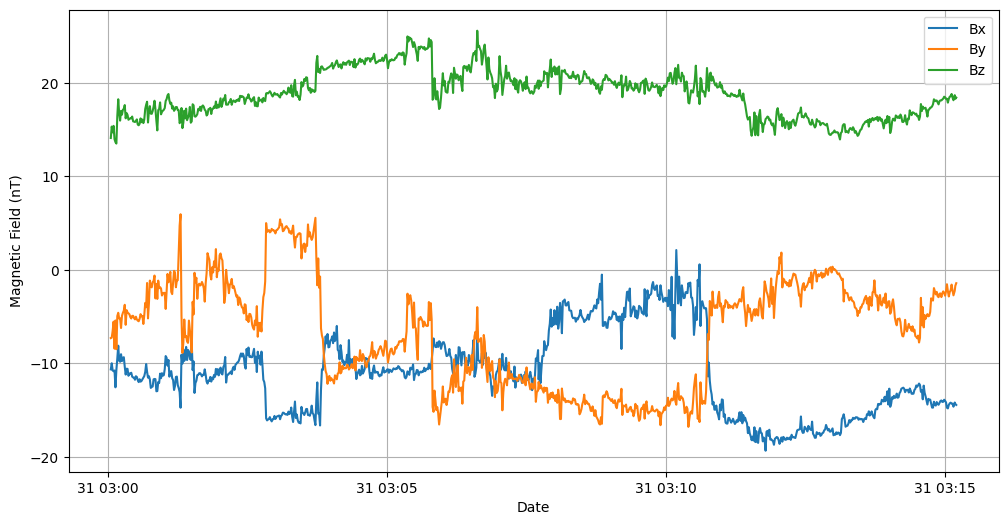

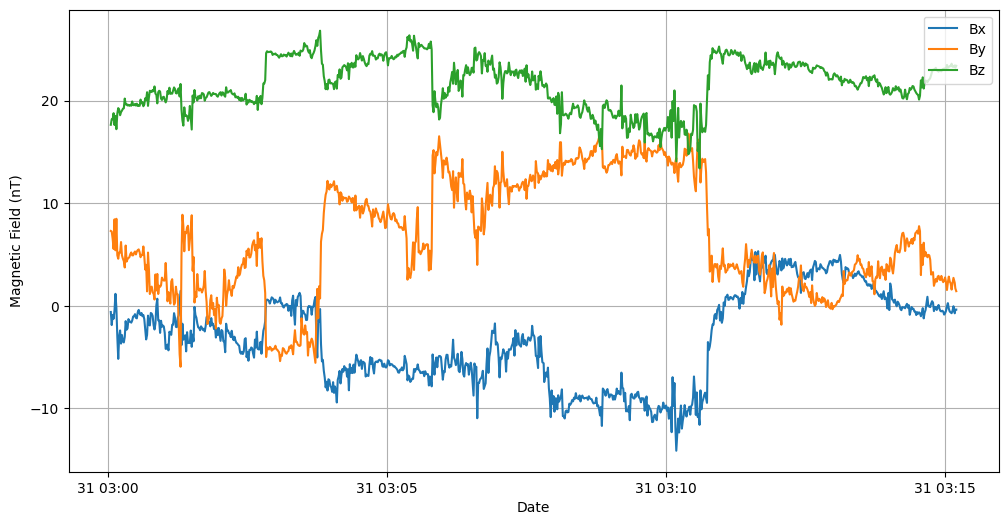

In [11]:
# Get and rotate JMAG data

jmag_cdf = pycdf.CDF('../DATA/jmag_echoed/2025/03/31/JUICE_LU_RPWI-PPTD-LWYRPW79710_20250331T030003_V01.cdf')

Bx = jmag_cdf['LWT79713'][...]
By = jmag_cdf['LWT79714'][...]
Bz = jmag_cdf['LWT79715'][...]
jmag_epoch = jmag_cdf['Epoch'][...]

plt.figure(figsize=(12, 6))
plt.plot(jmag_epoch, Bx, label='Bx')
plt.plot(jmag_epoch, By, label='By')
plt.plot(jmag_epoch, Bz, label='Bz')
plt.legend(loc = 'upper right')
plt.xlabel('Date')
plt.ylabel('Magnetic Field (nT)')
plt.grid()
plt.show()

# Rotation matrix to go from JMAG frame to JUICE frame
R = np.array([
    [-7.77145961*1e-1,  8.39299198*1e-17,   -6.29320391*1e-1],
    [-9.51729314*1e-17, -1.00000000*1e0,    -1.58371803*1e-17],
    [-6.29320391*1e-1,  4.75864657*1e-17,   7.77145961*1e-1]])

# Rotate the magnetic field vectors to the JUICE frame
Bx_rot = R[0,0]*Bx + R[0,1]*By + R[0,2]*Bz
By_rot = R[1,0]*Bx + R[1,1]*By + R[1,2]*Bz
Bz_rot = R[2,0]*Bx + R[2,1]*By + R[2,2]*Bz
Bx = Bx_rot
By = By_rot
Bz = Bz_rot

plt.figure(figsize=(12, 6))
plt.plot(jmag_epoch, Bx, label='Bx')
plt.plot(jmag_epoch, By, label='By')
plt.plot(jmag_epoch, Bz, label='Bz')
plt.legend(loc = 'upper right')
plt.xlabel('Date')
plt.ylabel('Magnetic Field (nT)')
plt.grid()
plt.show()

pycdf.CDF.close(jmag_cdf)

Delta time: 5.266309296413032 hours


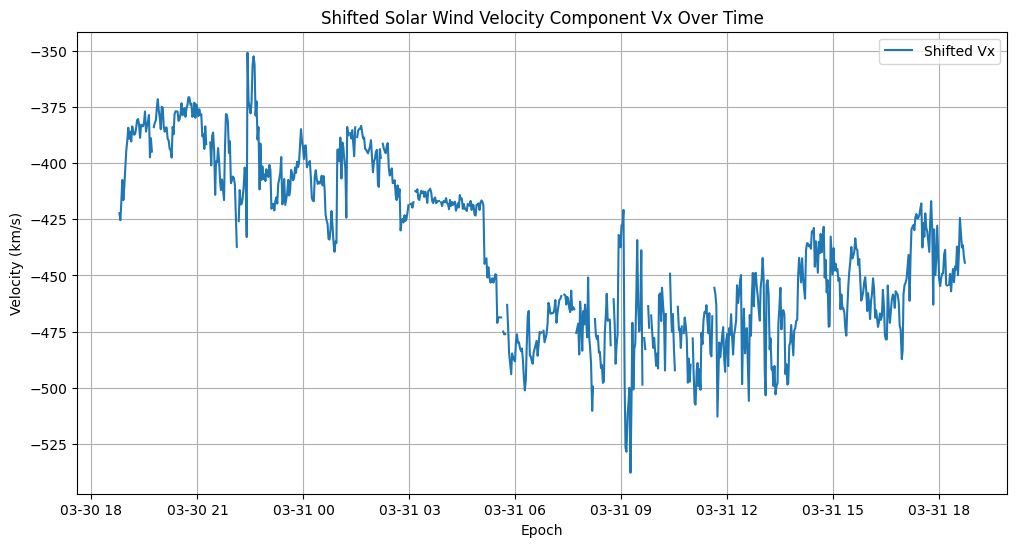

In [7]:
# Get and shift SW data

sw_cdf = pycdf.CDF("../DATA\wi_k0s_swe_20250331000326_20250331235905_cdaweb.cdf")

# Extracting solar wind velocity components and spacecraft position components
V_GSE = sw_cdf['V_GSE'][...]
WIND_pos_gse = sw_cdf['SC_pos_gse'][...]
Epoch = sw_cdf['Epoch'][...]

V_GSE[V_GSE < -1e5] = np.nan

# Load the necessary SPICE kernels
spice.furnsh("../SPICE/kernels/mk/juice_personnal.tm")

# Specify time (UTC)
et = spice.str2et("2025-03-31T00:00:00")

# Get Earth's position relative to the Sun in J2000 frame
pos_earth_j2000, light_time = spice.spkpos("EARTH", et, "J2000", "NONE", "SUN")

distance_earth_sun = np.linalg.norm(pos_earth_j2000)

WIND_pos_sun_centered_x = WIND_pos_gse[:, 0] - distance_earth_sun

WIND_distance_sun = np.sqrt(WIND_pos_sun_centered_x**2 + WIND_pos_gse[:, 1]**2 + WIND_pos_gse[:, 2]**2)

# Calculate the average of SC_distance_sun
avrg_WIND_distance_sun = np.nanmean(WIND_distance_sun)

pos_juice_j2000, light_time = spice.spkpos("JUICE", et, "J2000", "NONE", "SUN")
distance_juice_sun = np.linalg.norm(pos_juice_j2000)

delta_distance = avrg_WIND_distance_sun - distance_juice_sun
sw_speed = -np.nanmean(V_GSE[:, 0], axis=0)
delta_time = delta_distance / sw_speed
print(f"Delta time: {delta_time/(60*60)} hours")

# Shift the solar wind data to delta_time seconds earlier
SW_epoch = Epoch - dt.timedelta(seconds=delta_time)
plt.figure(figsize=(12, 6))
plt.plot(SW_epoch, V_GSE[:, 0], label='Shifted Vx')
plt.title('Shifted Solar Wind Velocity Component Vx Over Time')
plt.xlabel('Epoch')
plt.ylabel('Velocity (km/s)')
plt.legend()
plt.grid()
plt.show()

pycdf.CDF.close(sw_cdf)
spice.unload("SPICE/kernels/mk/juice_personnal.tm")

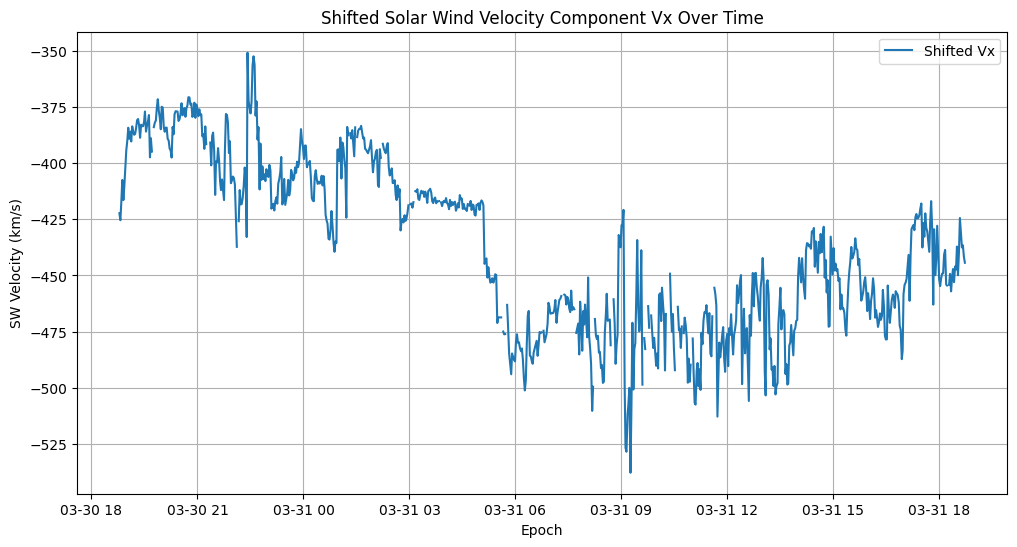

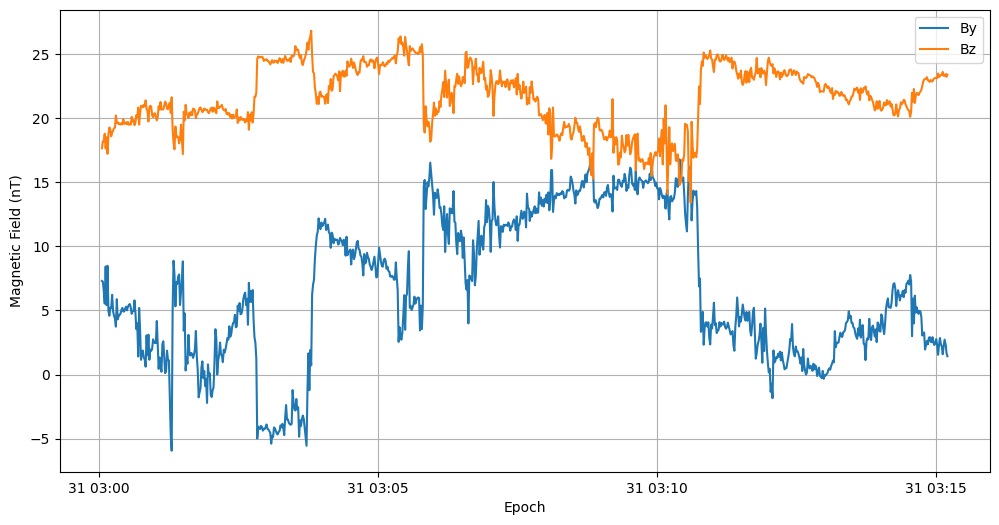

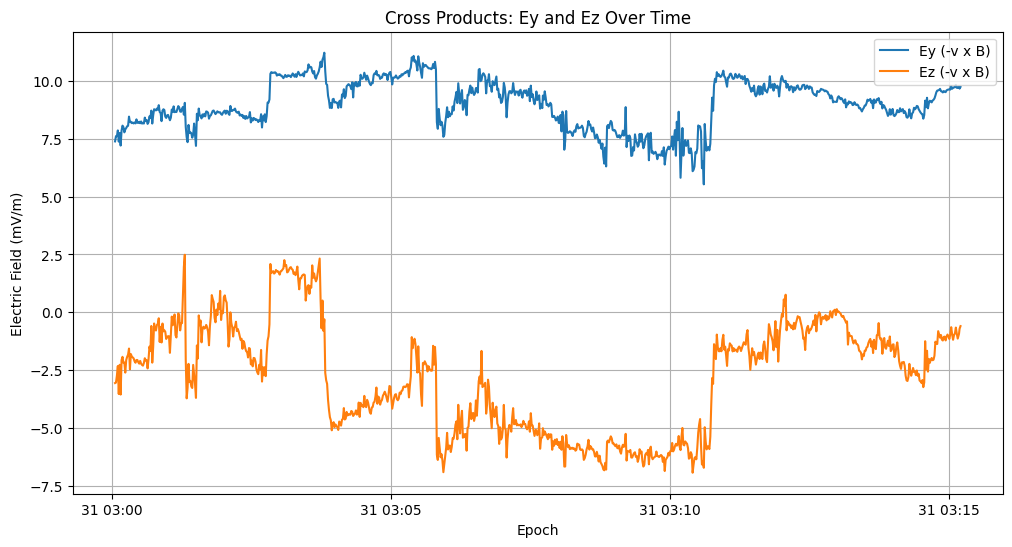

In [ ]:
# Calculate v cross B

# X axis for JUICE points away from HGA antenna, so AWAY from the Sun, so SW speed needs to be positive (just don't put the minus sign in the formula)

# Ensure SW_epoch and V_GSE are available
cross_products = np.zeros((len(jmag_epoch), 3))

for i in range(len(jmag_epoch)):
    # Calculate the absolute time difference
    time_diffs = np.abs(SW_epoch - jmag_epoch[i])
    # Sort the indices of time differences in ascending order
    sorted_indices = np.argsort(time_diffs)
    
    # Find the first non-nan Vx value
    sw_vx = np.nan
    for idx in sorted_indices:
        if not np.isnan(V_GSE[idx, 0]):
            sw_vx = V_GSE[idx, 0]
            break
    
    cross_products[i] = [0, float(-Bz[i] * sw_vx * 1e-6), float(By[i] * sw_vx * 1e-6)]

EyvCB = cross_products[:, 1]
EzvCB = cross_products[:, 2]

plt.figure(figsize=(12, 6))
plt.plot(SW_epoch, V_GSE[:, 0], label='Shifted Vx')
plt.title('Shifted Solar Wind Velocity Component Vx Over Time')
plt.xlabel('Epoch')
plt.ylabel('SW Velocity (km/s)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(jmag_epoch, By, label='By')
plt.plot(jmag_epoch, Bz, label='Bz')
plt.xlabel('Epoch')
plt.ylabel('Magnetic Field (nT)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(jmag_epoch, cross_products[:, 1]*1e3, label='Ey (-v x B)')
plt.plot(jmag_epoch, cross_products[:, 2]*1e3, label='Ez (-v x B)')
plt.title('Cross Products: Ey and Ez Over Time')
plt.xlabel('Epoch')
plt.ylabel('Electric Field (mV/m)')
plt.legend()
plt.grid()
plt.show()

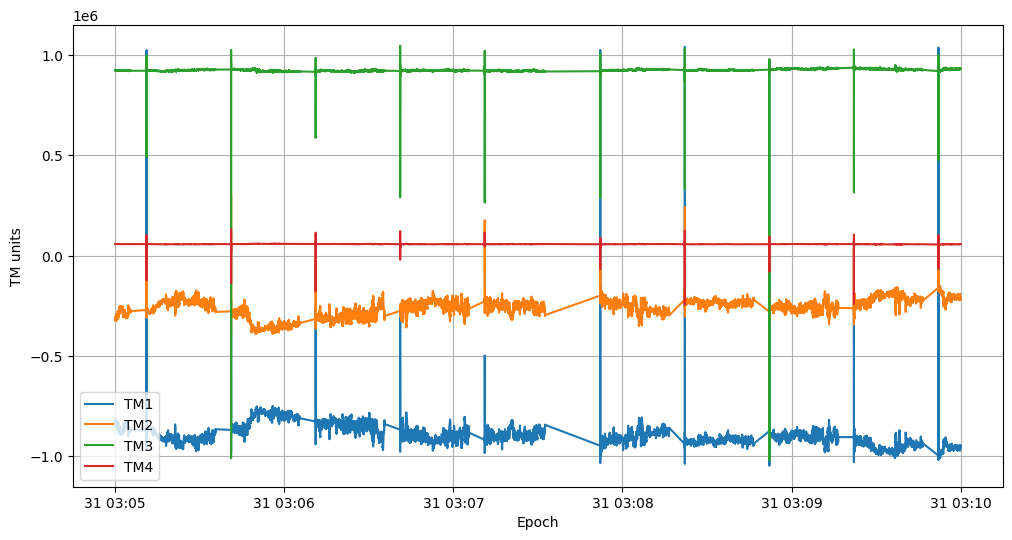

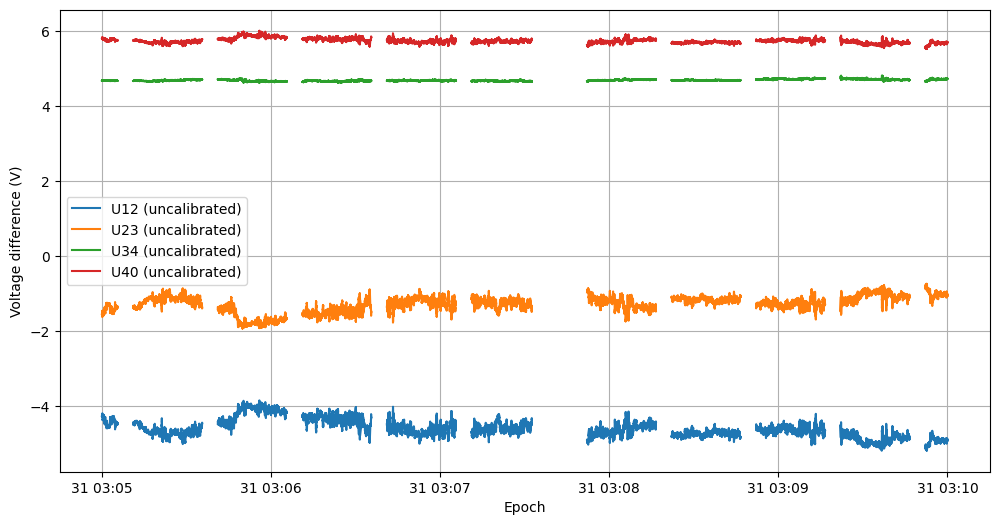

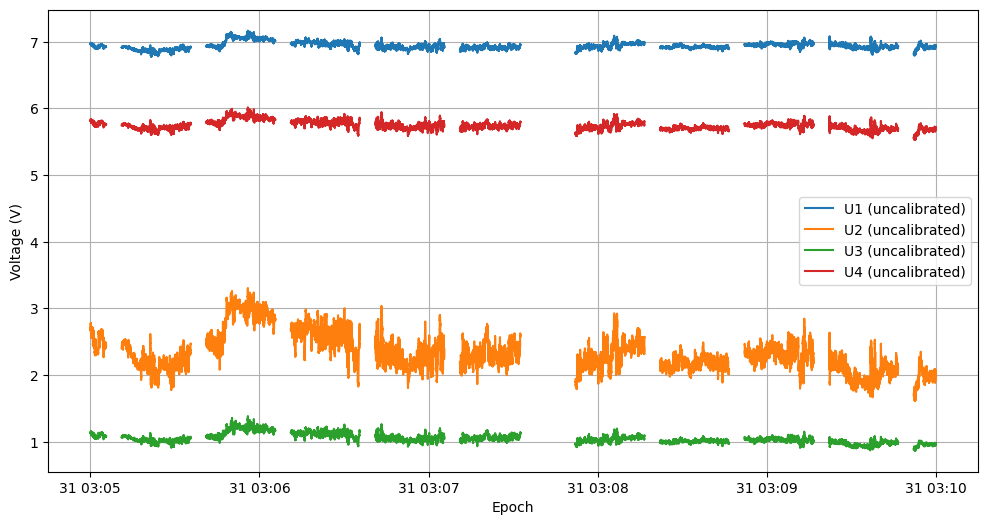

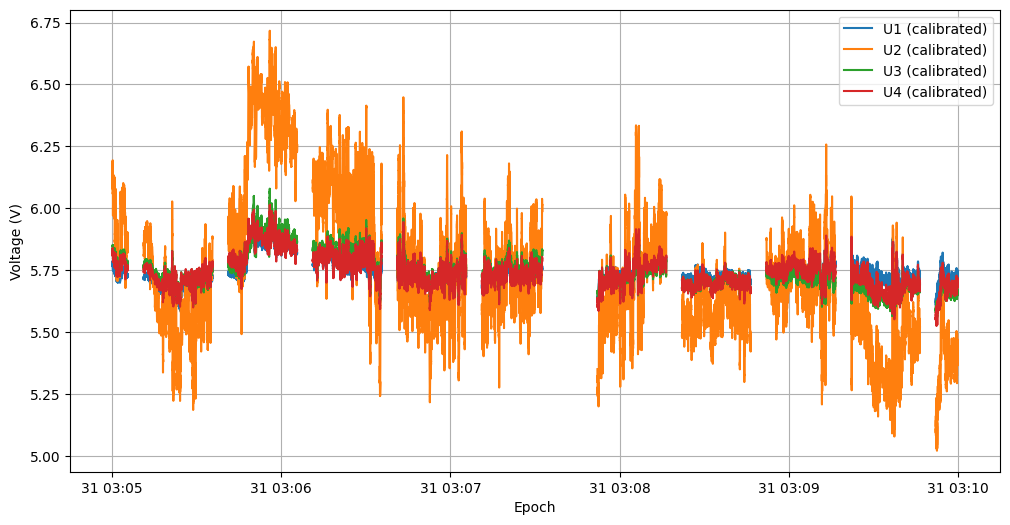

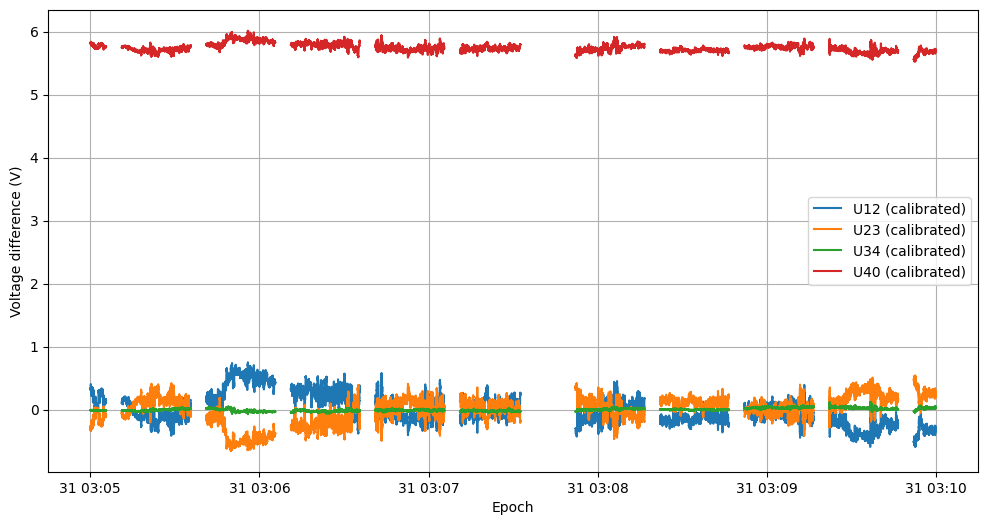

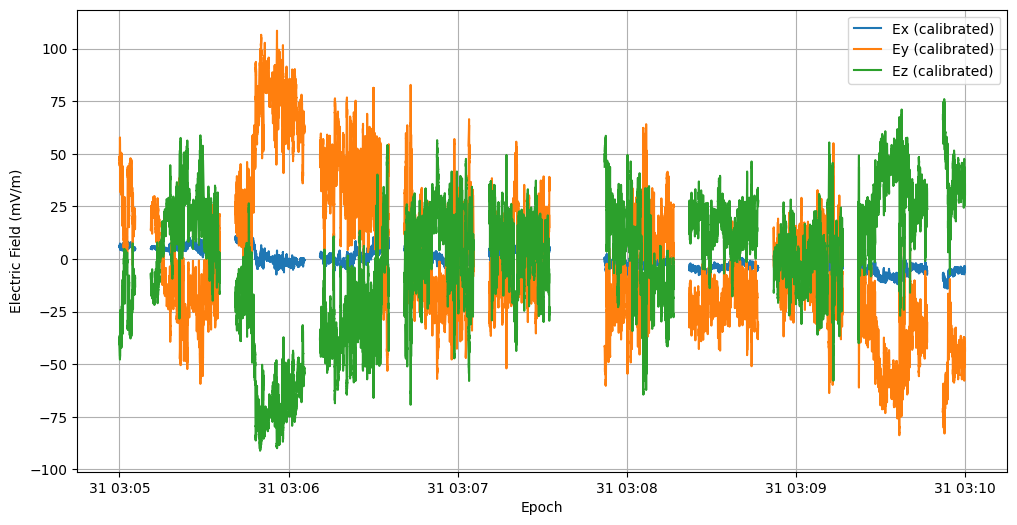

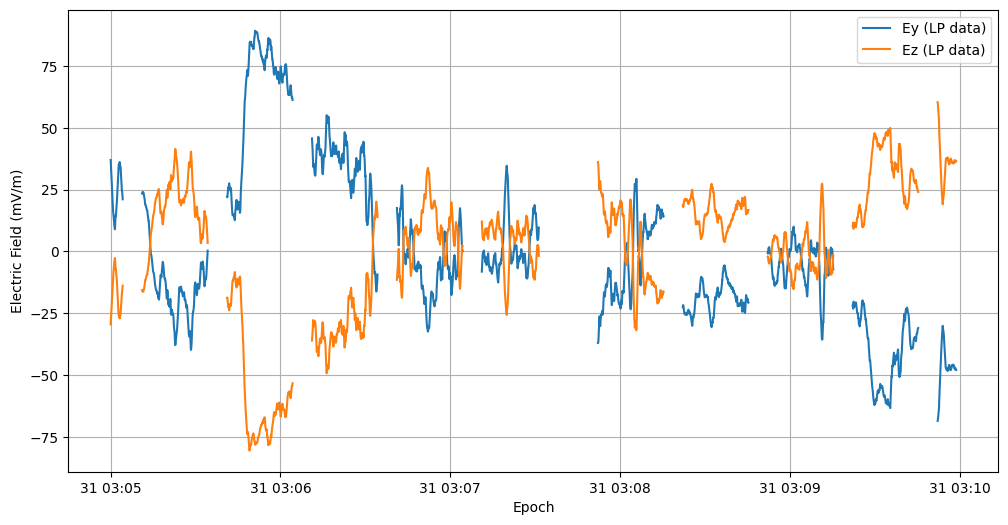

In [13]:
# Getting E field from raw LP data * coefficient

LP_cdf = pycdf.CDF('../DATA/JUICE_L1a_RPWI-LP-SID1_RICH_DE763_SNAP_20250331T030011_V02.cdf')

delta2volt = np.array([
    [-1.0, -1.0, -1.0, 1.0],
    [0.0, -1.0, -1.0, 1.0],
    [0.0, 0.0, -1.0, 1.0],
    [0.0, 0.0, 0.0, 1.0]])

volt2delta = np.array([
    [-1.0, 1.0, 0.0, 0.0],
    [0.0, -1.0, 1.0, 0.0],
    [0.0, 0.0, -1.0, 1.0],
    [0.0, 0.0, 0.0, 1.0]])

volt2E = np.array([
    [0.1852, 0.1923, 0.1917],
    [0.1320, -0.0112, -0.0322],
    [0.0, 0.1398, 0.0]])

TM2delta = np.array([[5.15*1e-6], [4.97*1e-6], [5.07*1e-6], [9.94*1e-5]])

nb_final_removed = 11000

lp_epoch = LP_cdf['Epoch'][...][:-nb_final_removed]

TM1 = LP_cdf['LP_DATA'][:, 0][:-nb_final_removed]
TM2 = LP_cdf['LP_DATA'][:, 1][:-nb_final_removed]
TM3 = LP_cdf['LP_DATA'][:, 2][:-nb_final_removed]
TM4 = LP_cdf['LP_DATA'][:, 3][:-nb_final_removed]

# Define the start and end dates for filtering
start_date = dt.datetime(2025, 3, 31, 3, 5, 0)
end_date = dt.datetime(2025, 3, 31, 3, 10, 0)

# Filter the TM lists and epoch list
filtered_indices = [i for i, t in enumerate(lp_epoch) if start_date <= t <= end_date]
lp_epoch = lp_epoch[filtered_indices]
TM1 = TM1[filtered_indices]
TM2 = TM2[filtered_indices]
TM3 = TM3[filtered_indices]
TM4 = TM4[filtered_indices]

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, TM1, label='TM1')
plt.plot(lp_epoch, TM2, label='TM2')
plt.plot(lp_epoch, TM3, label='TM3')
plt.plot(lp_epoch, TM4, label='TM4')
plt.xlabel('Epoch')
plt.ylabel('TM units')
plt.legend()
plt.grid()
plt.show()

U12 = TM1 * TM2delta[0, 0]
U23 = TM2 * TM2delta[1, 0]
U34 = TM3 * TM2delta[2, 0]
U40 = TM4 * TM2delta[3, 0]

U12 = filter_out_start_config_noise(U12, lp_epoch)
U23 = filter_out_start_config_noise(U23, lp_epoch)
U34 = filter_out_start_config_noise(U34, lp_epoch)
U40 = filter_out_start_config_noise(U40, lp_epoch)

plt.figure(figsize=(12, 6)) 
plt.plot(lp_epoch, U12, label='U12 (uncalibrated)')
plt.plot(lp_epoch, U23, label='U23 (uncalibrated)')
plt.plot(lp_epoch, U34, label='U34 (uncalibrated)')
plt.plot(lp_epoch, U40, label='U40 (uncalibrated)')
plt.xlabel('Epoch')
plt.ylabel('Voltage difference (V)')
plt.legend()
plt.grid()
plt.show()

U1, U2, U3, U4 = multiply_lists_by_44matrix(U12, U23, U34, U40, delta2volt)

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, U1, label='U1 (uncalibrated)')
plt.plot(lp_epoch, U2, label='U2 (uncalibrated)')
plt.plot(lp_epoch, U3, label='U3 (uncalibrated)')
plt.plot(lp_epoch, U4, label='U4 (uncalibrated)')
plt.xlabel('Epoch')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid()
plt.show()

mean_diff_U1 = np.nanmean(np.array(U4) - np.array(U1))
mean_diff_U2 = np.nanmean(np.array(U4) - np.array(U2))
mean_diff_U3 = np.nanmean(np.array(U4) - np.array(U3))

U1 = np.array([float(u) + float(mean_diff_U1) for u in U1])
U2 = np.array([float(u) + float(mean_diff_U2) for u in U2])
U3 = np.array([float(u) + float(mean_diff_U3) for u in U3])

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, U1, label='U1 (calibrated)')
plt.plot(lp_epoch, U2, label='U2 (calibrated)')
plt.plot(lp_epoch, U3, label='U3 (calibrated)')
plt.plot(lp_epoch, U4, label='U4 (calibrated)')
plt.xlabel('Epoch')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid()
plt.show()

U12, U23, U34, U40 = multiply_lists_by_44matrix(U1, U2, U3, U4, volt2delta)

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, U12, label='U12 (calibrated)')
plt.plot(lp_epoch, U23, label='U23 (calibrated)')
plt.plot(lp_epoch, U34, label='U34 (calibrated)')
plt.plot(lp_epoch, U40, label='U40 (calibrated)')
plt.xlabel('Epoch')
plt.ylabel('Voltage difference (V)')
plt.legend()
plt.grid()
plt.show()

Ex, Ey, Ez = multiply_lists_by_33matrix(U12, U23, U34, volt2E)

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, Ex*1e3, label='Ex (calibrated)')
plt.plot(lp_epoch, Ey*1e3, label='Ey (calibrated)')
plt.plot(lp_epoch, Ez*1e3, label='Ez (calibrated)')
plt.xlabel('Epoch')
plt.ylabel('Electric Field (mV/m)')
plt.legend()
plt.grid()
plt.show()

nb_points_avg = 1000

# Smooth E-field data using a 10-point rolling average
Ex_smooth = np.convolve(Ex, np.ones(nb_points_avg)/nb_points_avg, mode='valid')
Ey_smooth = np.convolve(Ey, np.ones(nb_points_avg)/nb_points_avg, mode='valid')
Ez_smooth = np.convolve(Ez, np.ones(nb_points_avg)/nb_points_avg, mode='valid')

# Adjust the epoch to match the smoothed data length
lp_epoch_smooth = lp_epoch[:len(Ex_smooth)]

plt.figure(figsize=(12, 6))
#plt.plot(lp_epoch_smooth, Ex_smooth*1e3, label='Ex (smoothed)')
plt.plot(lp_epoch_smooth, Ey_smooth*1e3, label='Ey (LP data)')
plt.plot(lp_epoch_smooth, Ez_smooth*1e3, label='Ez (LP data)')
plt.xlabel('Epoch')
plt.ylabel('Electric Field (mV/m)')
plt.legend()
plt.grid()
plt.show()

pycdf.CDF.close(LP_cdf)

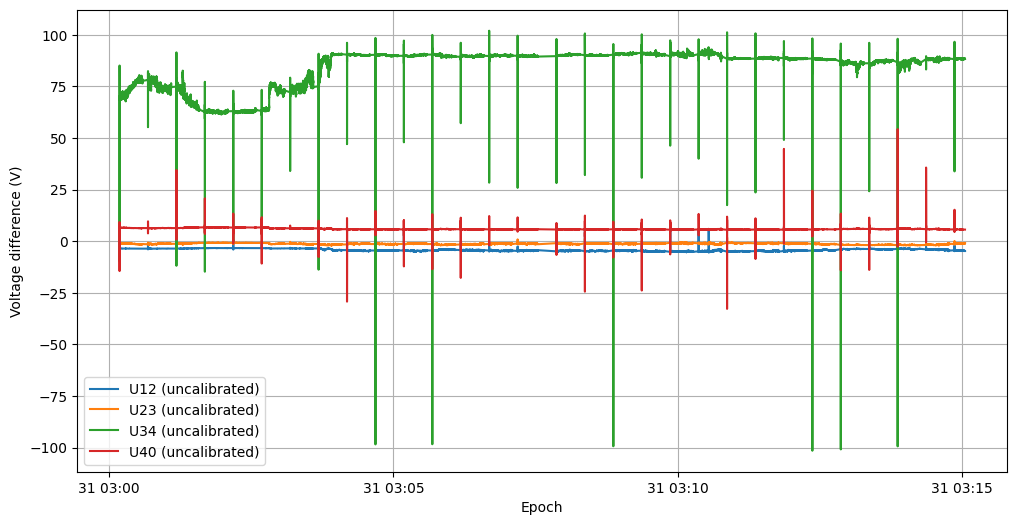

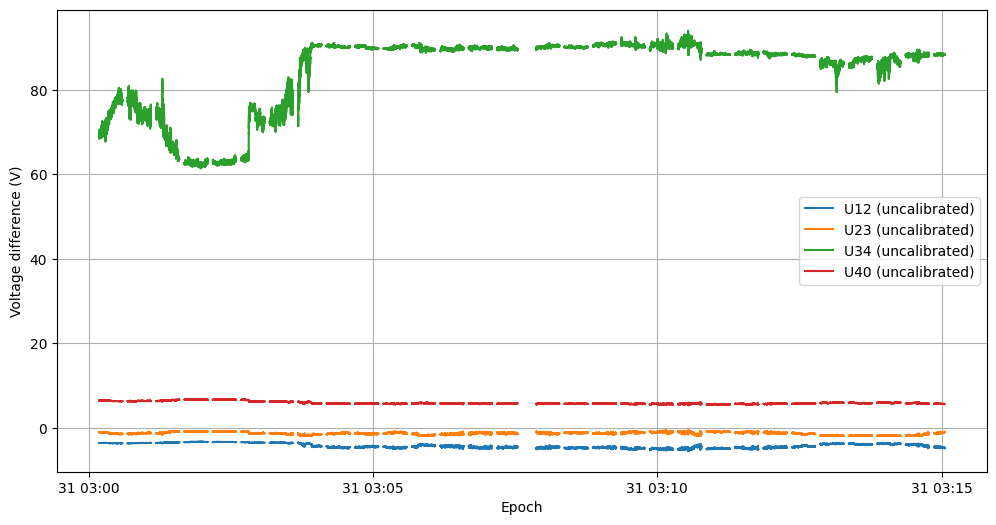

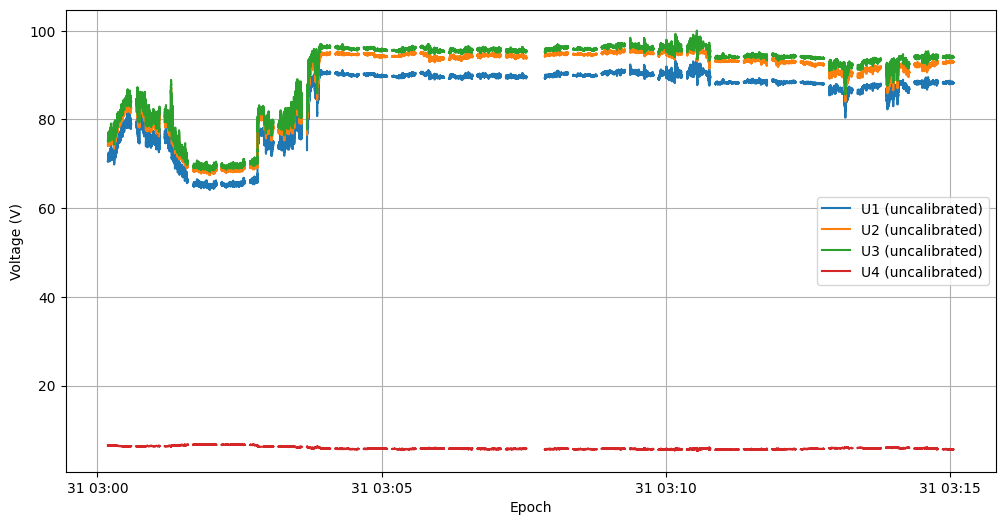

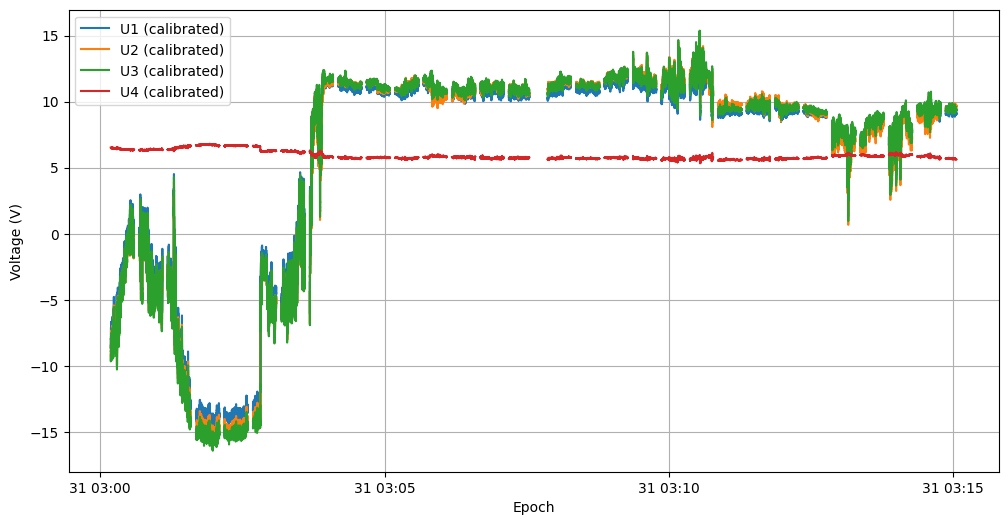

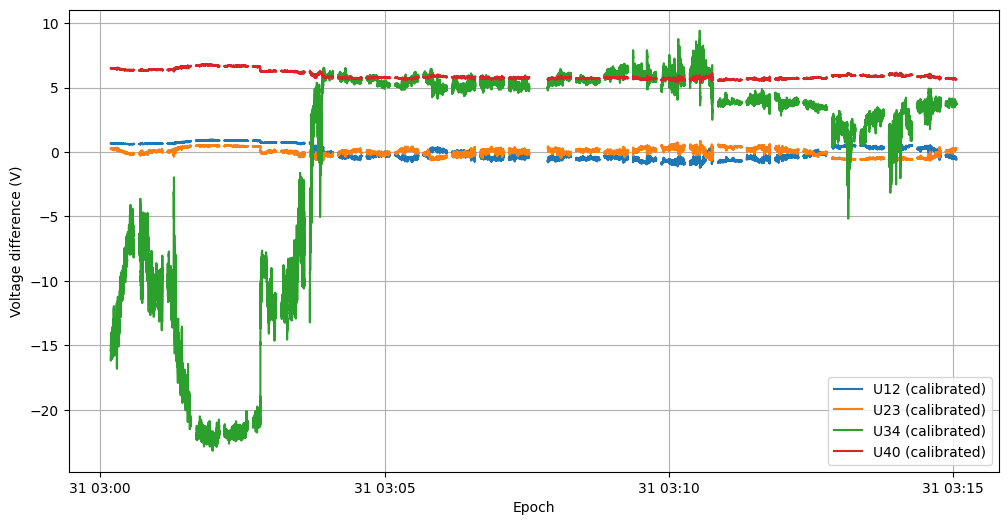

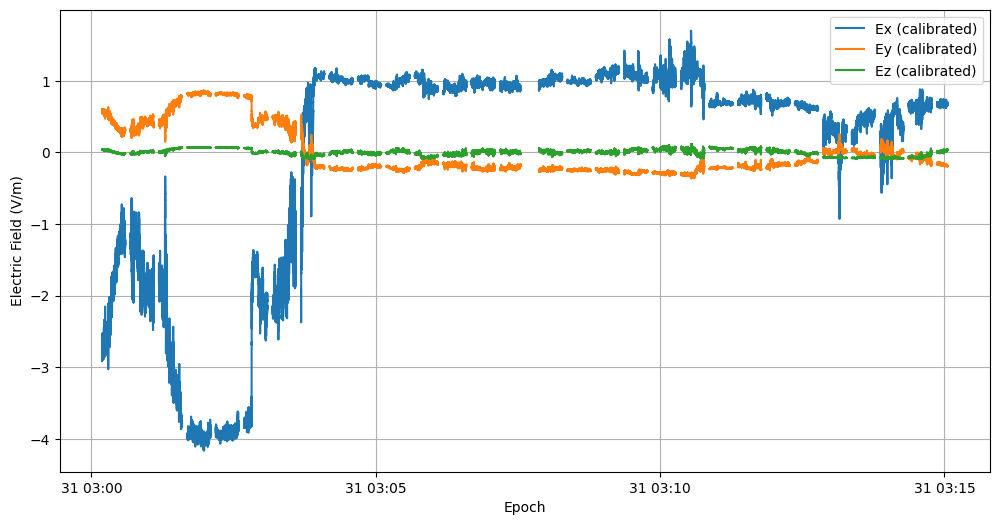

In [ ]:
# Getting E field from ENG LP data

lp_cdf = pycdf.CDF('../DATA/JUICE_L1a_RPWI-LP-SID1_RICH_DE763_SNAP_20250331T030011_V02.cdf')

nb_final_removed = 11000

lp_epoch = lp_cdf['Epoch'][...][:-nb_final_removed]

U12 = lp_cdf['LP_DATA_ENG'][:, 0][:-nb_final_removed]
U23 = lp_cdf['LP_DATA_ENG'][:, 1][:-nb_final_removed]
U34 = lp_cdf['LP_DATA_ENG'][:, 2][:-nb_final_removed]
U40 = lp_cdf['LP_DATA_ENG'][:, 3][:-nb_final_removed]

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, U12, label='U12 (uncalibrated)')
plt.plot(lp_epoch, U23, label='U23 (uncalibrated)')
plt.plot(lp_epoch, U34, label='U34 (uncalibrated)')
plt.plot(lp_epoch, U40, label='U40 (uncalibrated)')
plt.xlabel('Epoch')
plt.ylabel('Voltage difference (V)')
plt.legend()
plt.grid()
plt.show()

U12 = filter_out_start_config_noise(U12, lp_epoch, deviate_from_average=2)
U23 = filter_out_start_config_noise(U23, lp_epoch, deviate_from_average=20)
U34 = filter_out_start_config_noise(U34, lp_epoch, deviate_from_average=30)
U40 = filter_out_start_config_noise(U40, lp_epoch, deviate_from_average=20)

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, U12, label='U12 (uncalibrated)')
plt.plot(lp_epoch, U23, label='U23 (uncalibrated)')
plt.plot(lp_epoch, U34, label='U34 (uncalibrated)')
plt.plot(lp_epoch, U40, label='U40 (uncalibrated)')
plt.xlabel('Epoch')
plt.ylabel('Voltage difference (V)')
plt.legend()
plt.grid()
plt.show()

U1, U2, U3, U4 = multiply_lists_by_44matrix(U12, U23, U34, U40, delta2volt)

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, U1, label='U1 (uncalibrated)')
plt.plot(lp_epoch, U2, label='U2 (uncalibrated)')
plt.plot(lp_epoch, U3, label='U3 (uncalibrated)')
plt.plot(lp_epoch, U4, label='U4 (uncalibrated)')
plt.xlabel('Epoch')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid()
plt.show()

mean_diff_U1 = np.nanmean(np.array(U4) - np.array(U1))
mean_diff_U2 = np.nanmean(np.array(U4) - np.array(U2))
mean_diff_U3 = np.nanmean(np.array(U4) - np.array(U3))

U1 = np.array([float(u) + float(mean_diff_U1) for u in U1])
U2 = np.array([float(u) + float(mean_diff_U2) for u in U2])
U3 = np.array([float(u) + float(mean_diff_U3) for u in U3])

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, U1, label='U1 (calibrated)')
plt.plot(lp_epoch, U2, label='U2 (calibrated)')
plt.plot(lp_epoch, U3, label='U3 (calibrated)')
plt.plot(lp_epoch, U4, label='U4 (calibrated)')
plt.xlabel('Epoch')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid()
plt.show()

U12, U23, U34, U40 = multiply_lists_by_44matrix(U1, U2, U3, U4, volt2delta)

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, U12, label='U12 (calibrated)')
plt.plot(lp_epoch, U23, label='U23 (calibrated)')
plt.plot(lp_epoch, U34, label='U34 (calibrated)')
plt.plot(lp_epoch, U40, label='U40 (calibrated)')
plt.xlabel('Epoch')
plt.ylabel('Voltage difference (V)')
plt.legend()
plt.grid()
plt.show()

Ex, Ey, Ez = multiply_lists_by_33matrix(U12, U23, U34, volt2E)

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, Ex, label='Ex (calibrated)')
plt.plot(lp_epoch, Ey, label='Ey (calibrated)')
plt.plot(lp_epoch, Ez, label='Ez (calibrated)')
plt.xlabel('Epoch')
plt.ylabel('Electric Field (V/m)')
plt.legend()
plt.grid()
plt.show()

pycdf.CDF.close(lp_cdf)

Ey error: 0.07819179278922761
Ez error: 0.035076277703396296


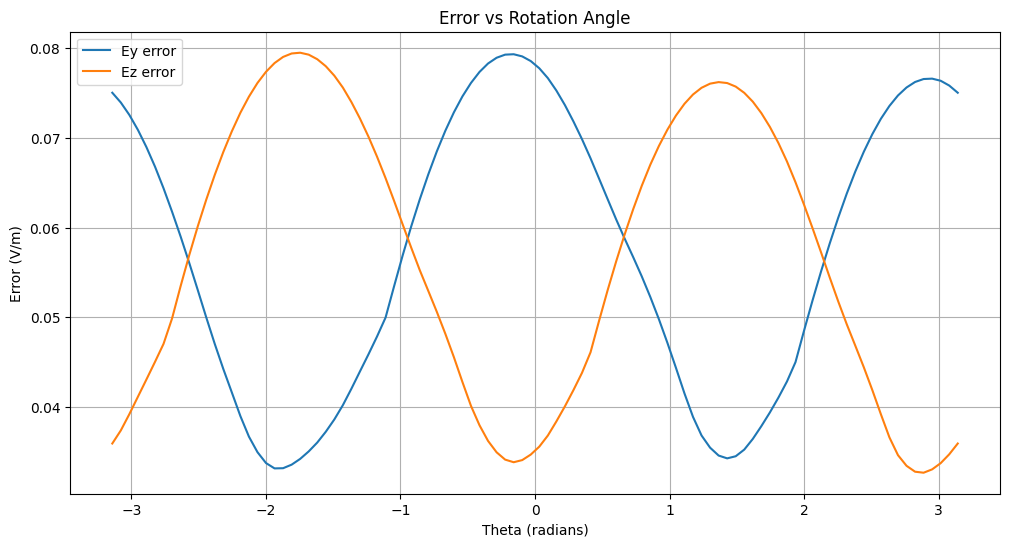

In [167]:
# Seeing which rotation limits the difference between the E fields

def rotate_fields(Ey, Ez, theta):
    Ey_rot = Ey * np.cos(theta) - Ez * np.sin(theta)
    Ez_rot = Ey * np.sin(theta) + Ez * np.cos(theta)
    return Ey_rot, Ez_rot

EyLP = Ey
EzLP =-Ez

# EyvCB = EyvCB
# EzvCB = EzvCB

# Convert all datetime arrays into seconds since March 31st, 2025 at 00:00
reference_time = dt.datetime(2025, 3, 31, 0, 0)

jmag_cdf = pycdf.CDF('../DATA/jmag_echoed/2025/03/31/JUICE_LU_RPWI-PPTD-LWYRPW79710_20250331T030003_V01.cdf')
lp_cdf = pycdf.CDF('../DATA/JUICE_L1a_RPWI-LP-SID1_RICH_DE763_SNAP_20250331T030011_V02.cdf')
jmag_epoch = jmag_cdf['Epoch'][...]
nb_final_removed = 11000
lp_epoch = lp_cdf['Epoch'][...][:-nb_final_removed]

# Convert jmag_epoch and lp_epoch to seconds
jmag_epoch = np.array([(t - reference_time).total_seconds() for t in jmag_epoch])
lp_epoch = np.array([(t - reference_time).total_seconds() for t in lp_epoch])

EyLP = np.interp(jmag_epoch, lp_epoch, EyLP)
EzLP = np.interp(jmag_epoch, lp_epoch, EzLP)

y_error = np.nanmean(np.abs(EyvCB - EyLP))
z_error = np.nanmean(np.abs(EzvCB - EzLP))

print(f"Ey error: {y_error}")
print(f"Ez error: {z_error}")

thetas = np.linspace(-np.pi, np.pi, 100)
y_errors = []
z_errors = []

for theta in thetas:
    Ey_rot, Ez_rot = rotate_fields(EyLP, EzLP, theta)
    y_error = np.nanmean(np.abs(EyvCB - Ey_rot))
    z_error = np.nanmean(np.abs(EzvCB - Ez_rot))
    y_errors.append(y_error)
    z_errors.append(z_error)

plt.figure(figsize=(12, 6))
plt.plot(thetas, y_errors, label='Ey error')
plt.plot(thetas, z_errors, label='Ez error')
plt.xlabel('Theta (radians)')
plt.ylabel('Error (V/m)')
plt.legend()
plt.title('Error vs Rotation Angle')
plt.grid()
plt.show()

pycdf.CDF.close(lp_cdf)
pycdf.CDF.close(jmag_cdf)

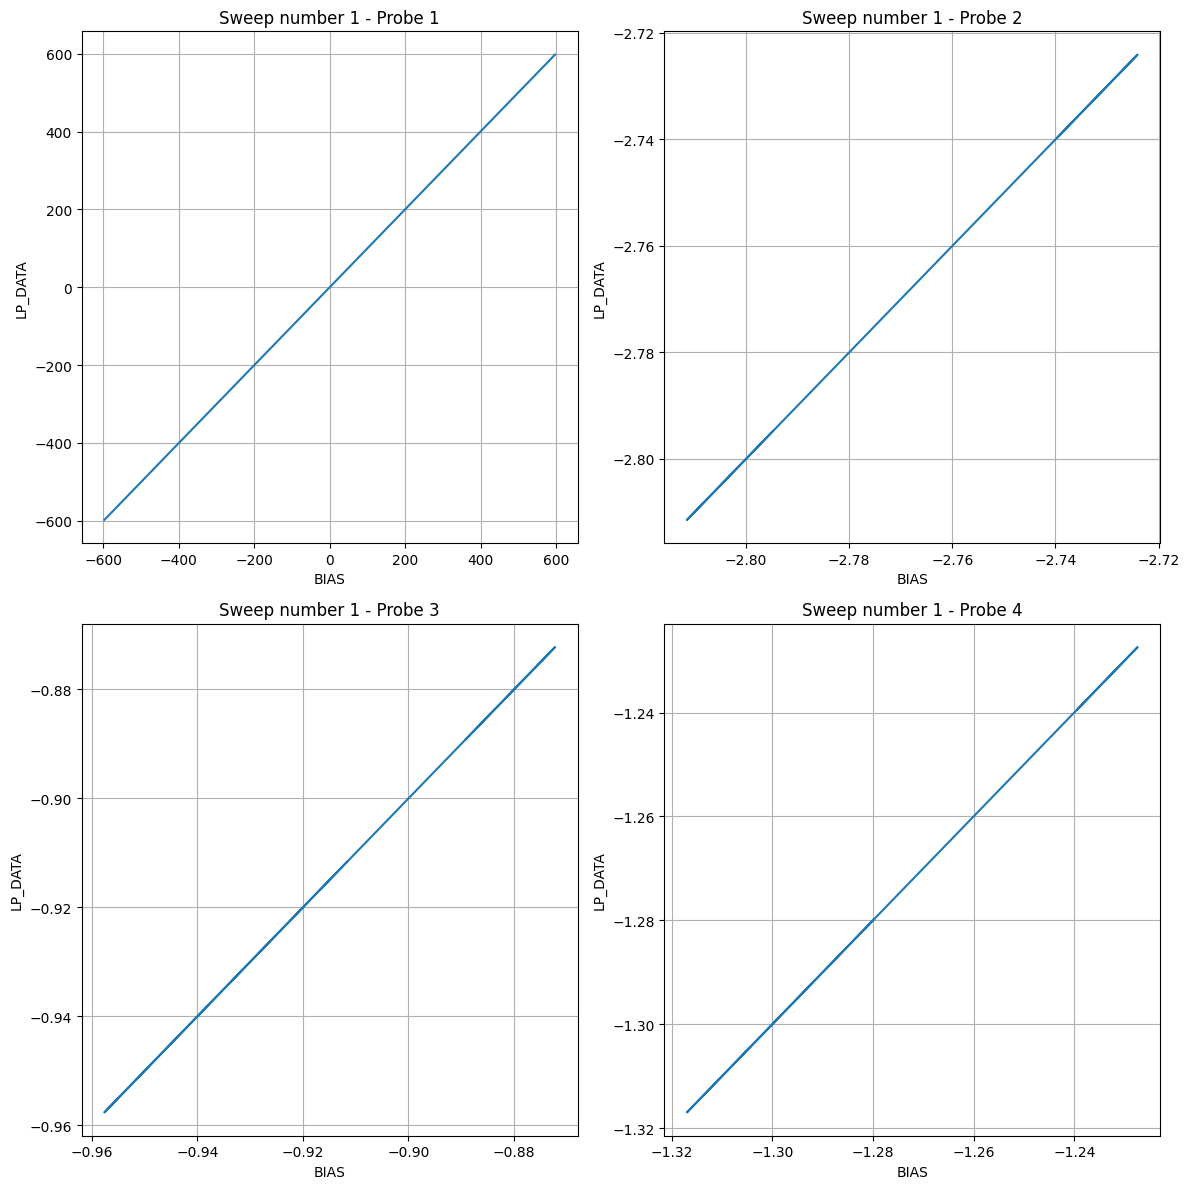

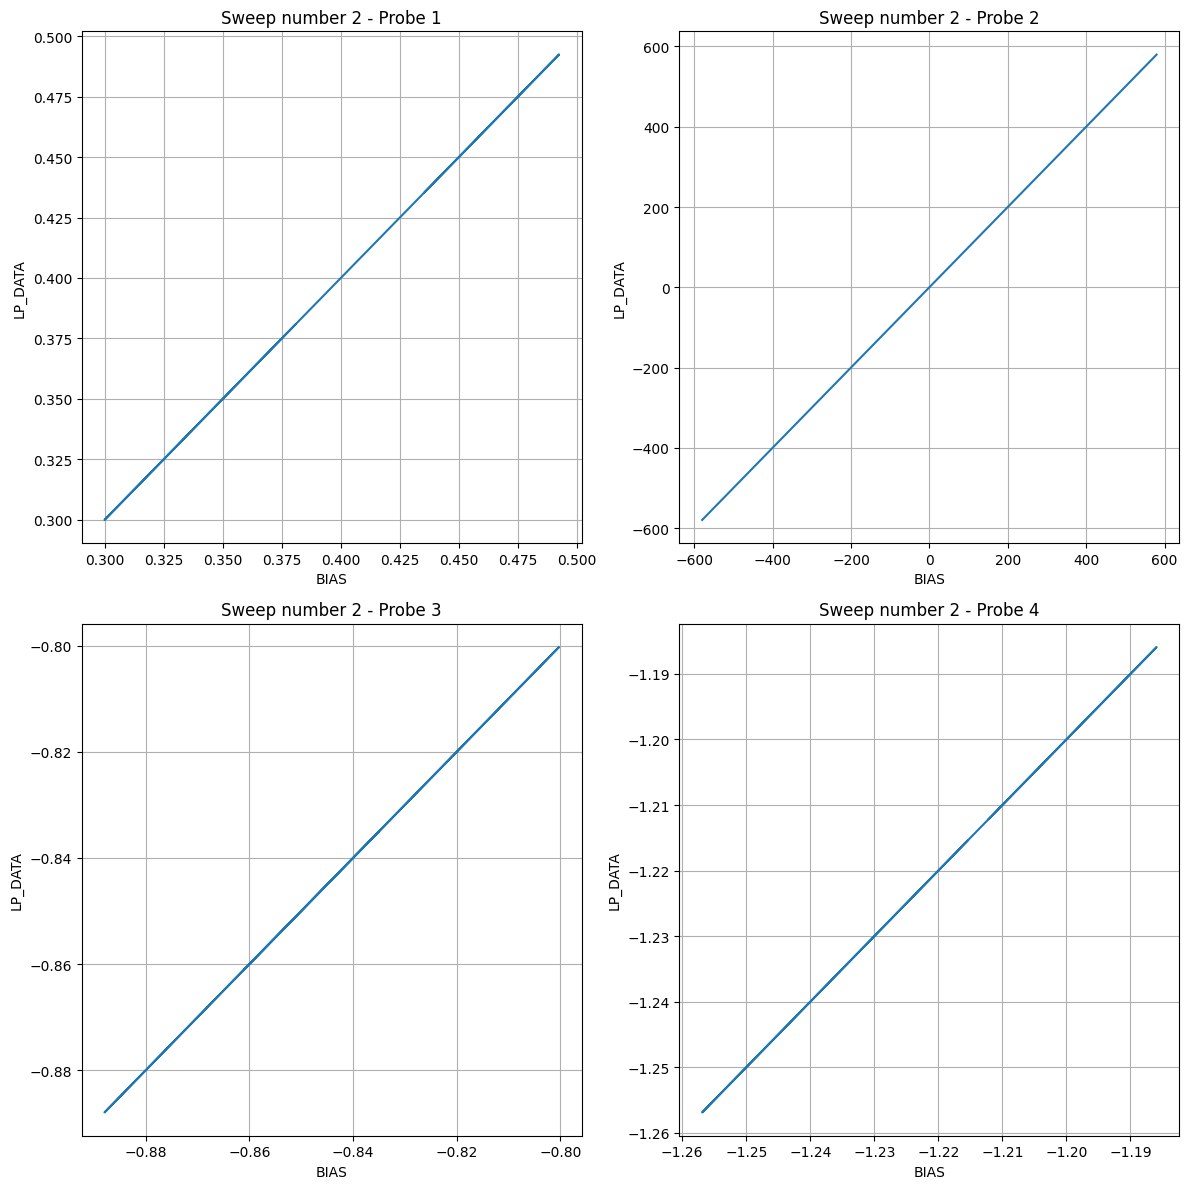

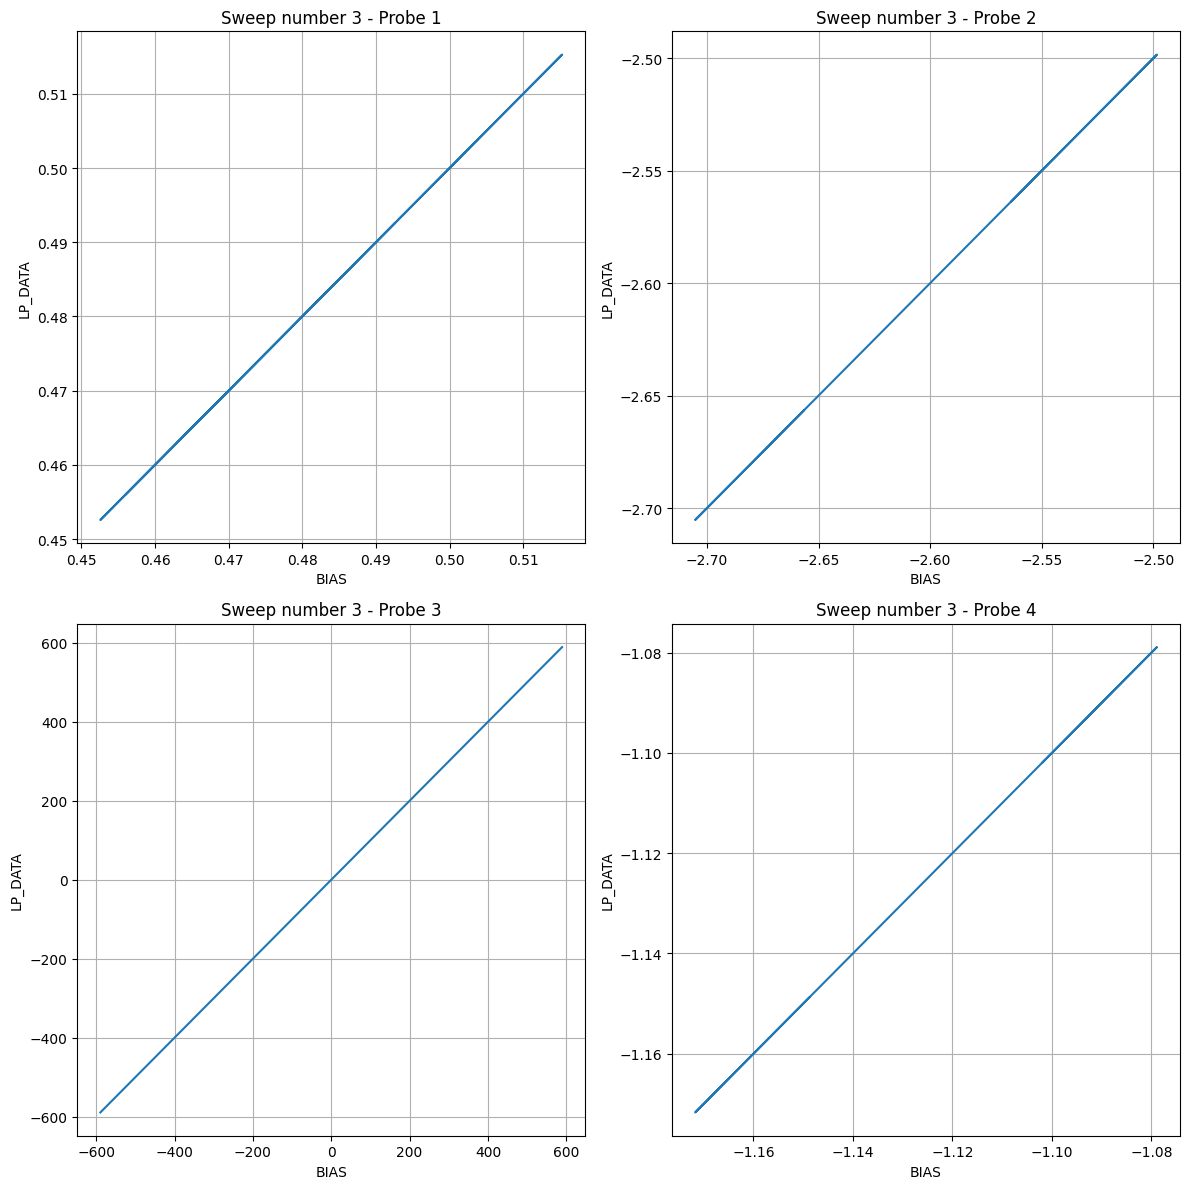

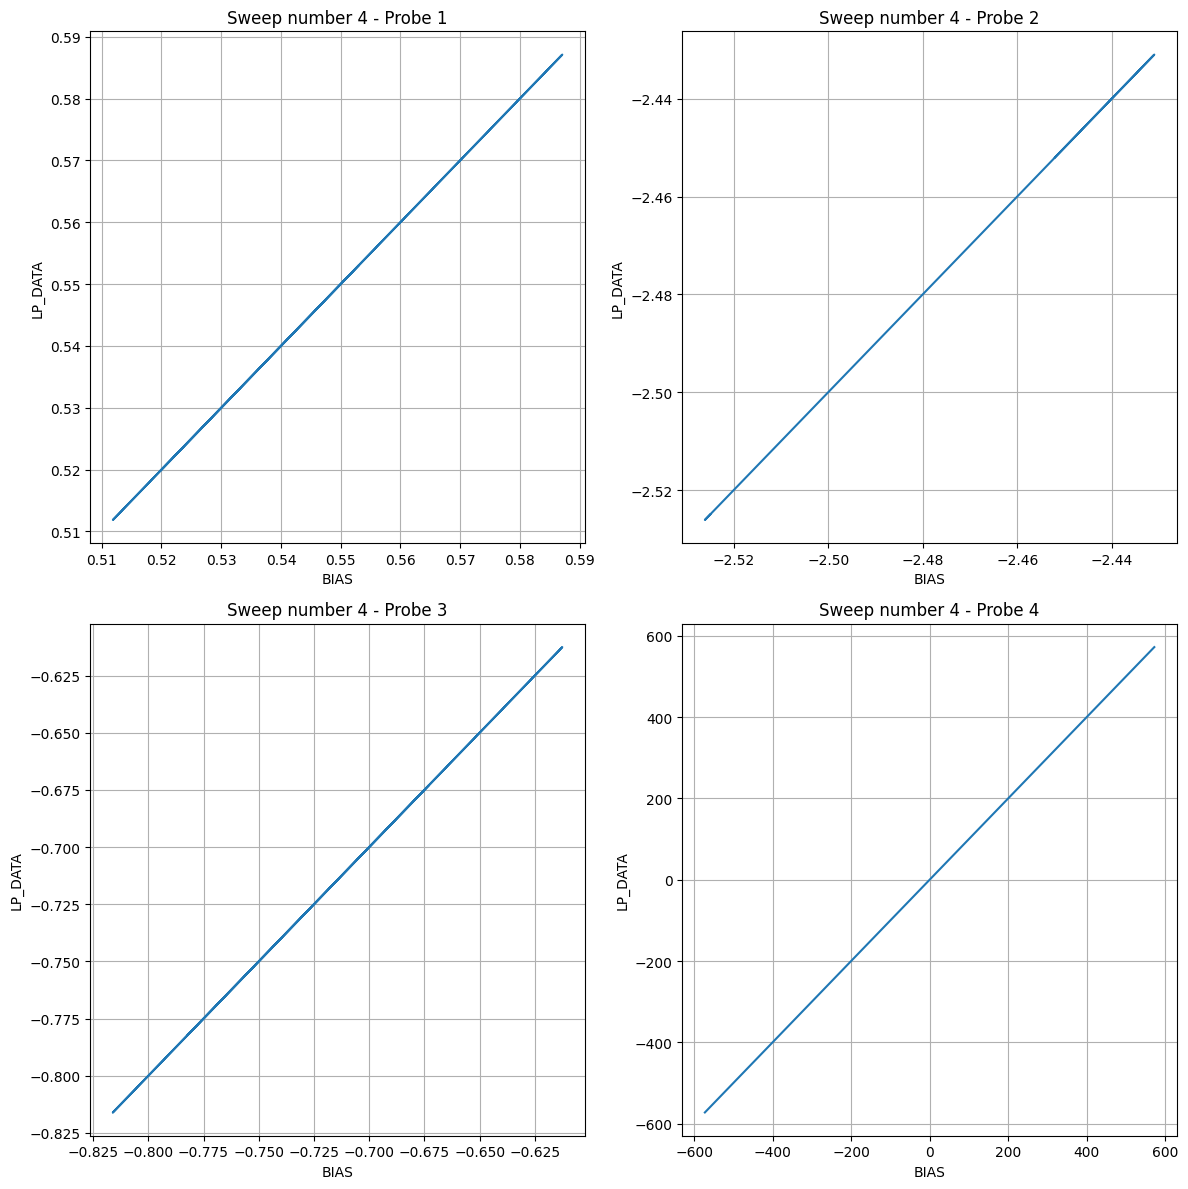

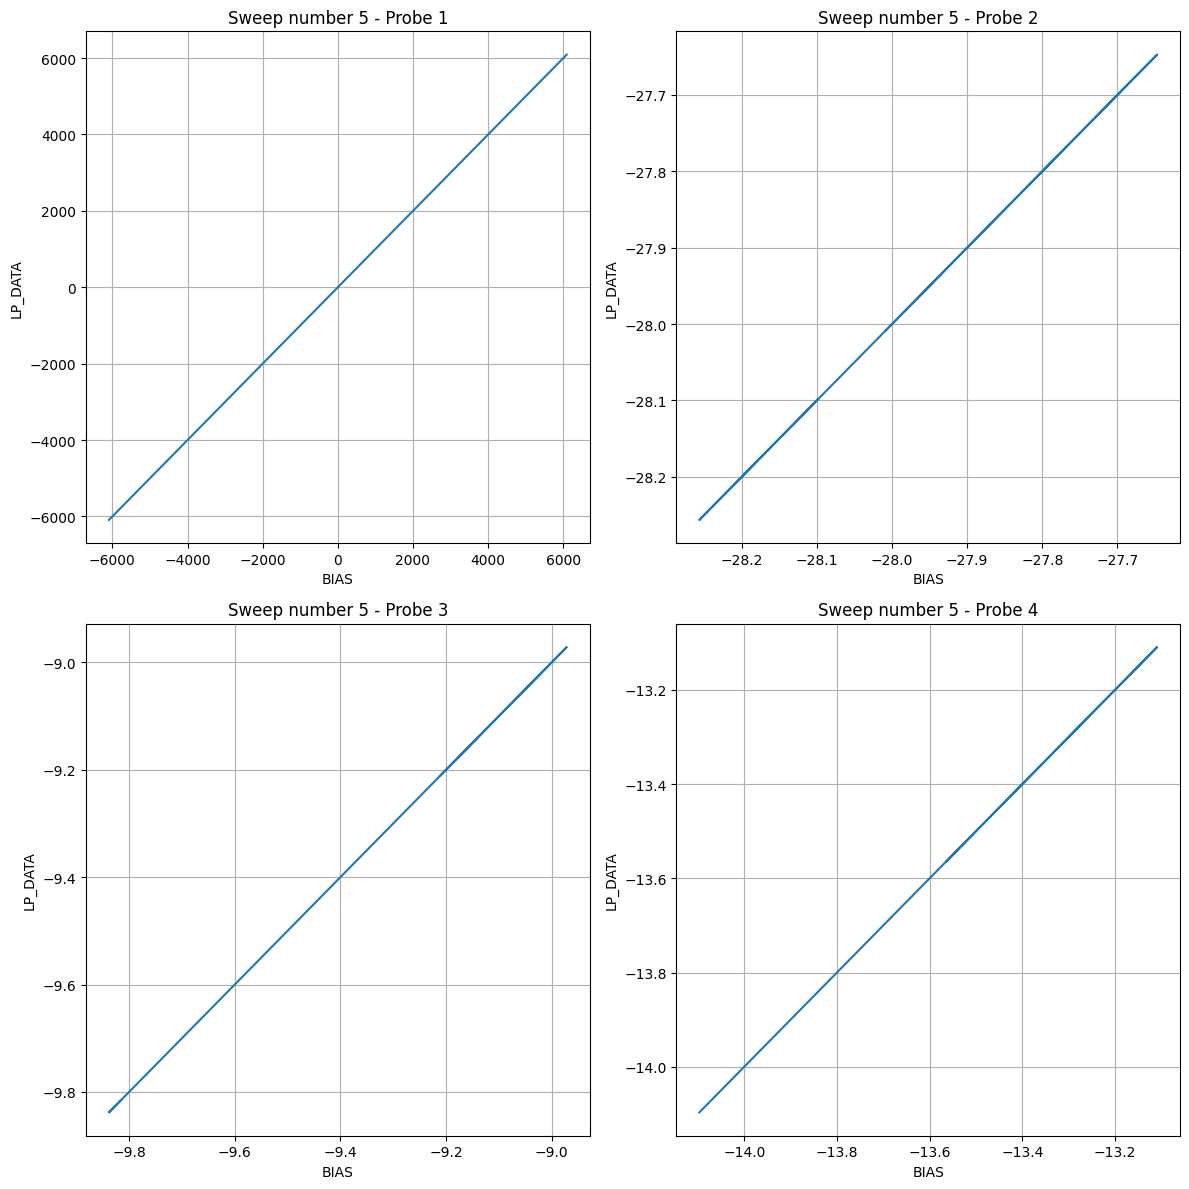

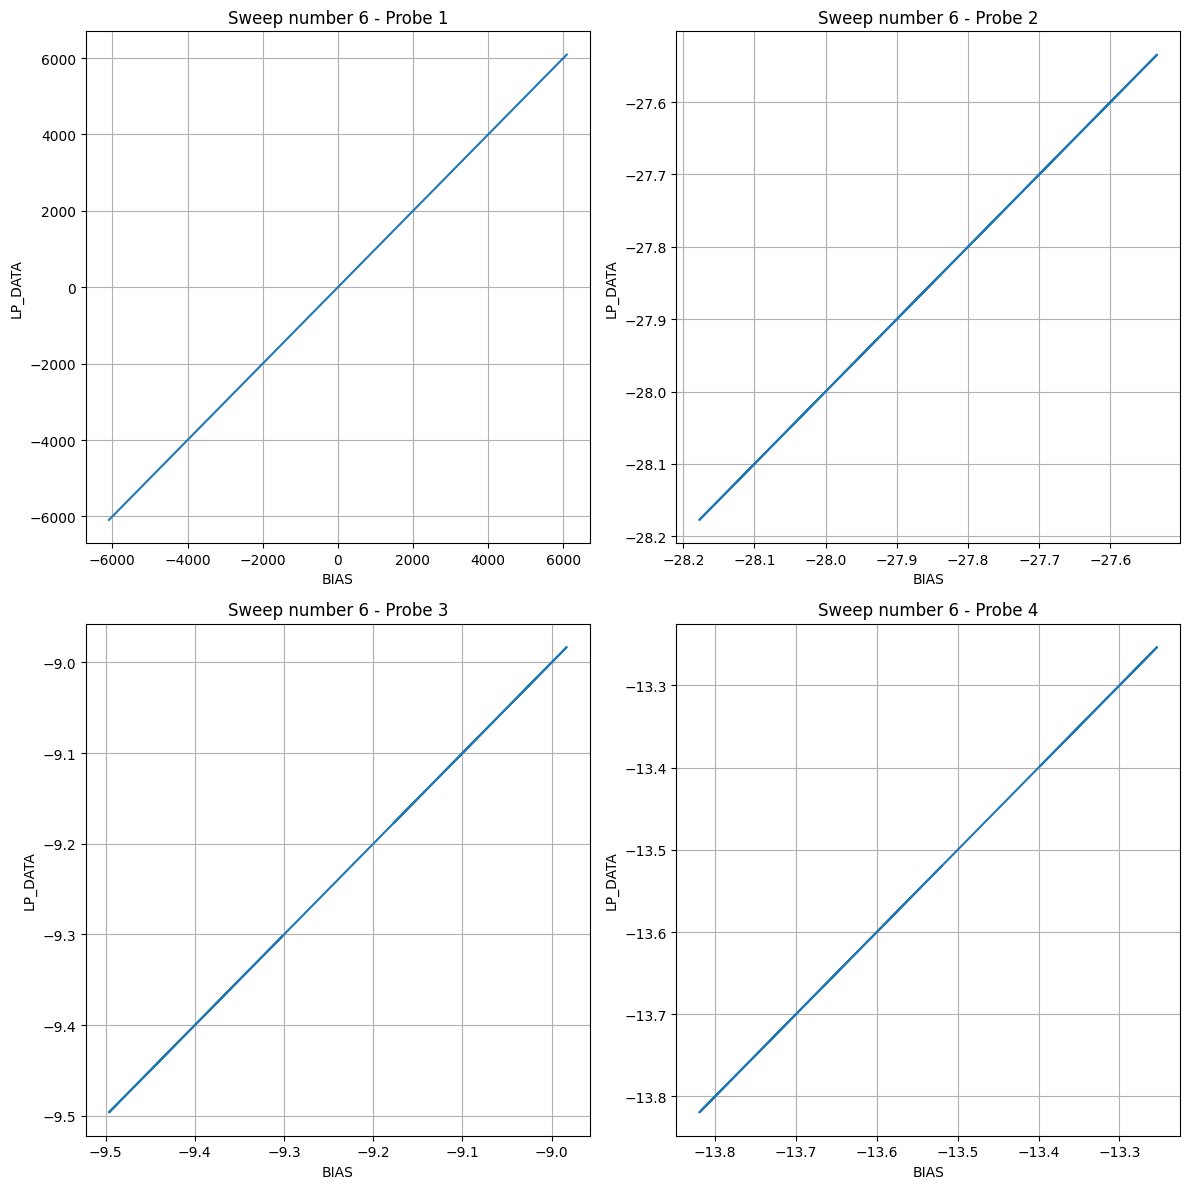

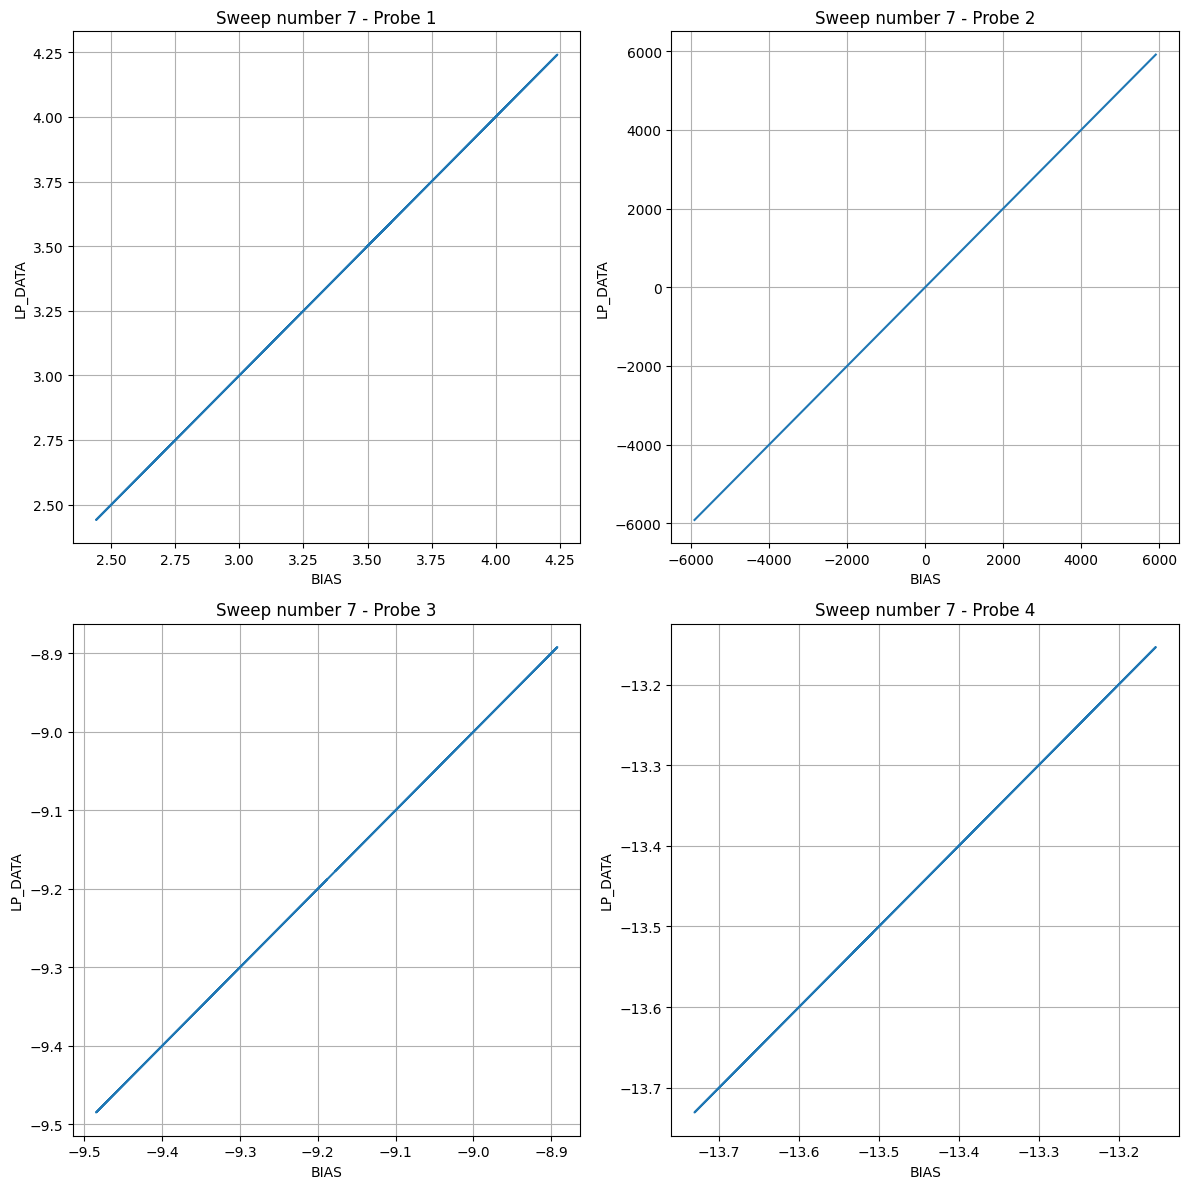

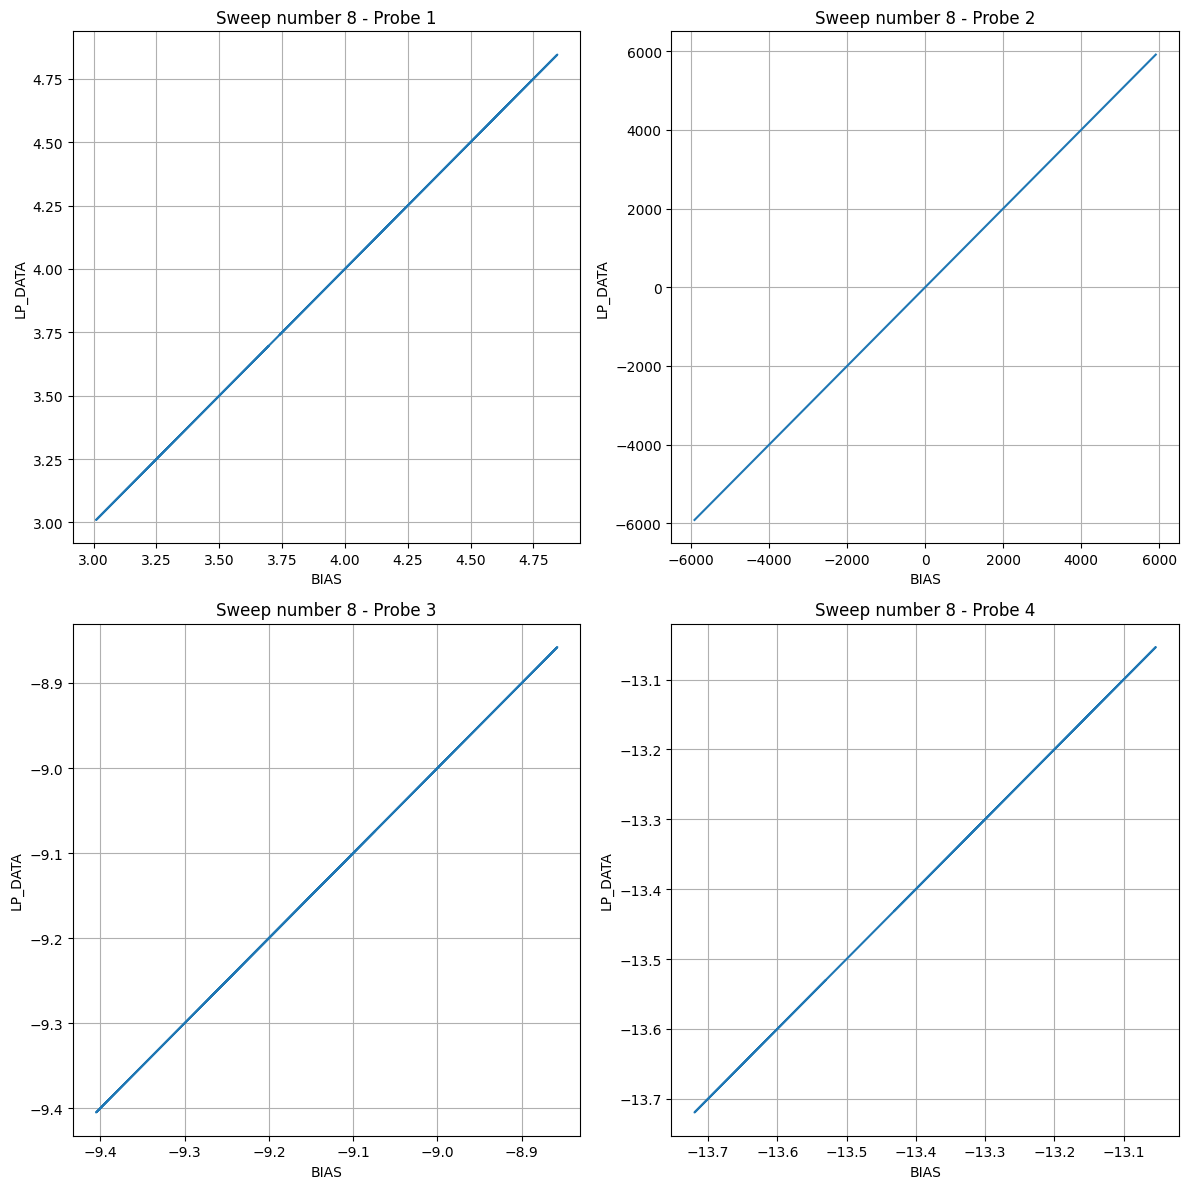

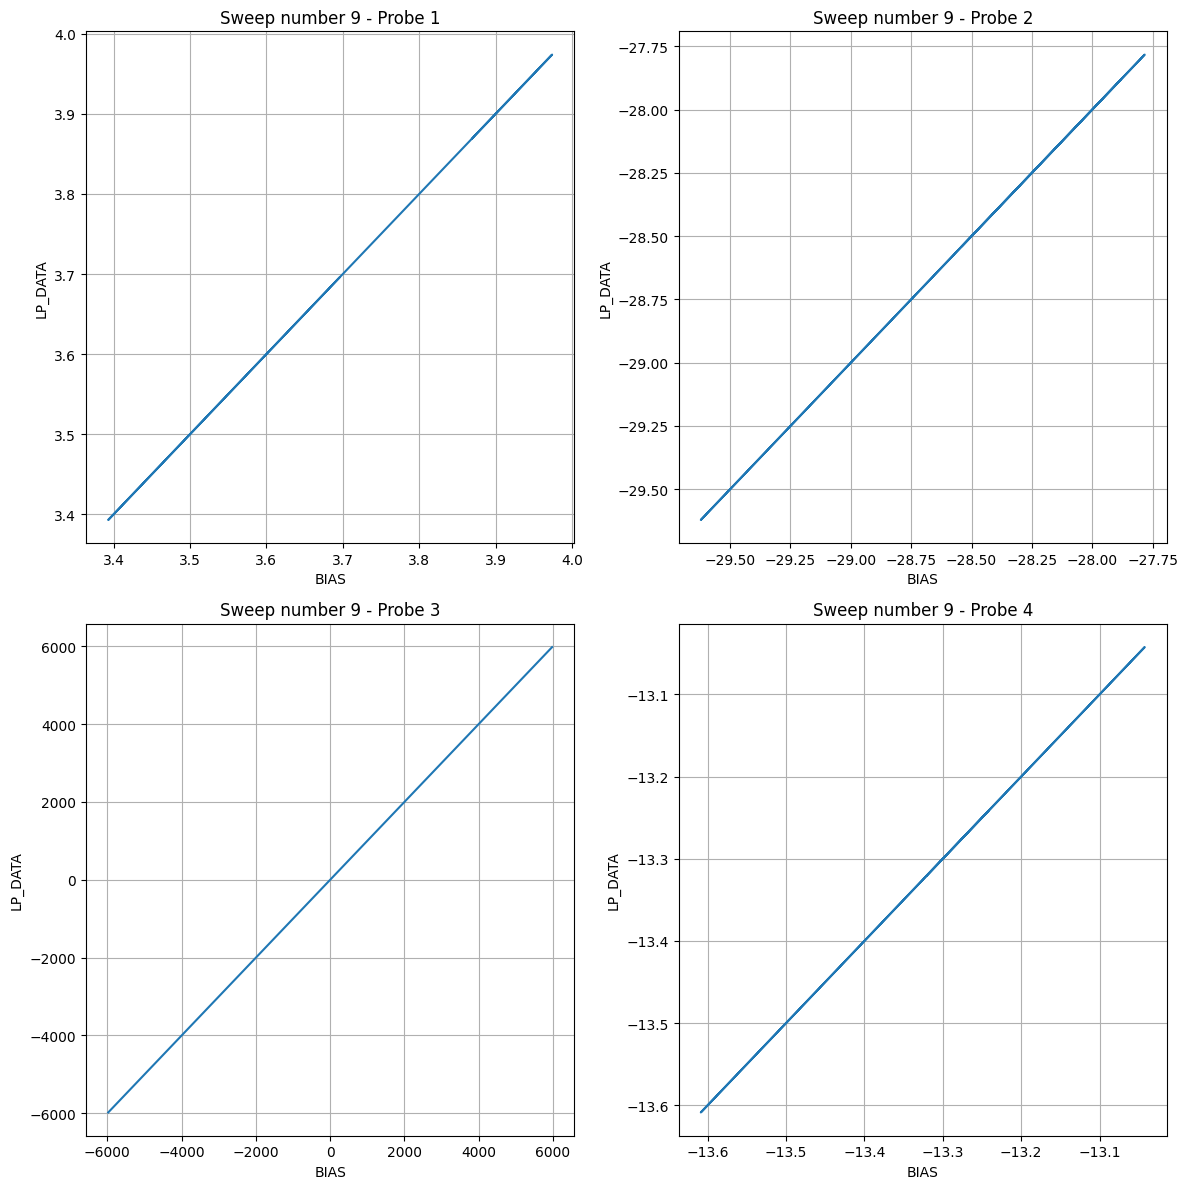

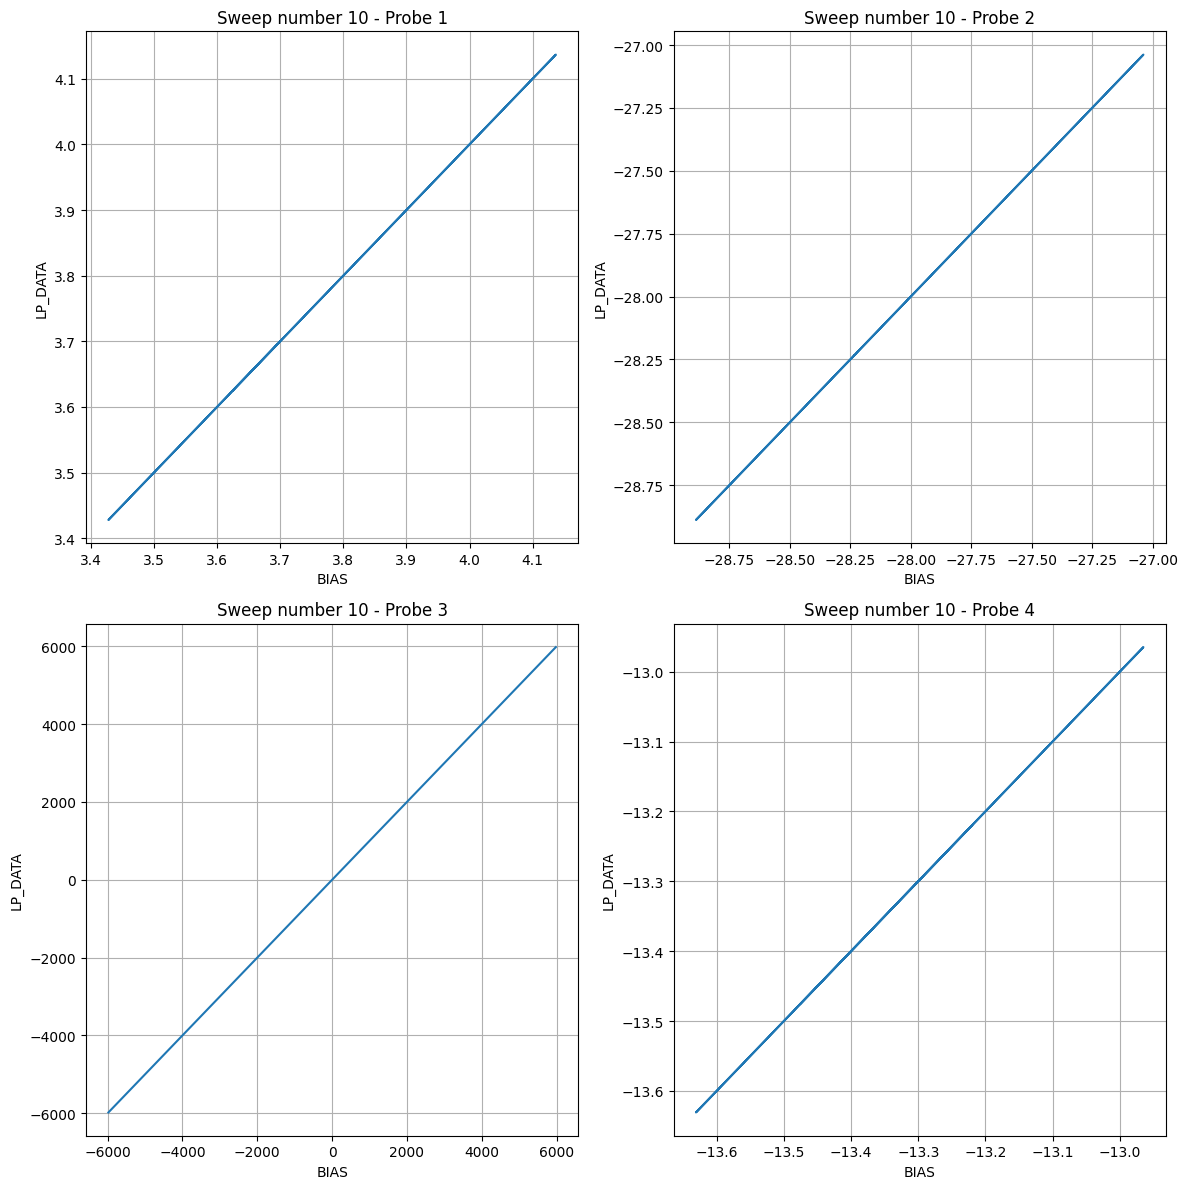

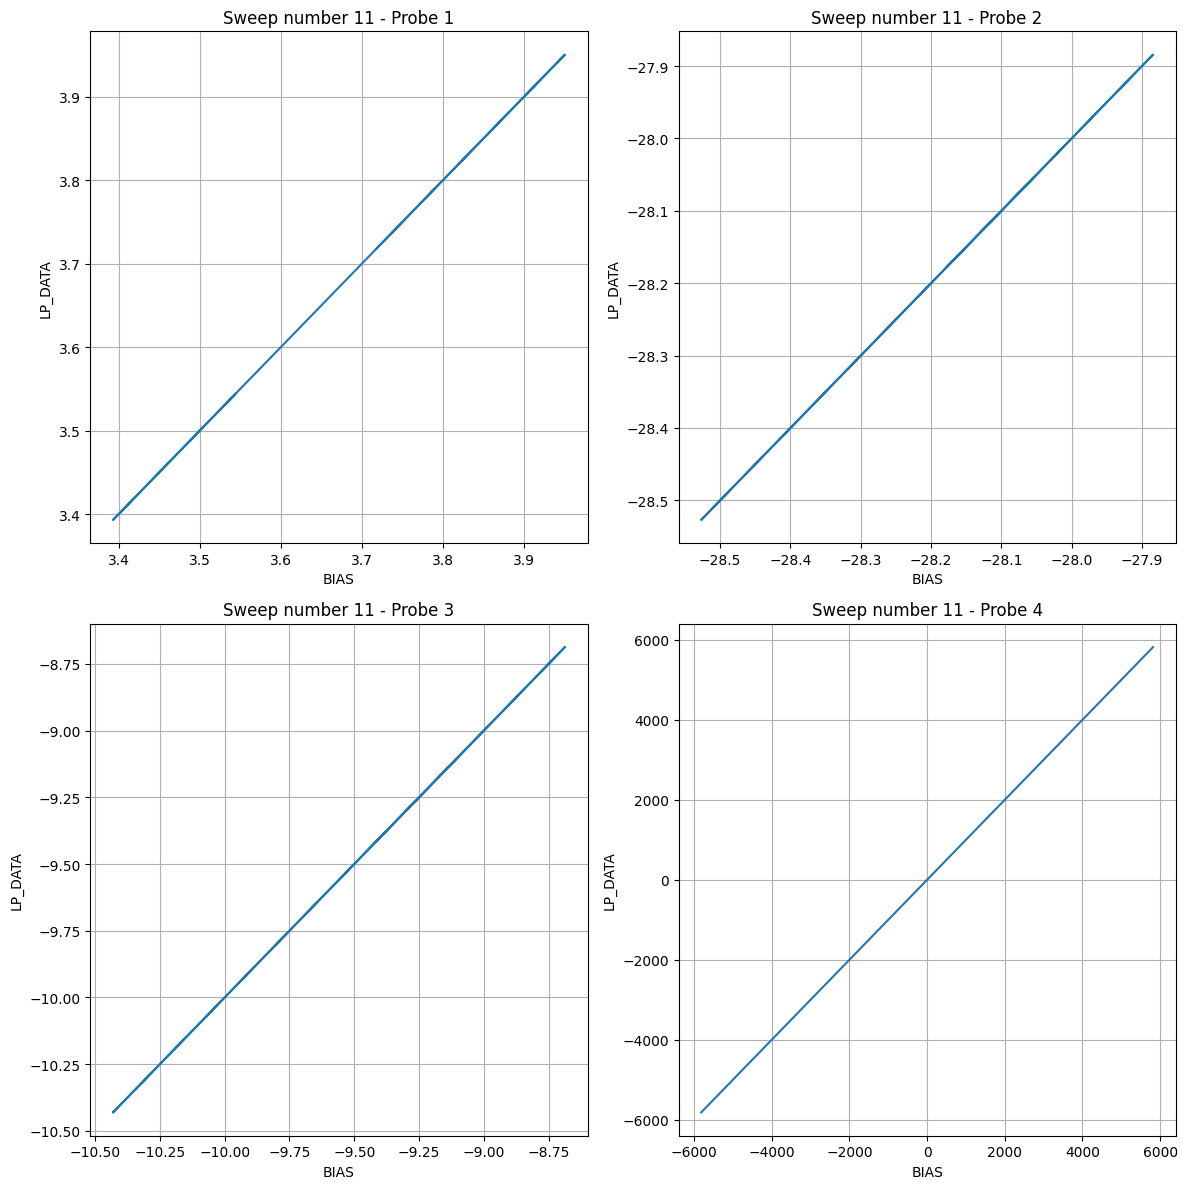

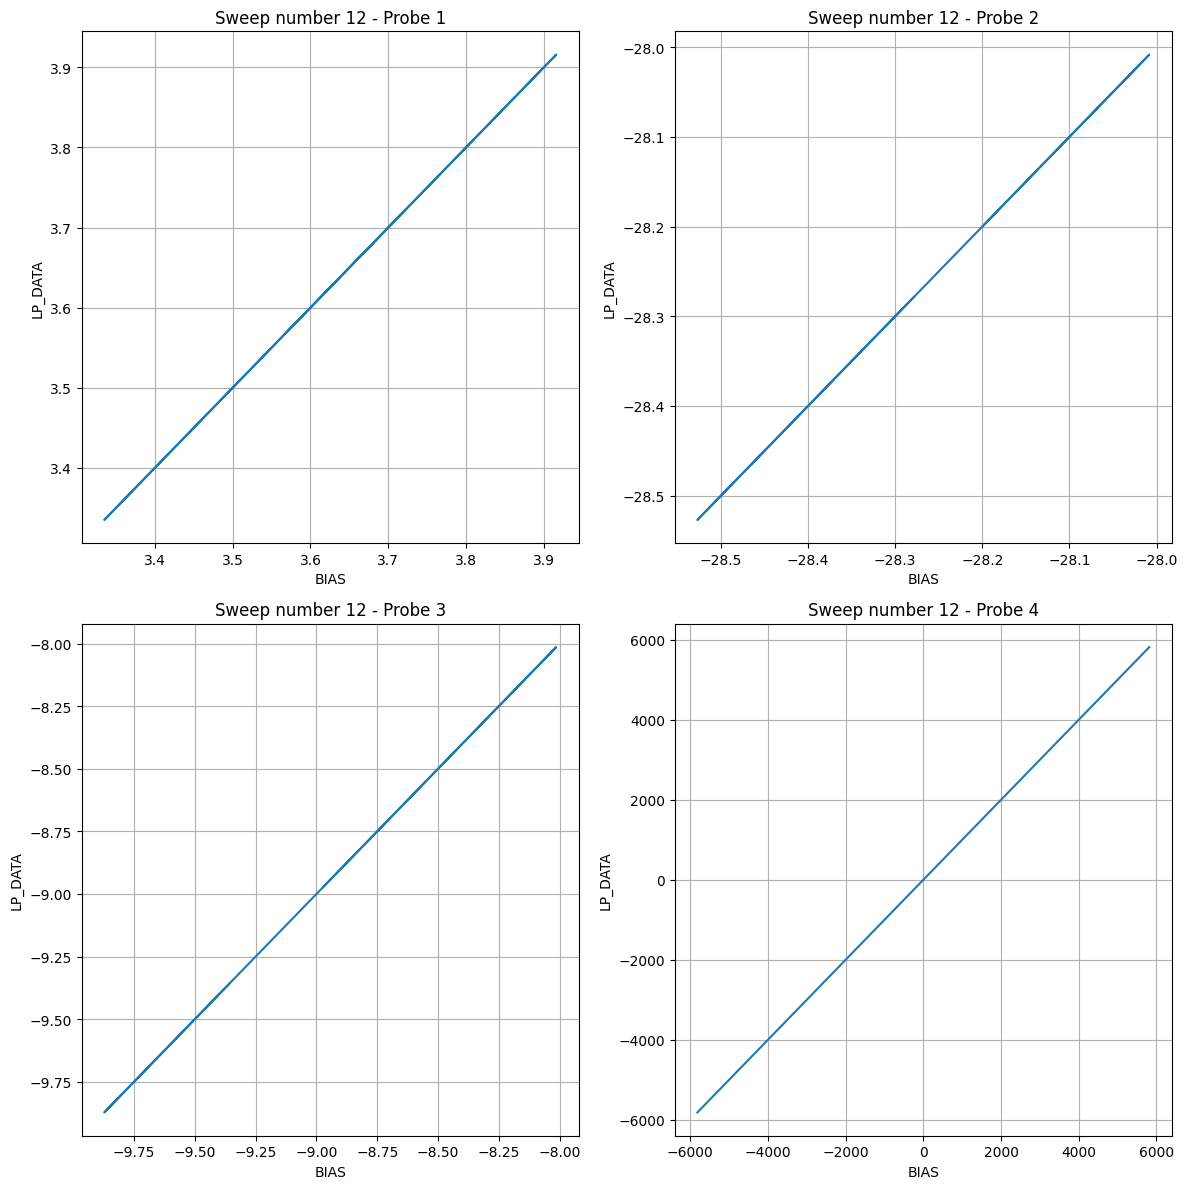

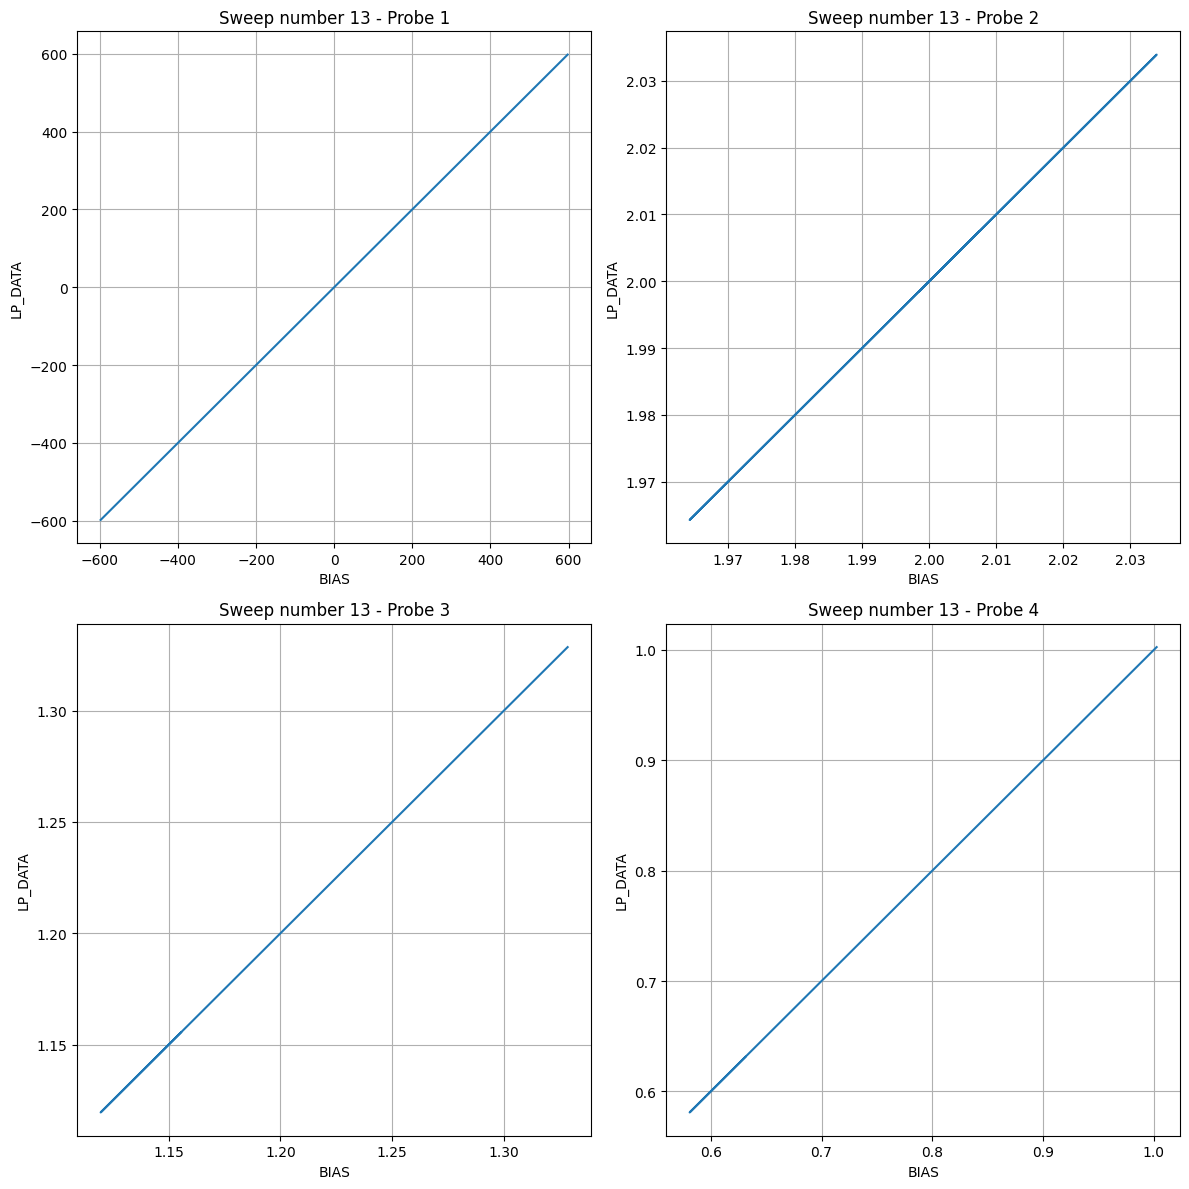

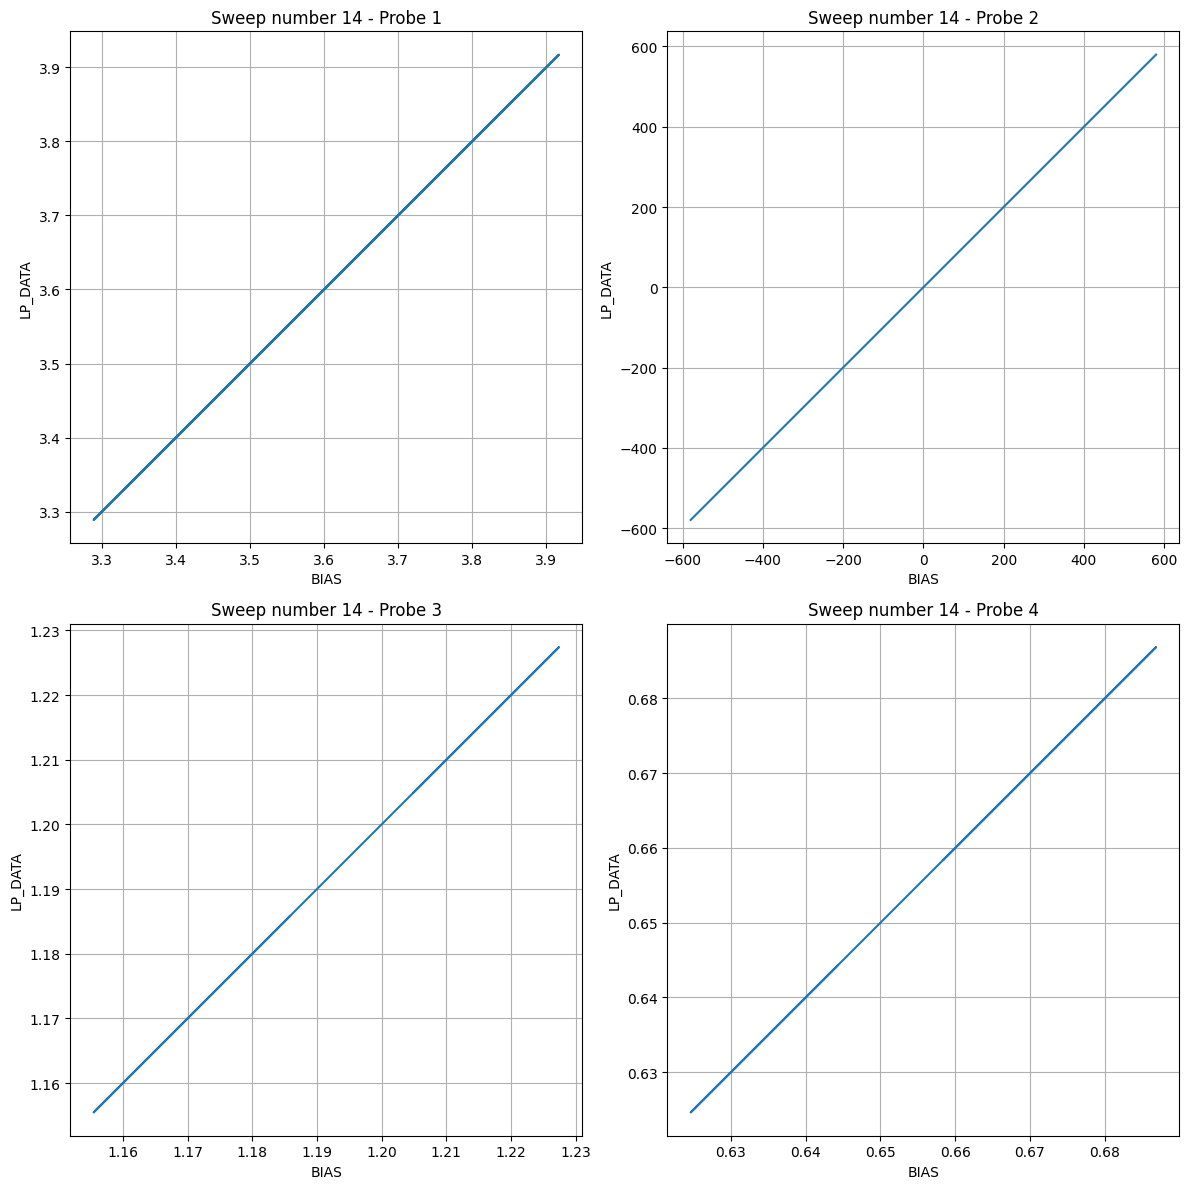

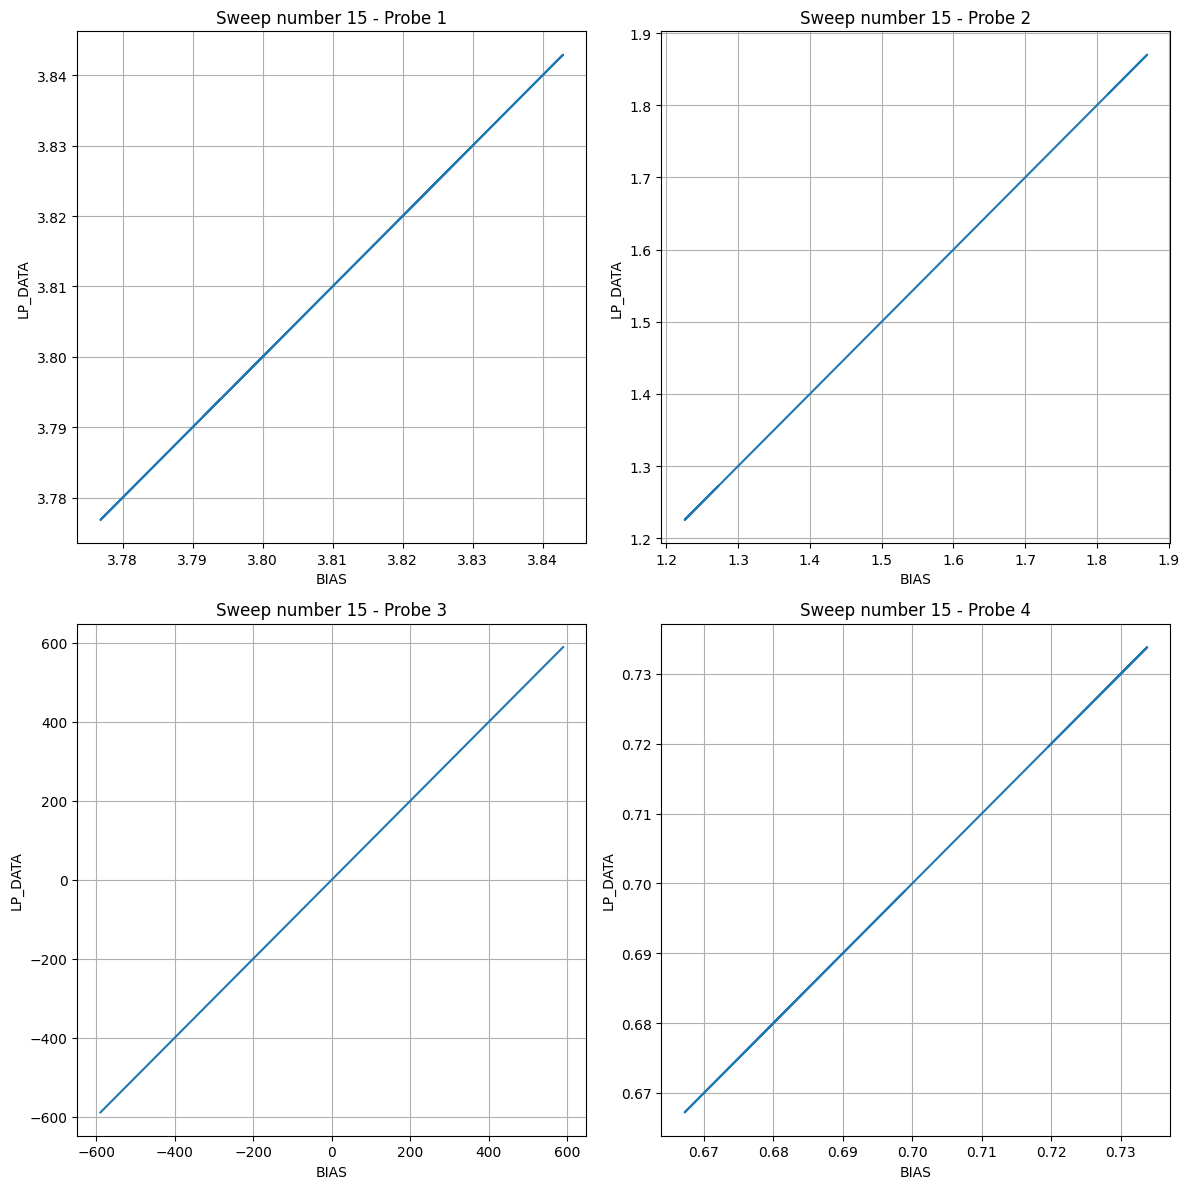

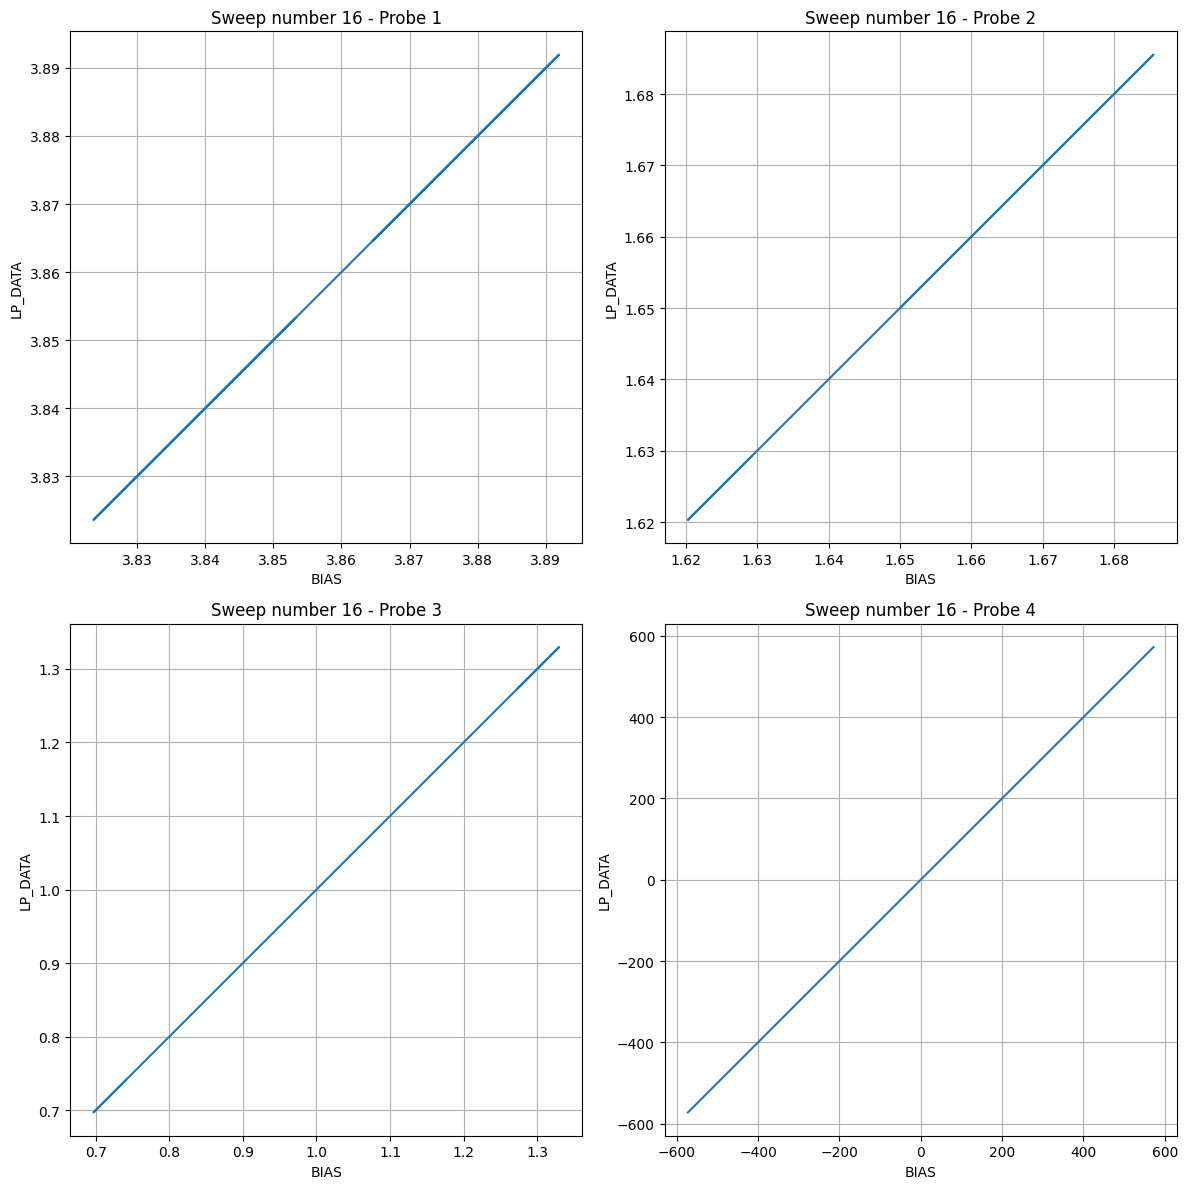

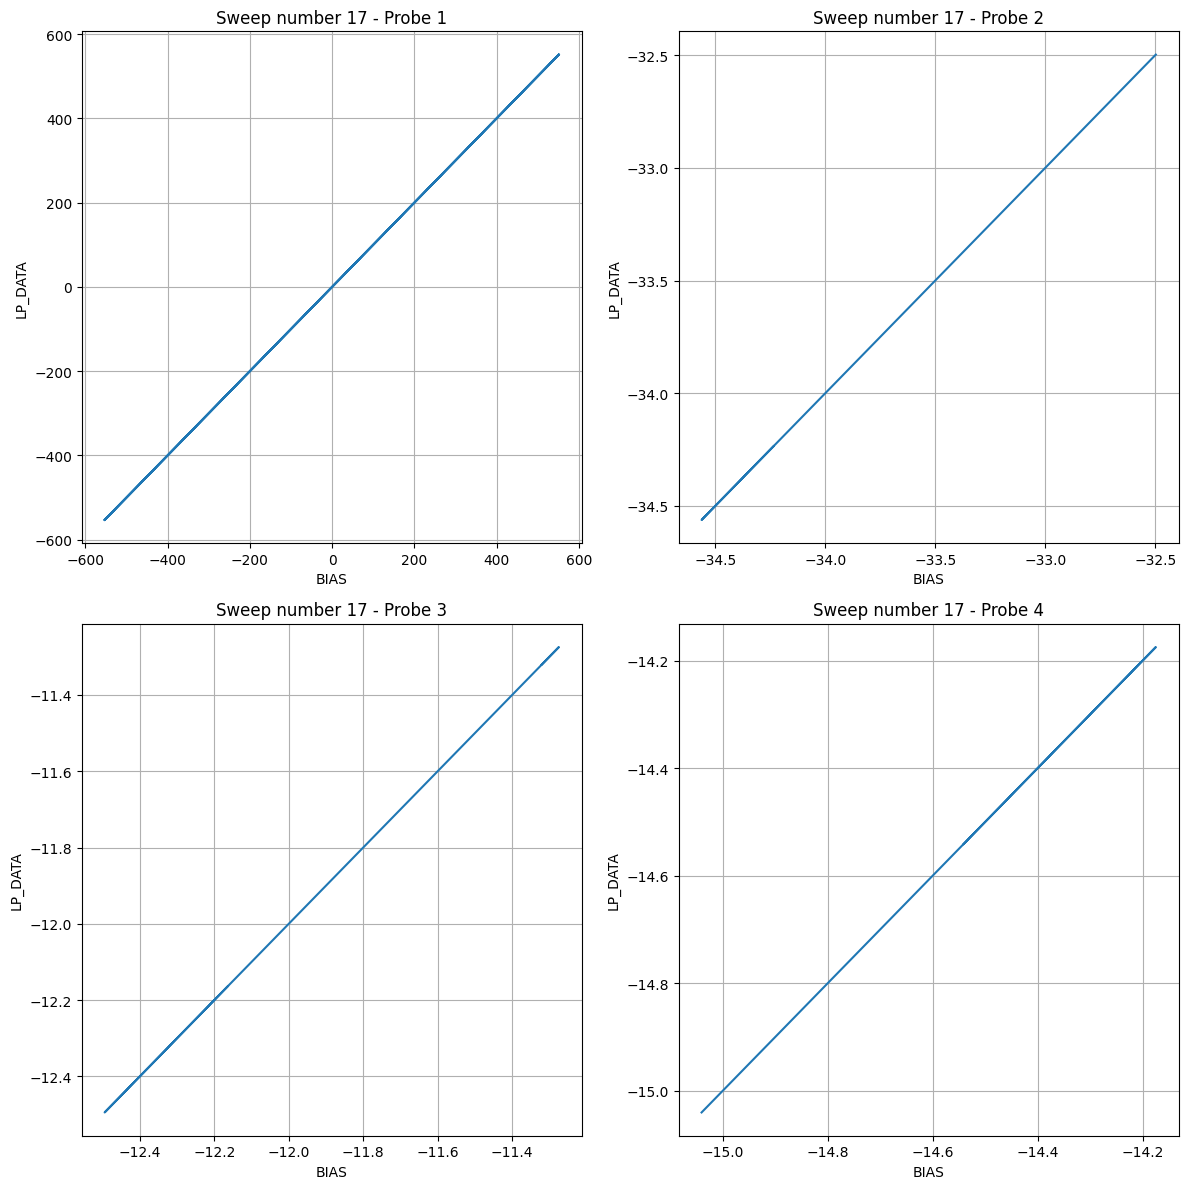

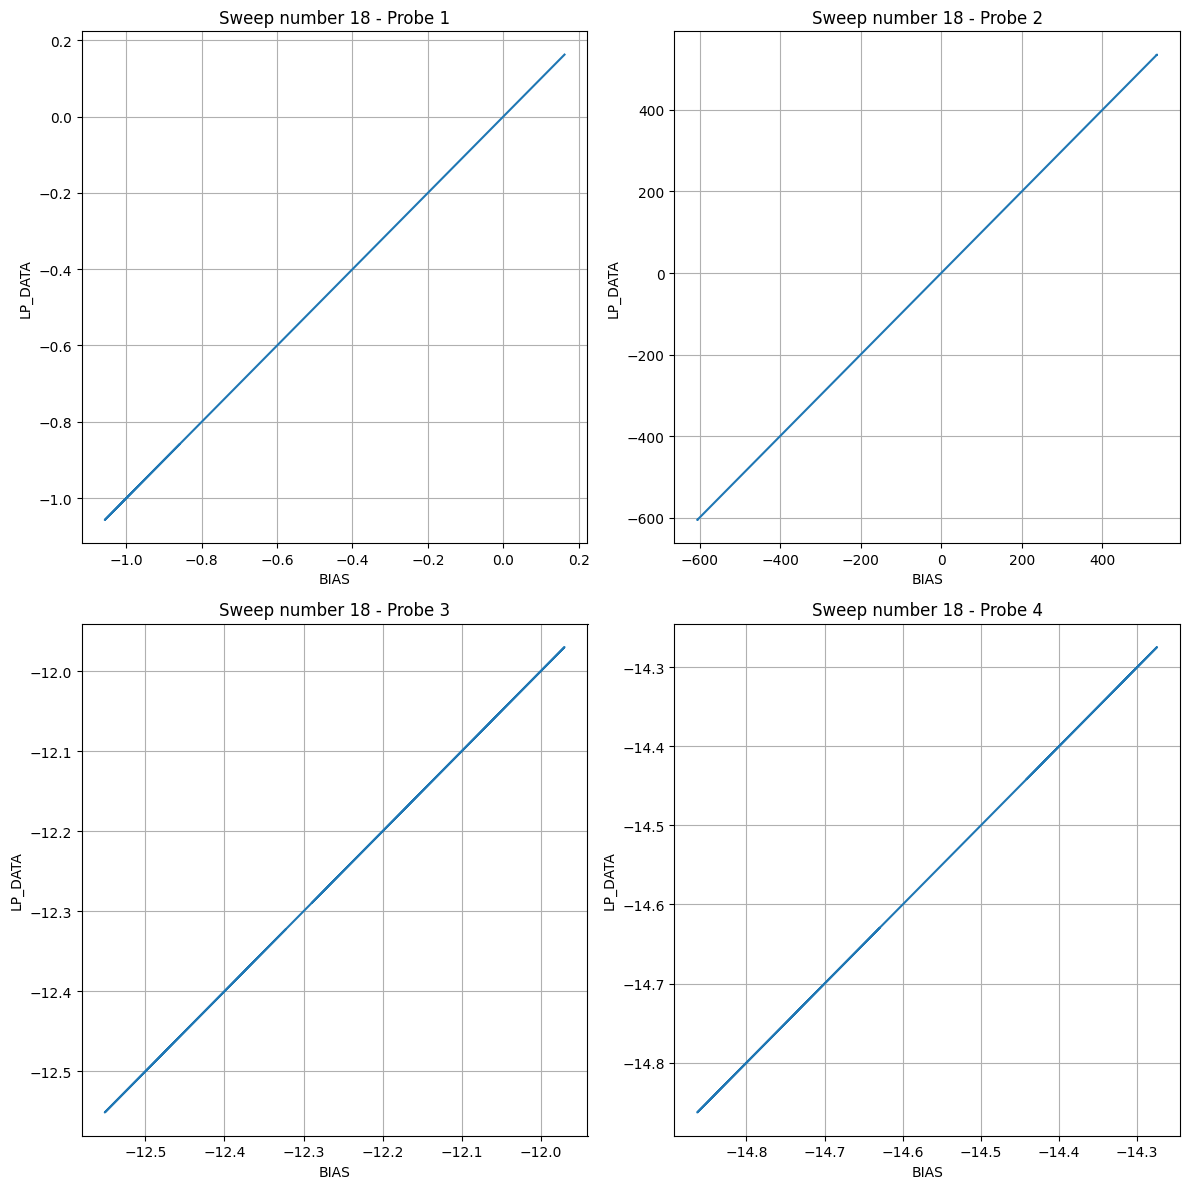

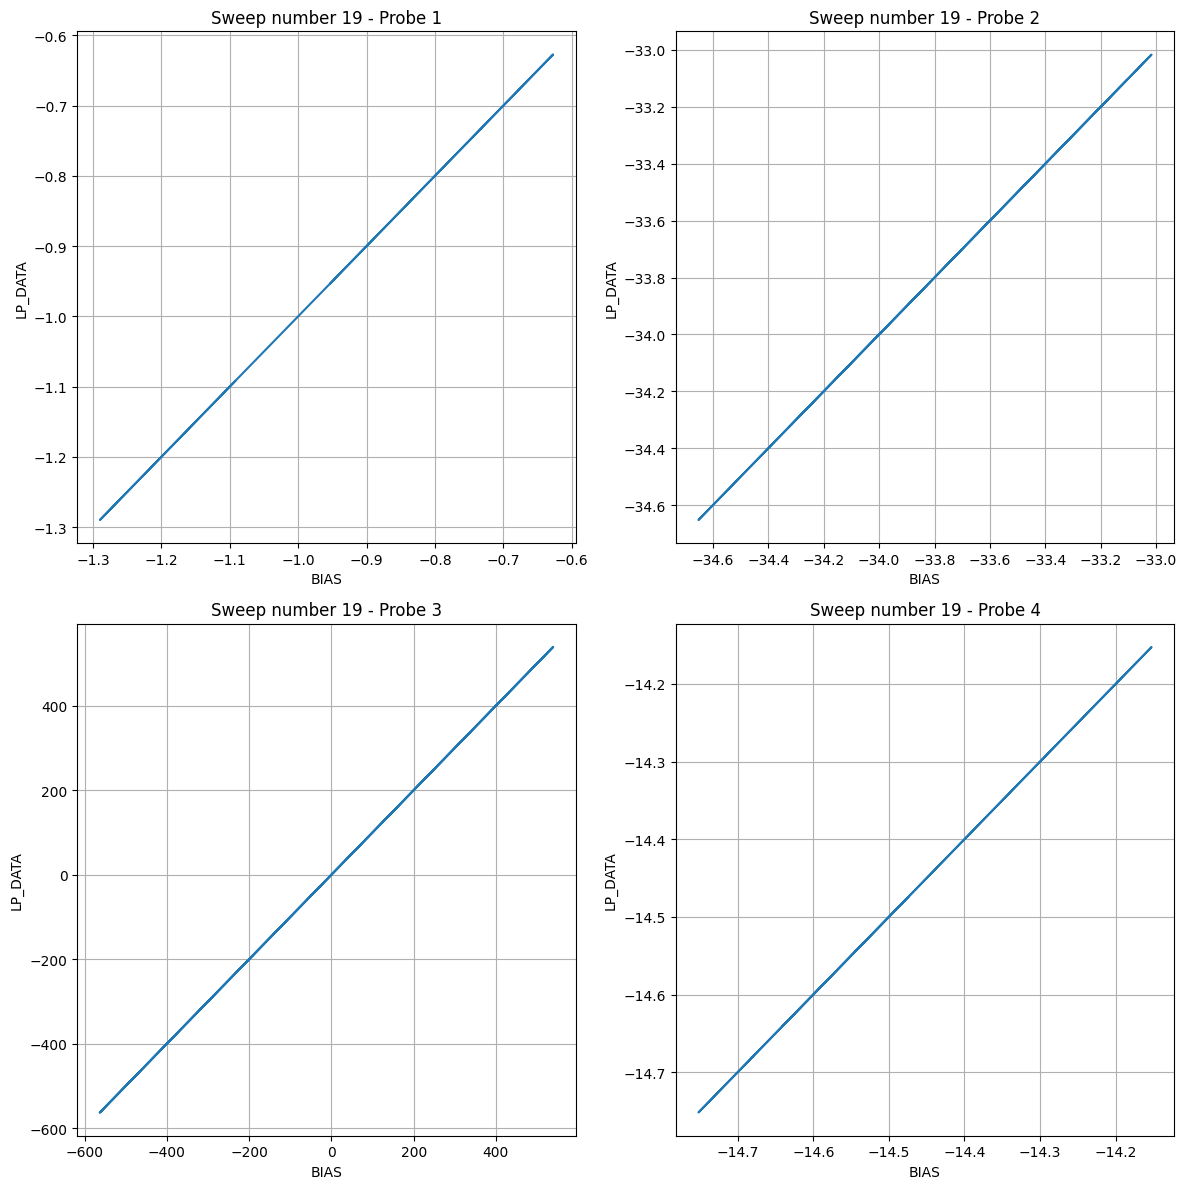

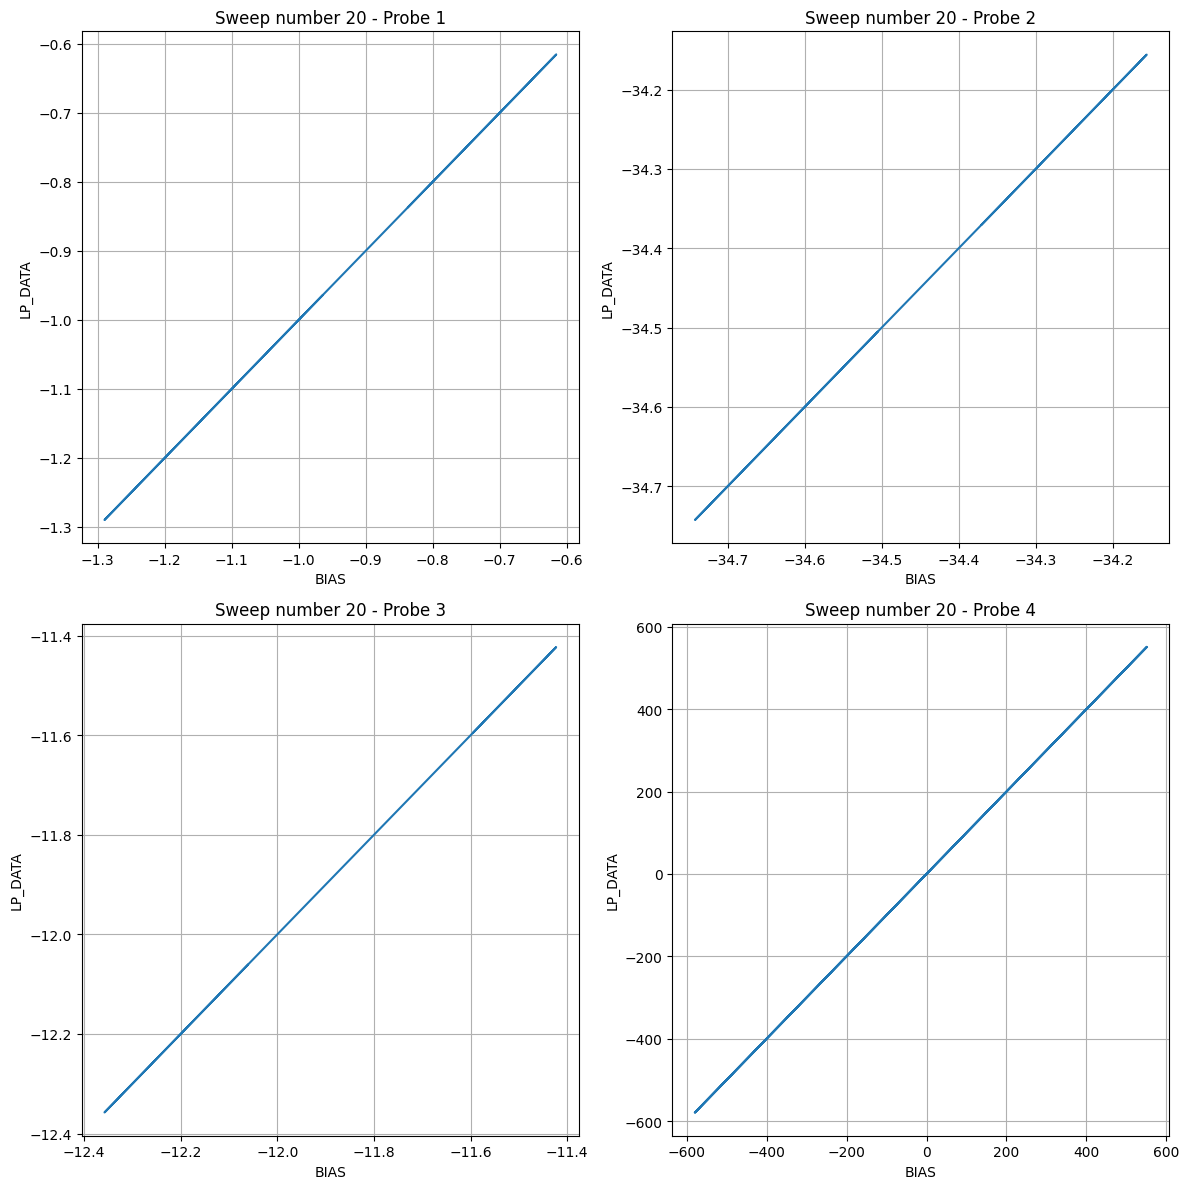

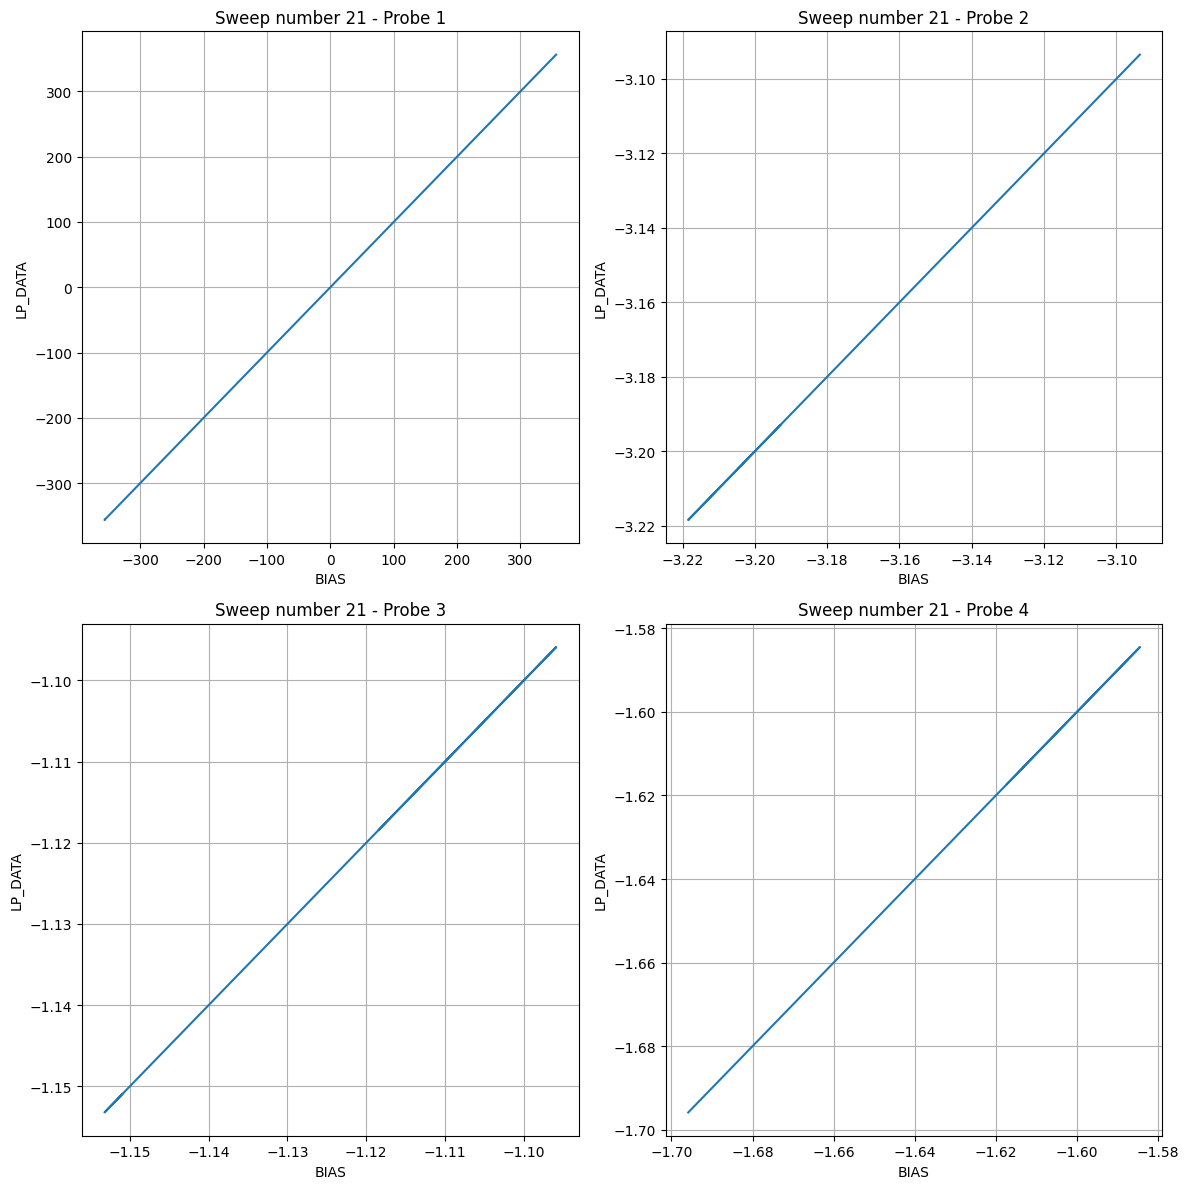

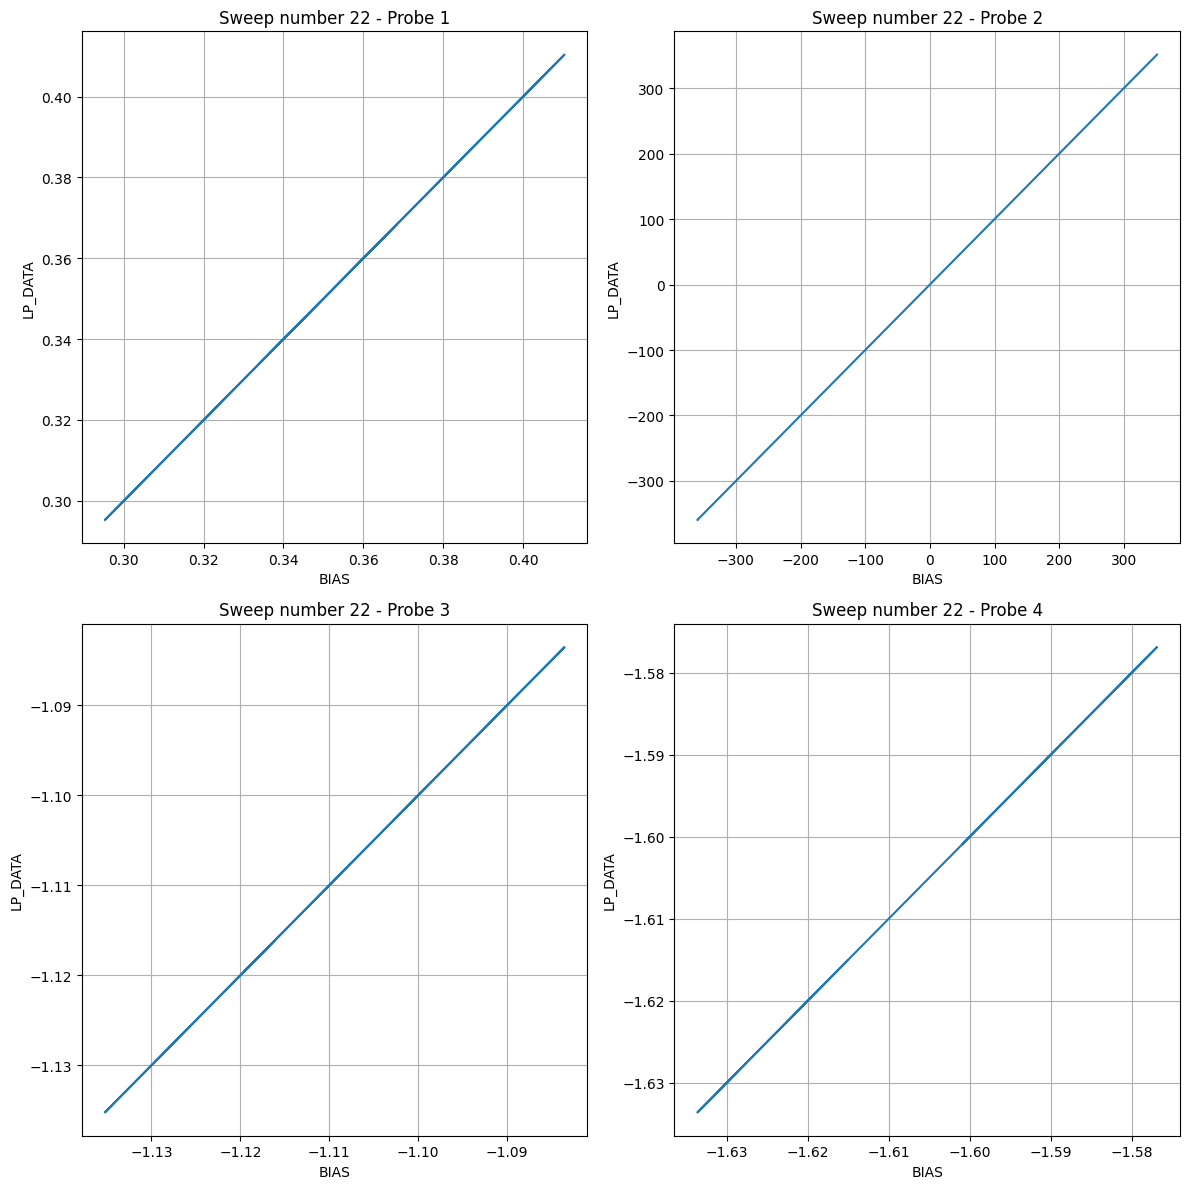

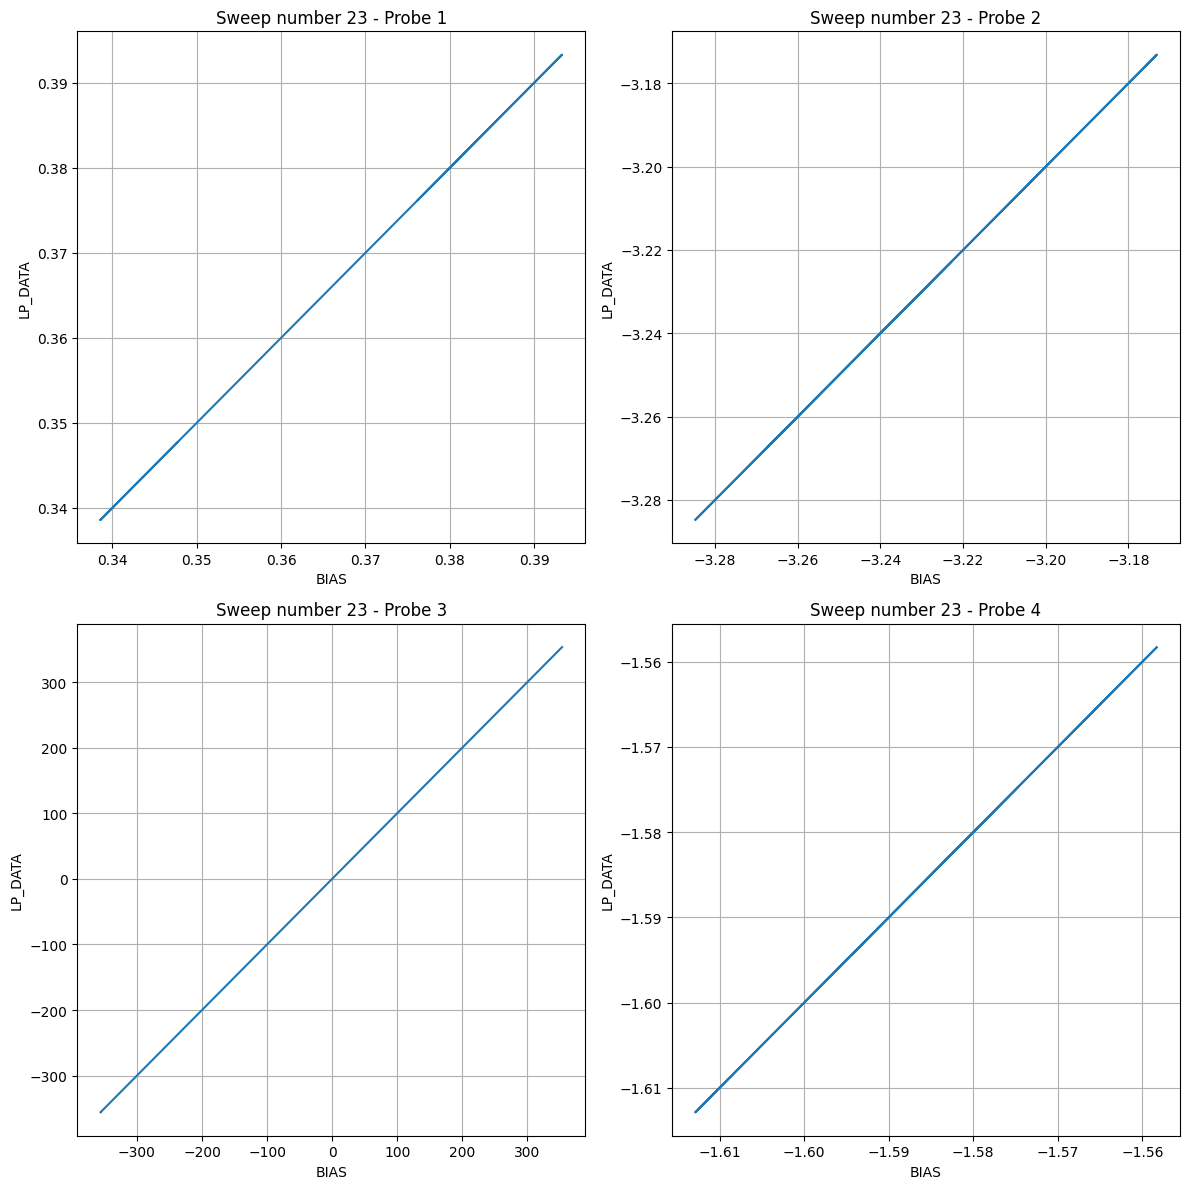

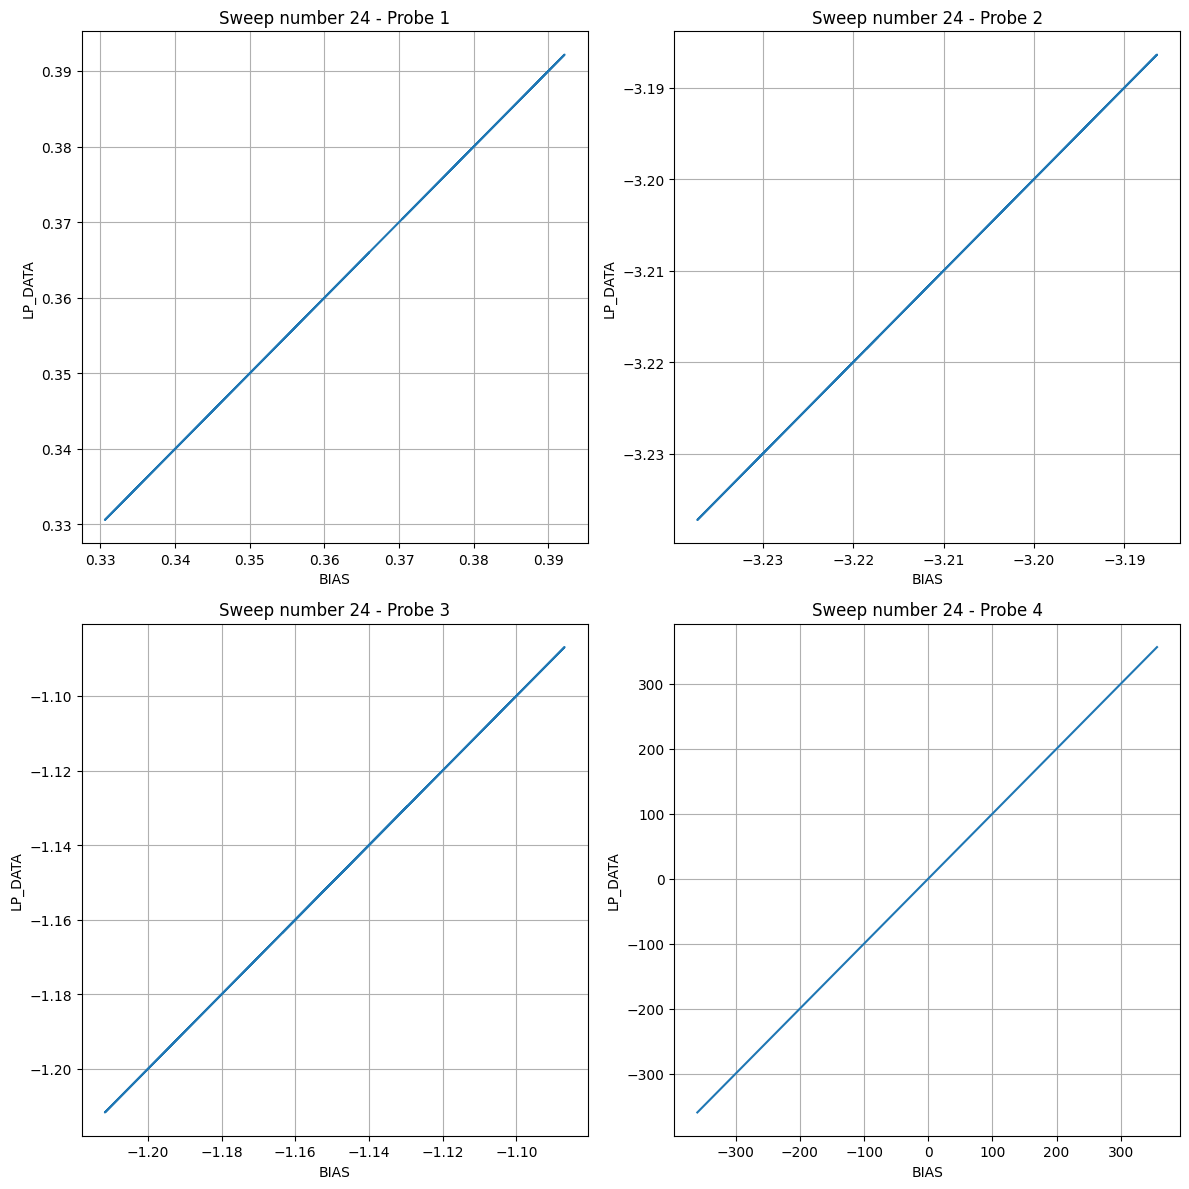

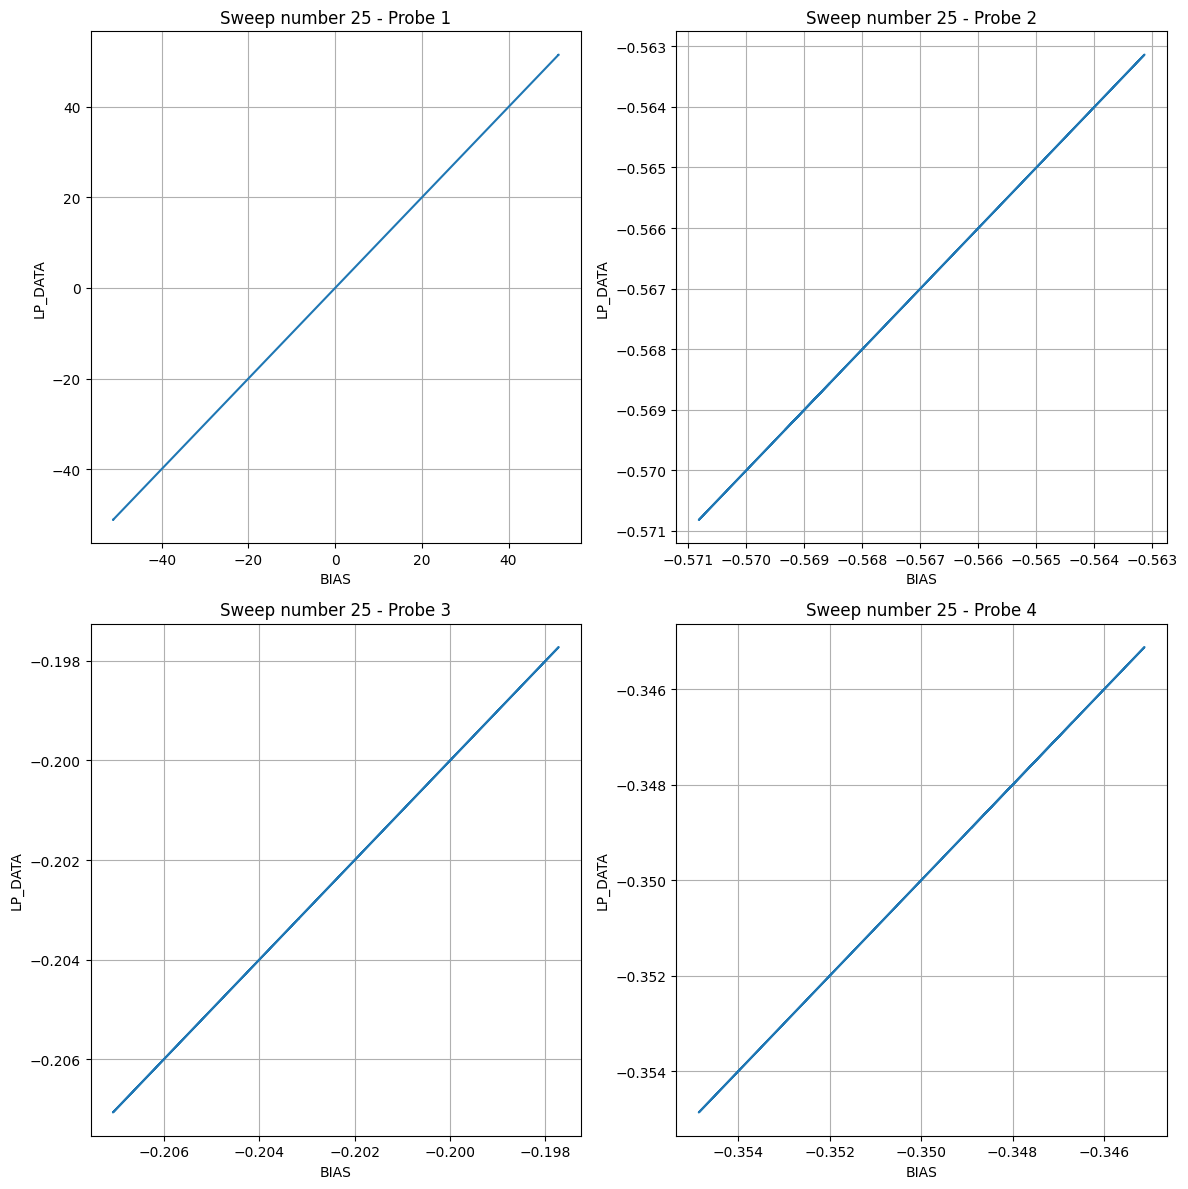

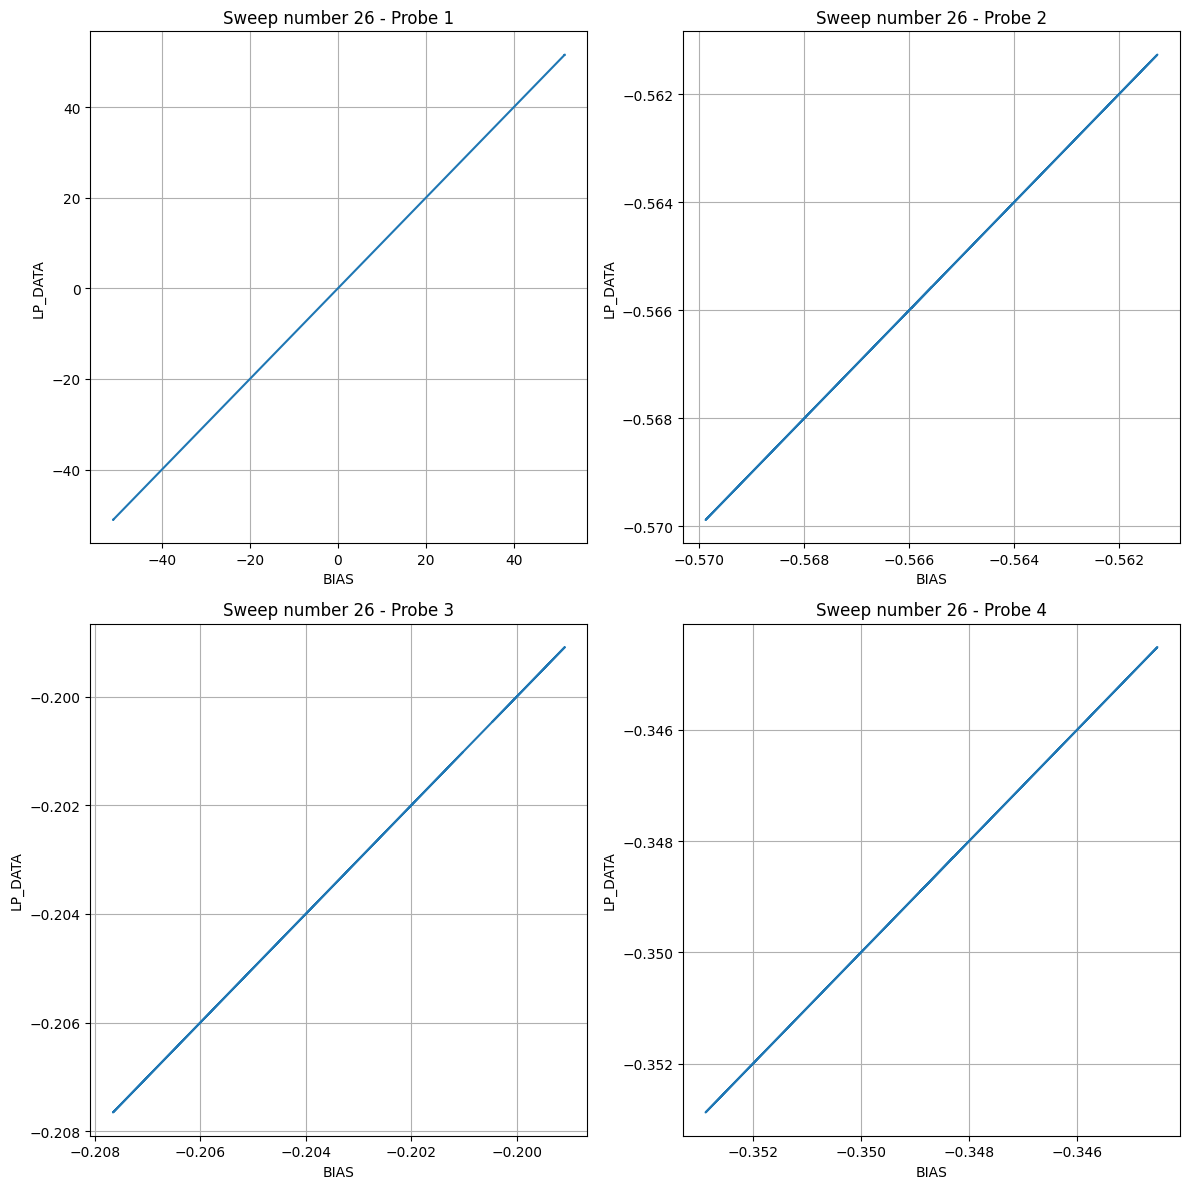

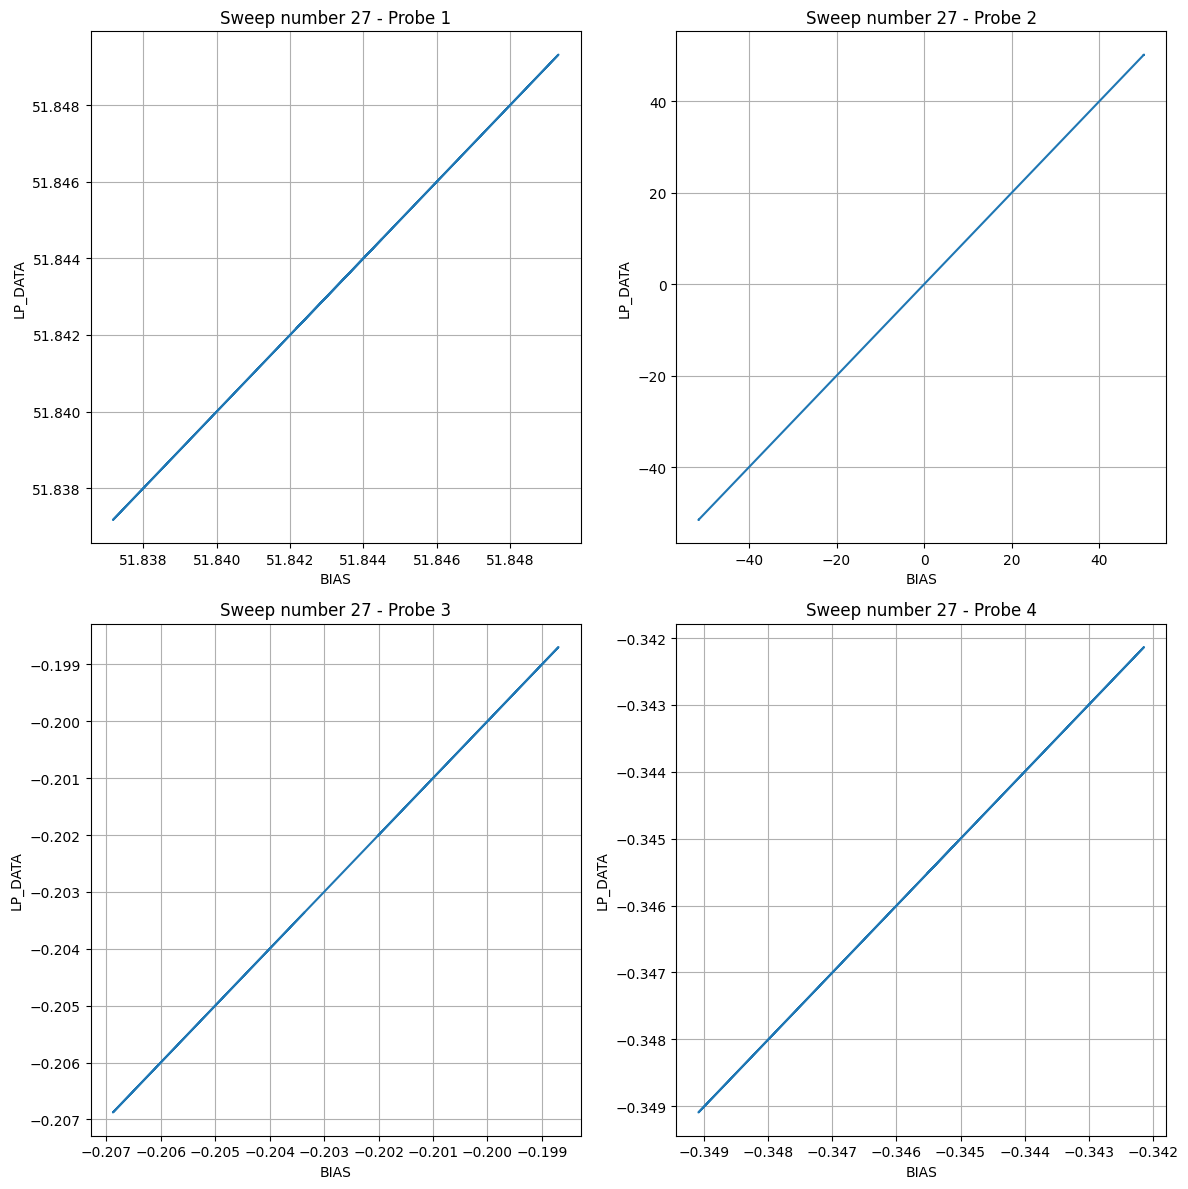

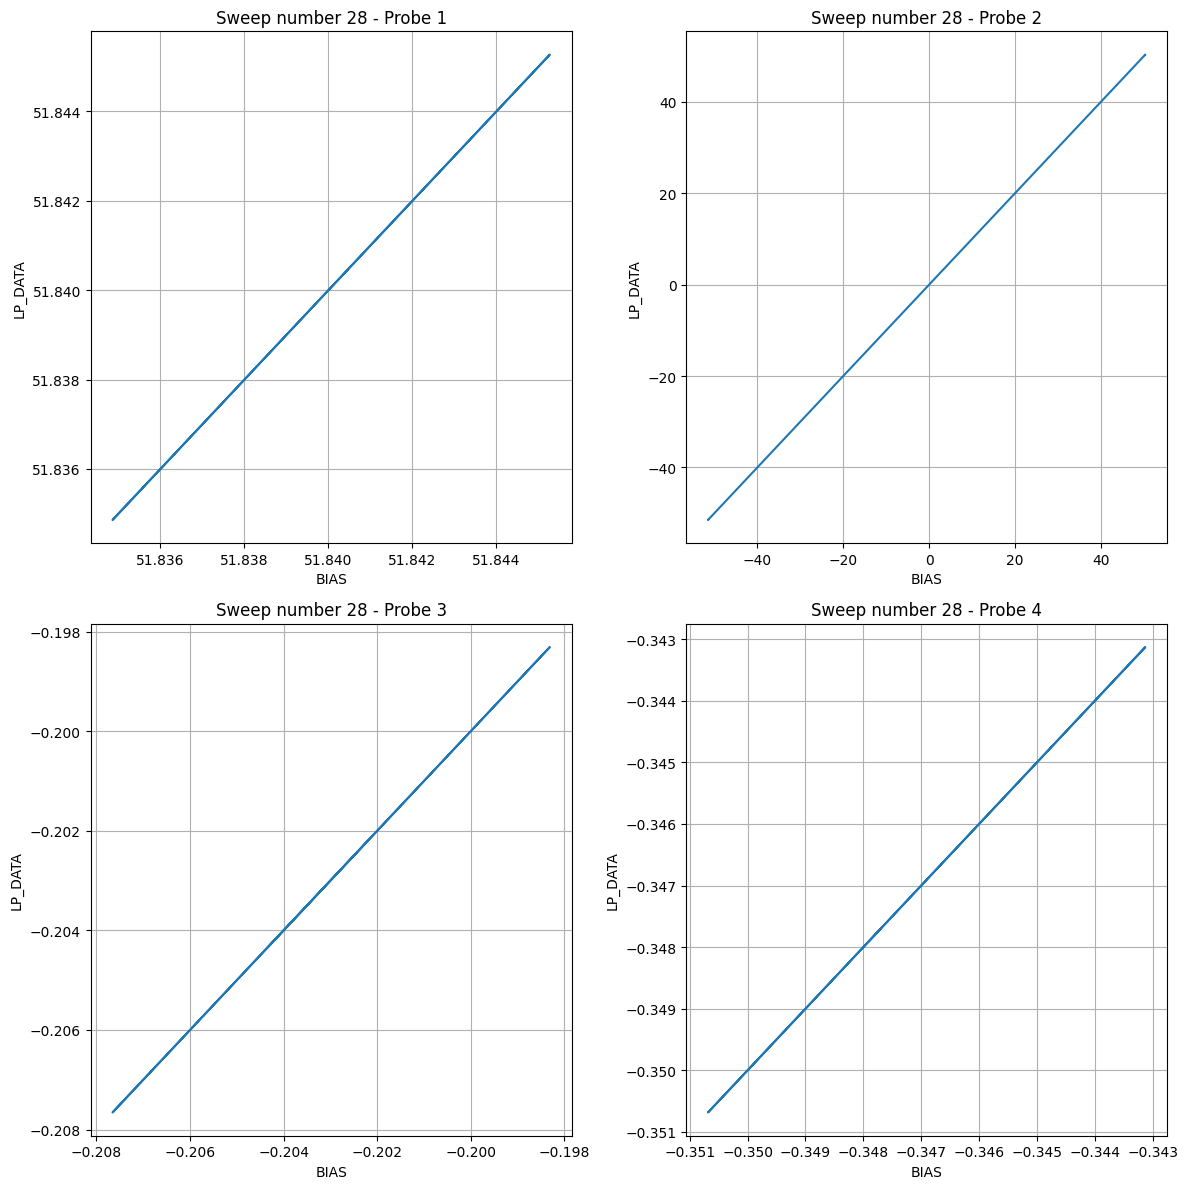

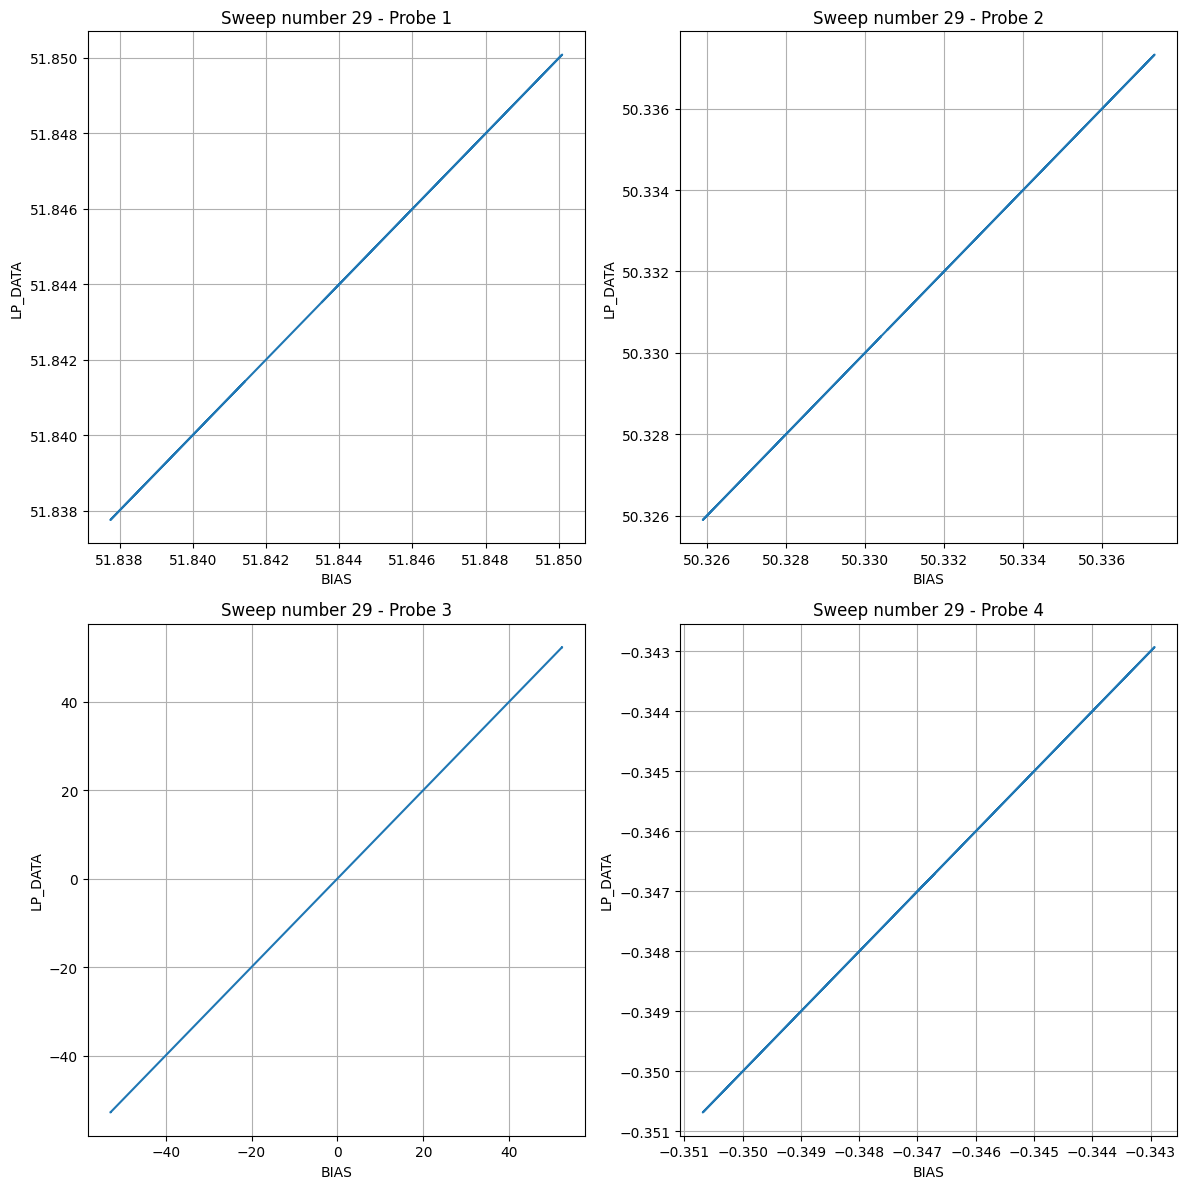

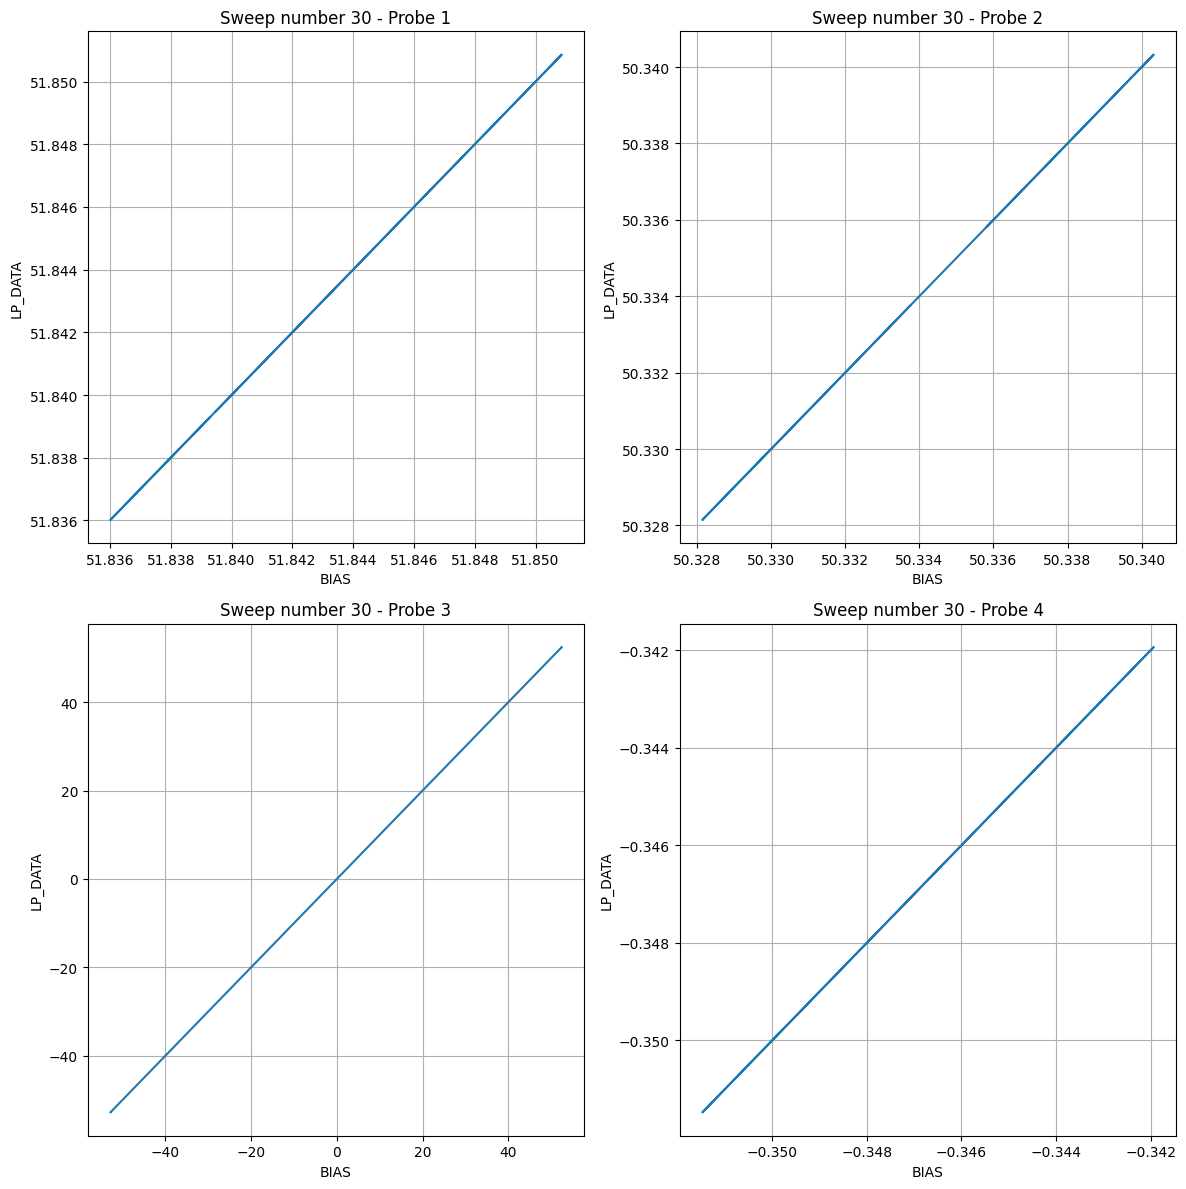

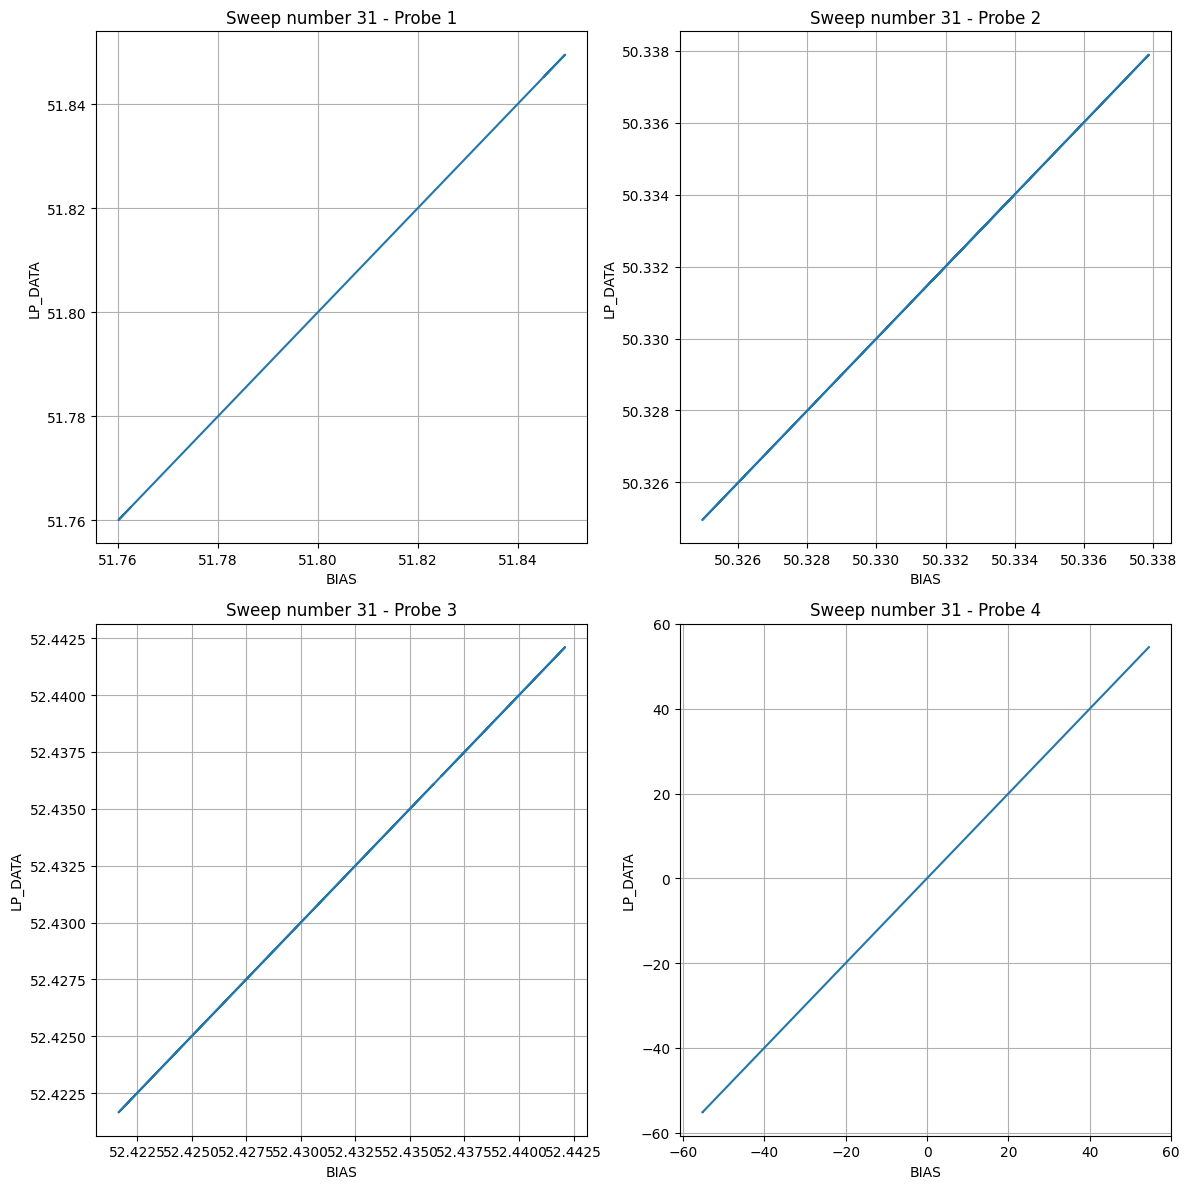

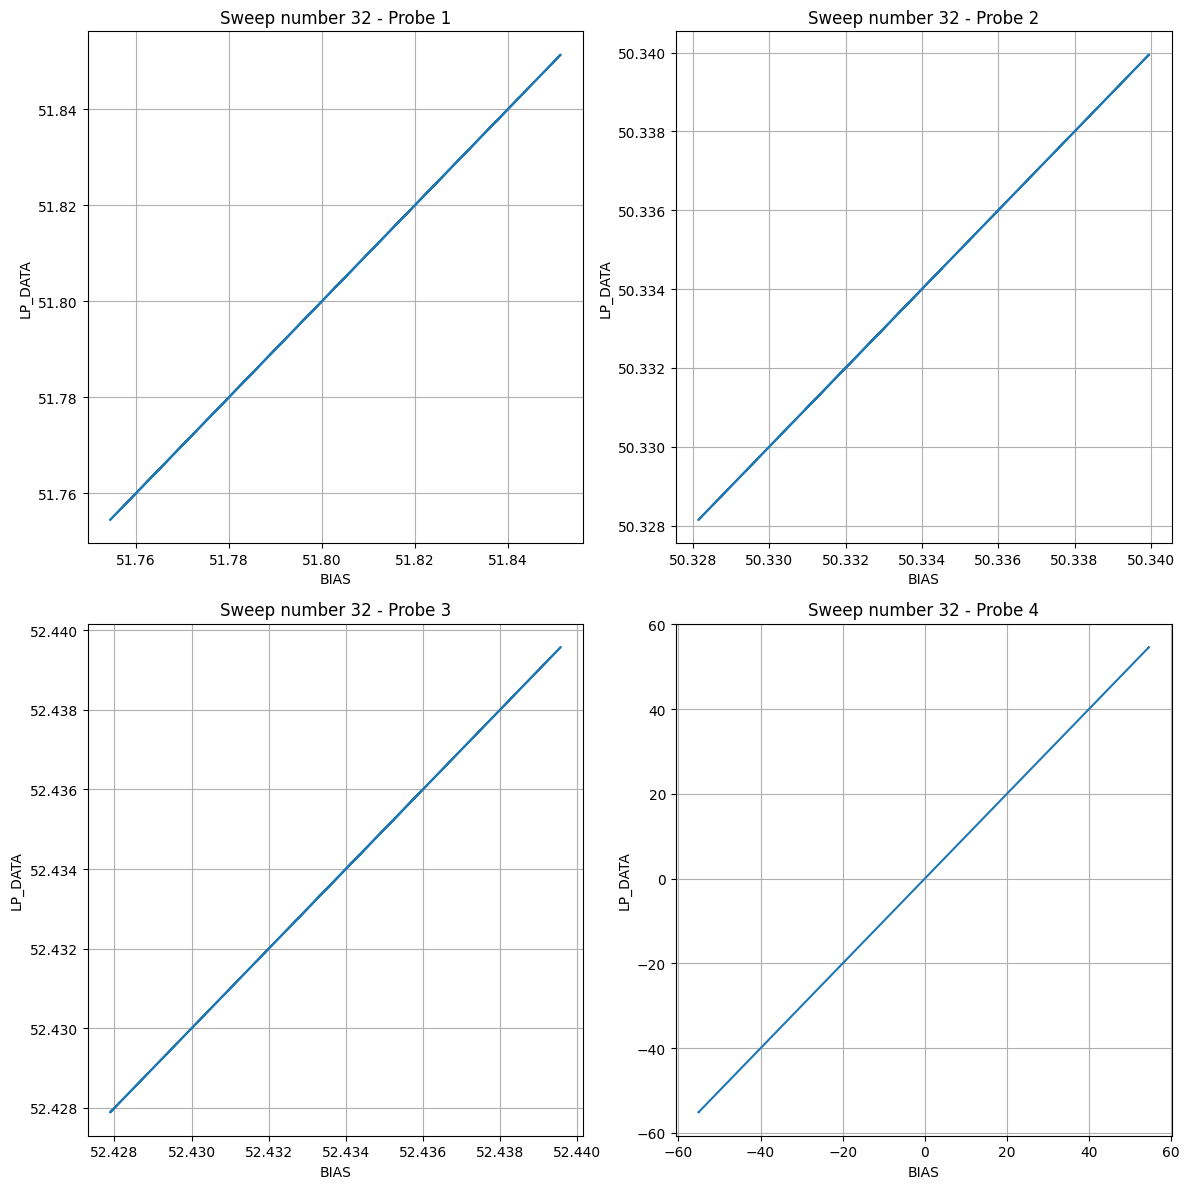

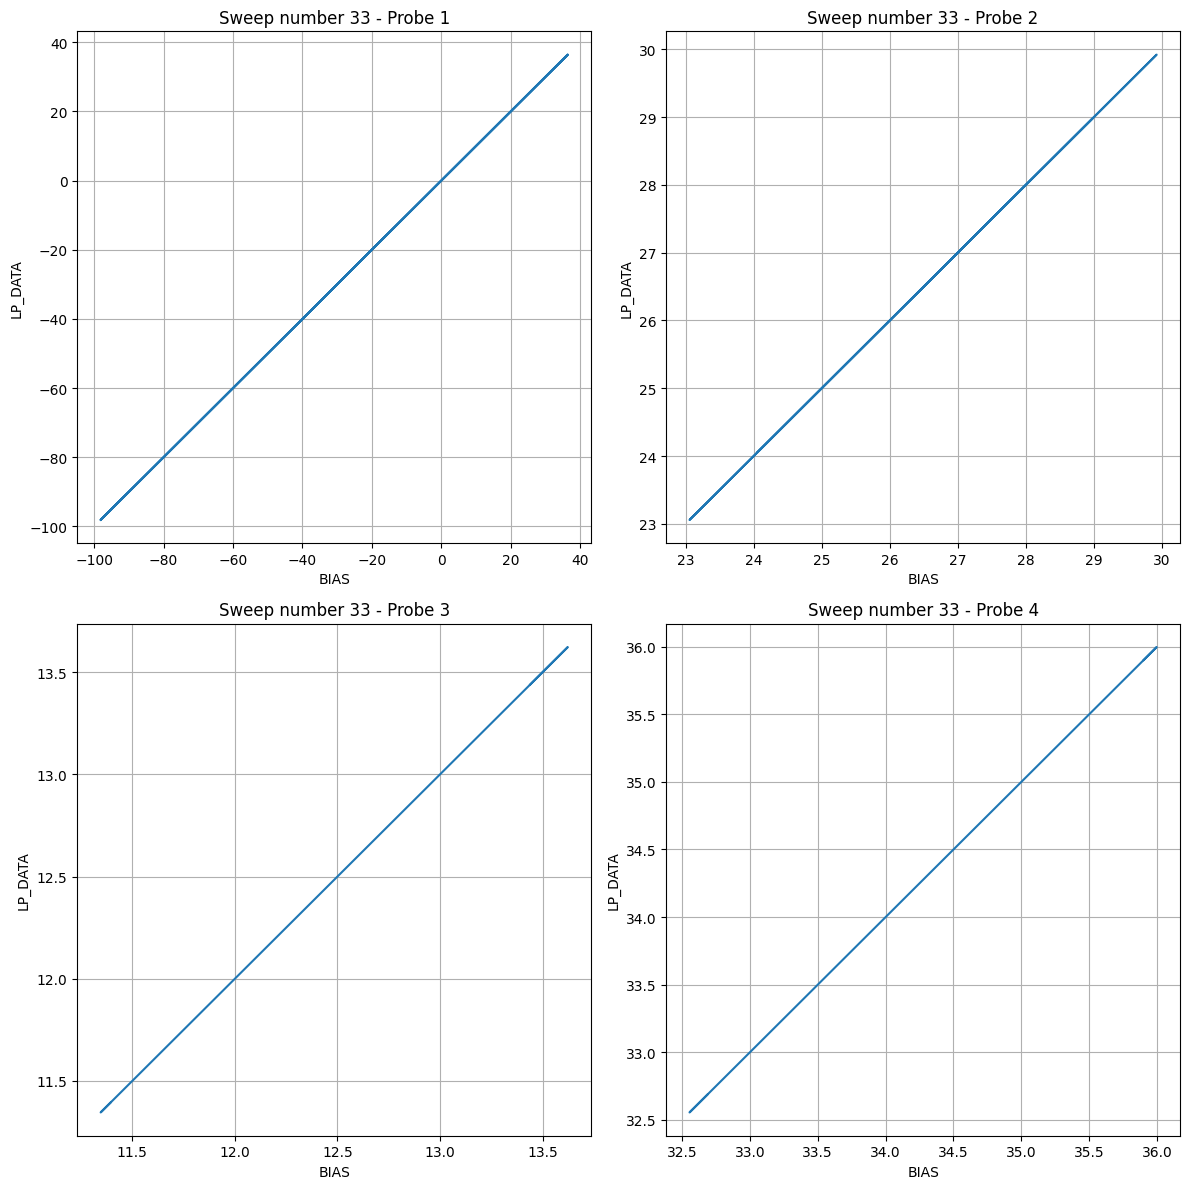

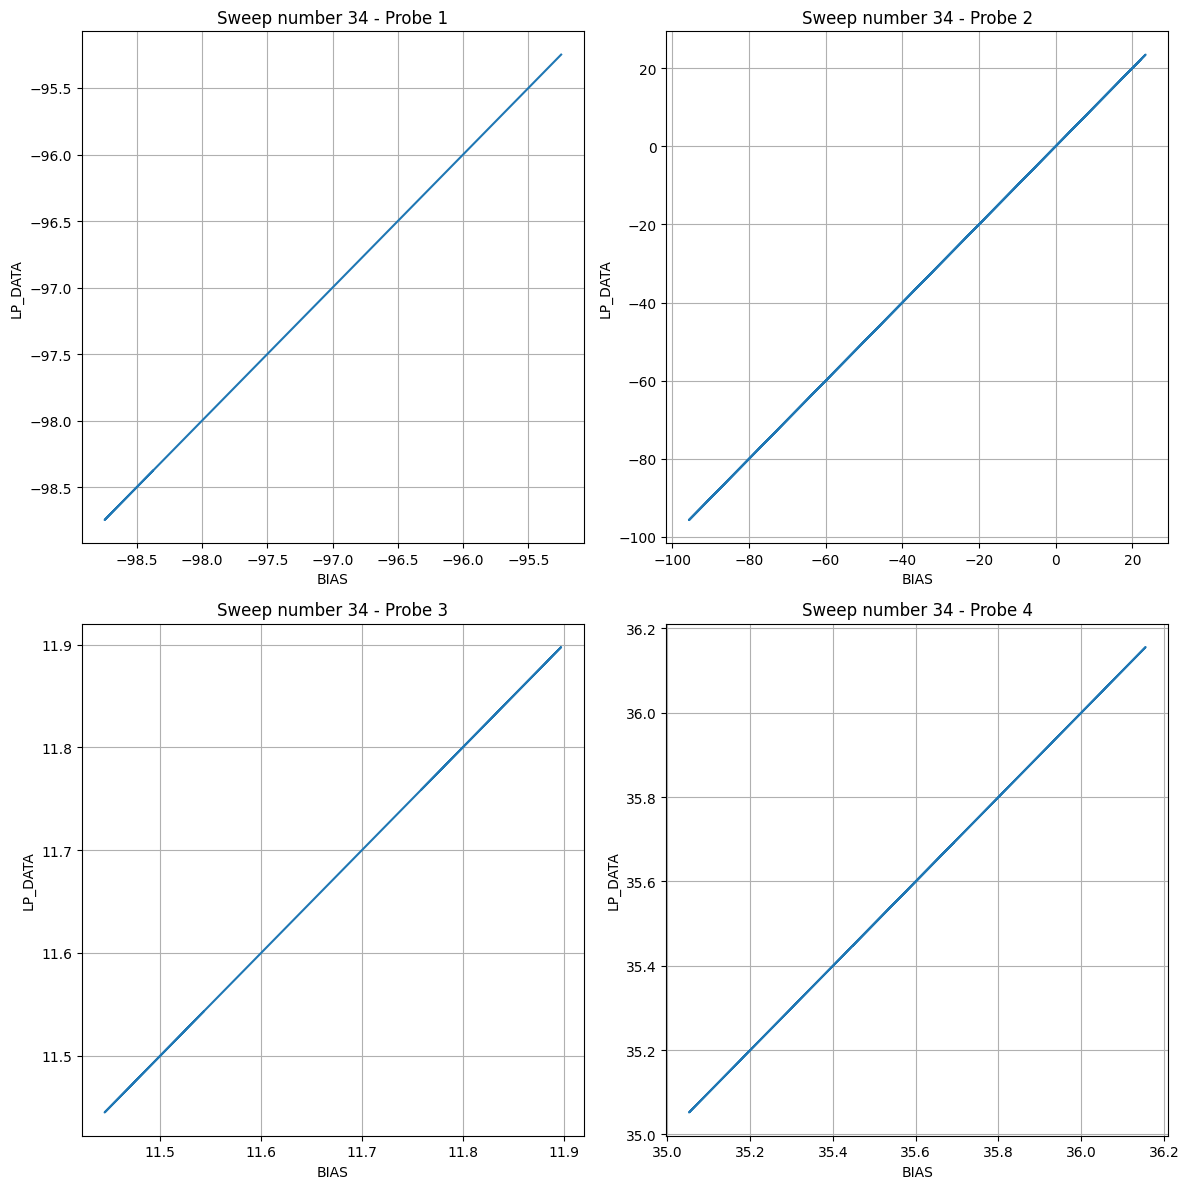

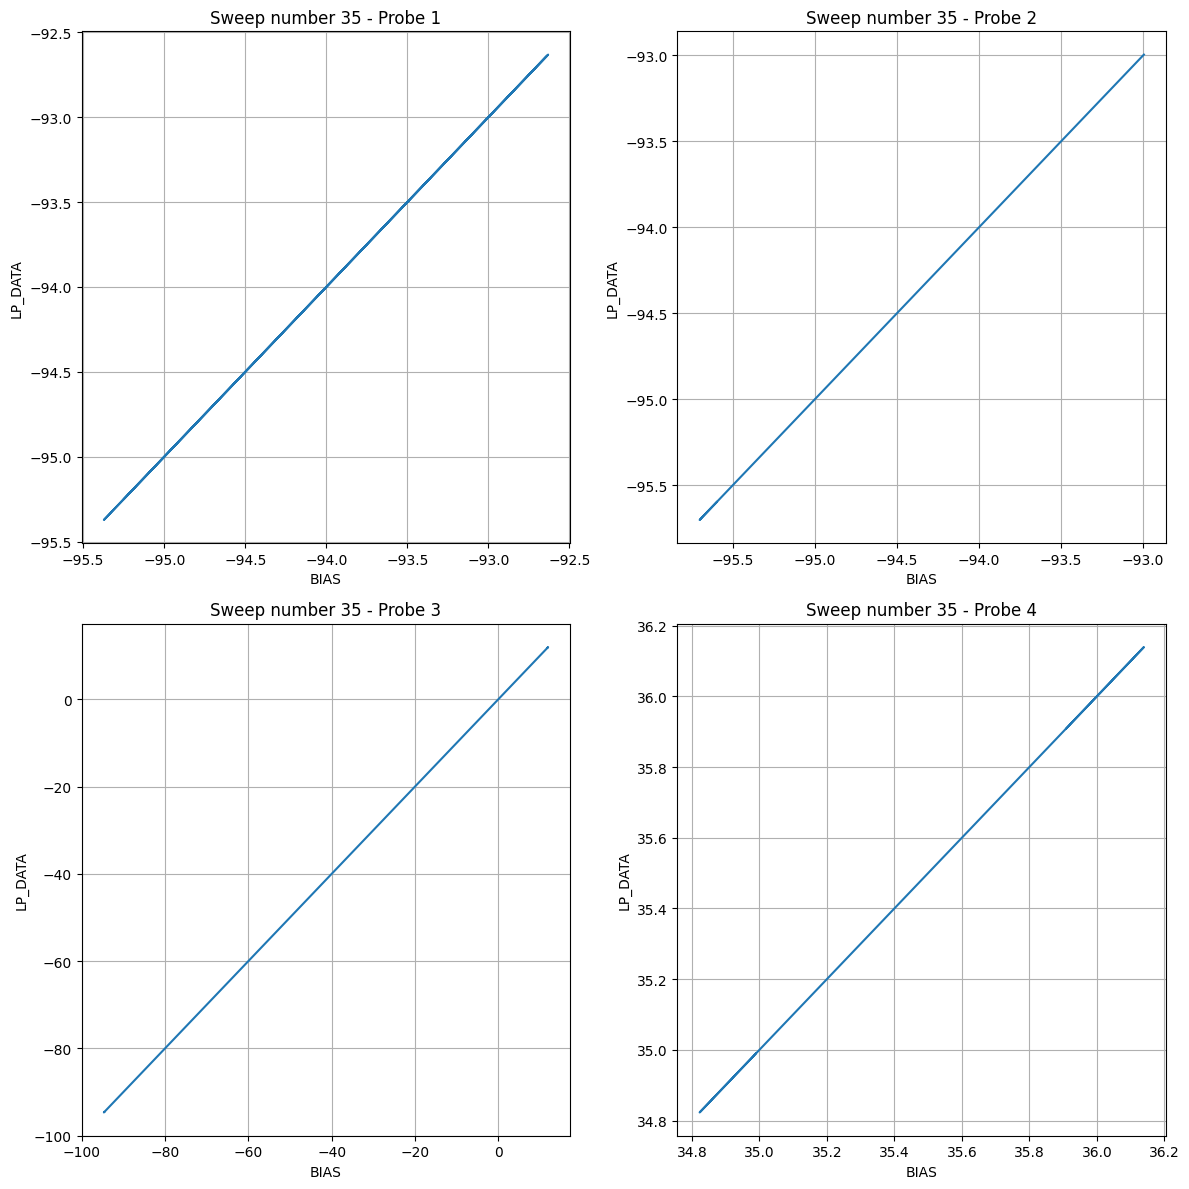

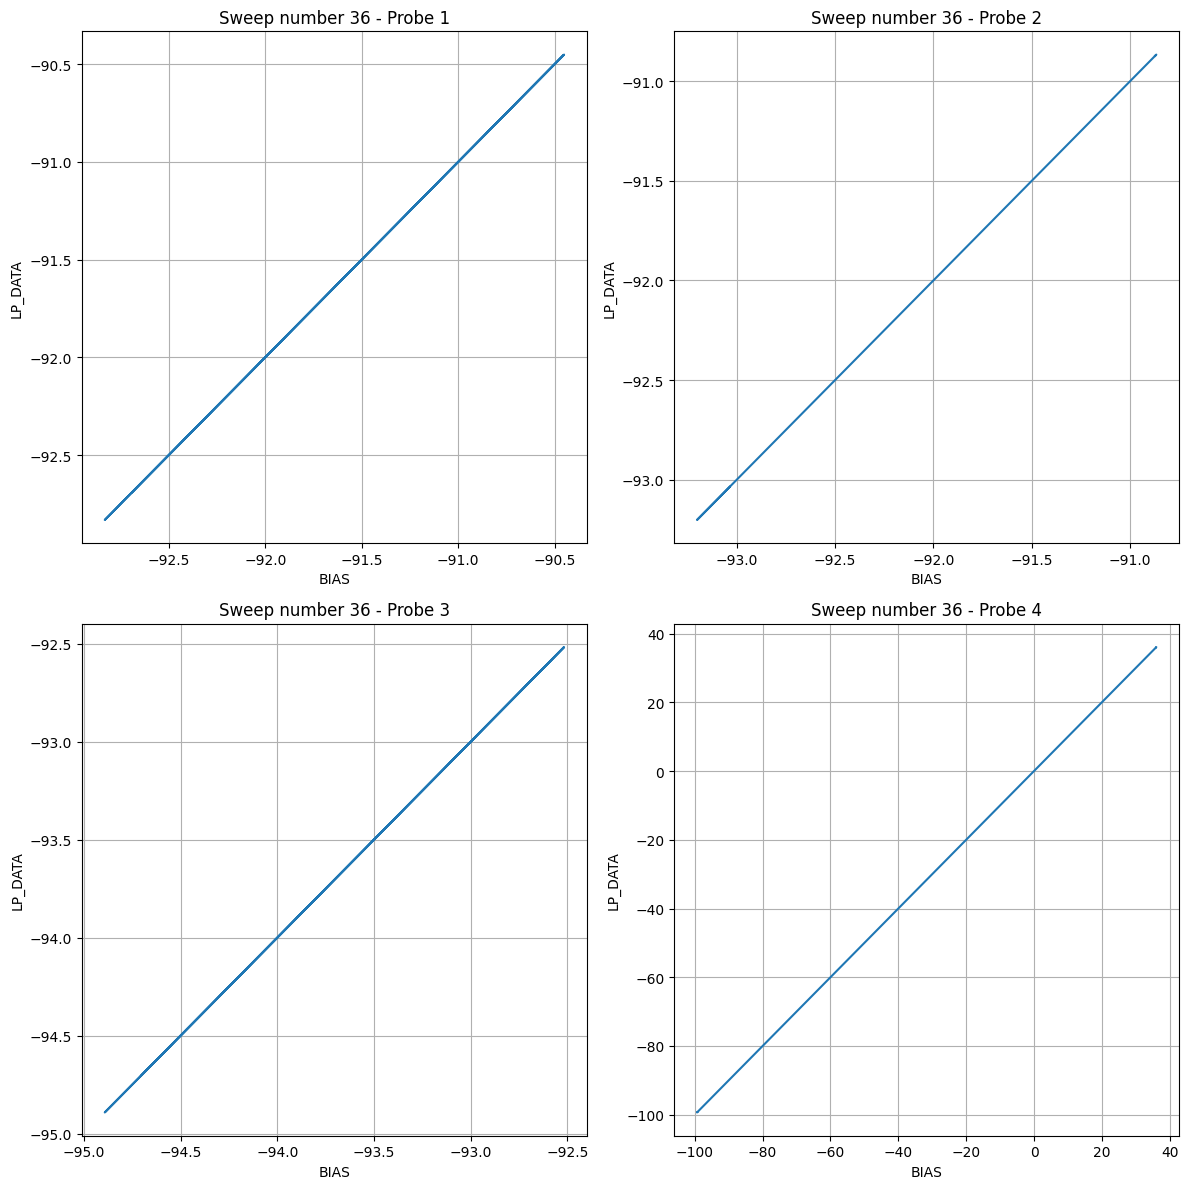

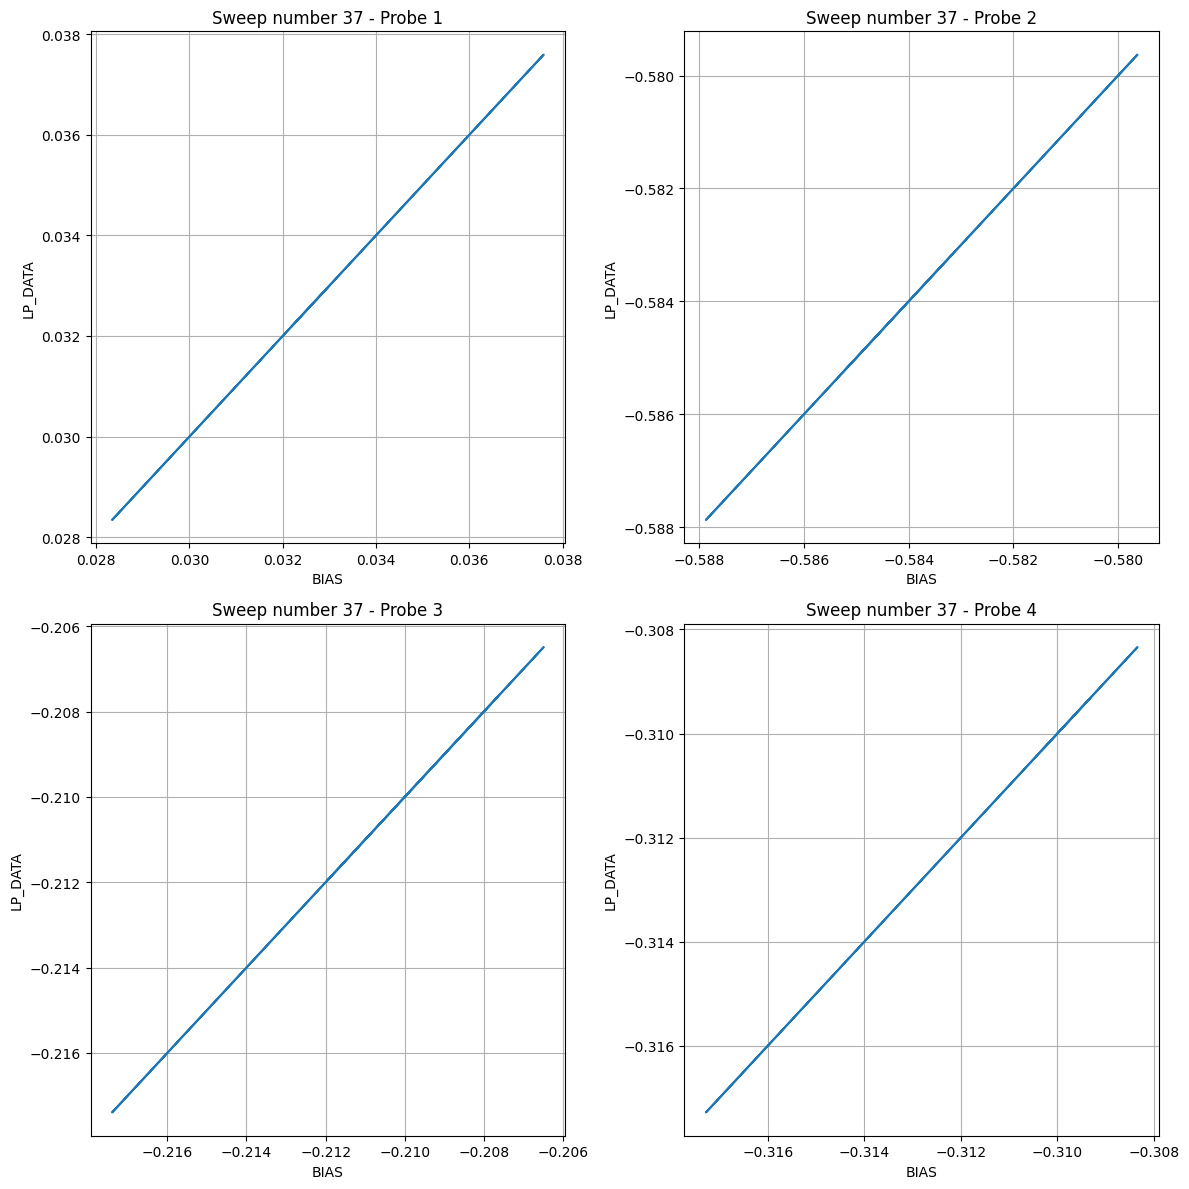

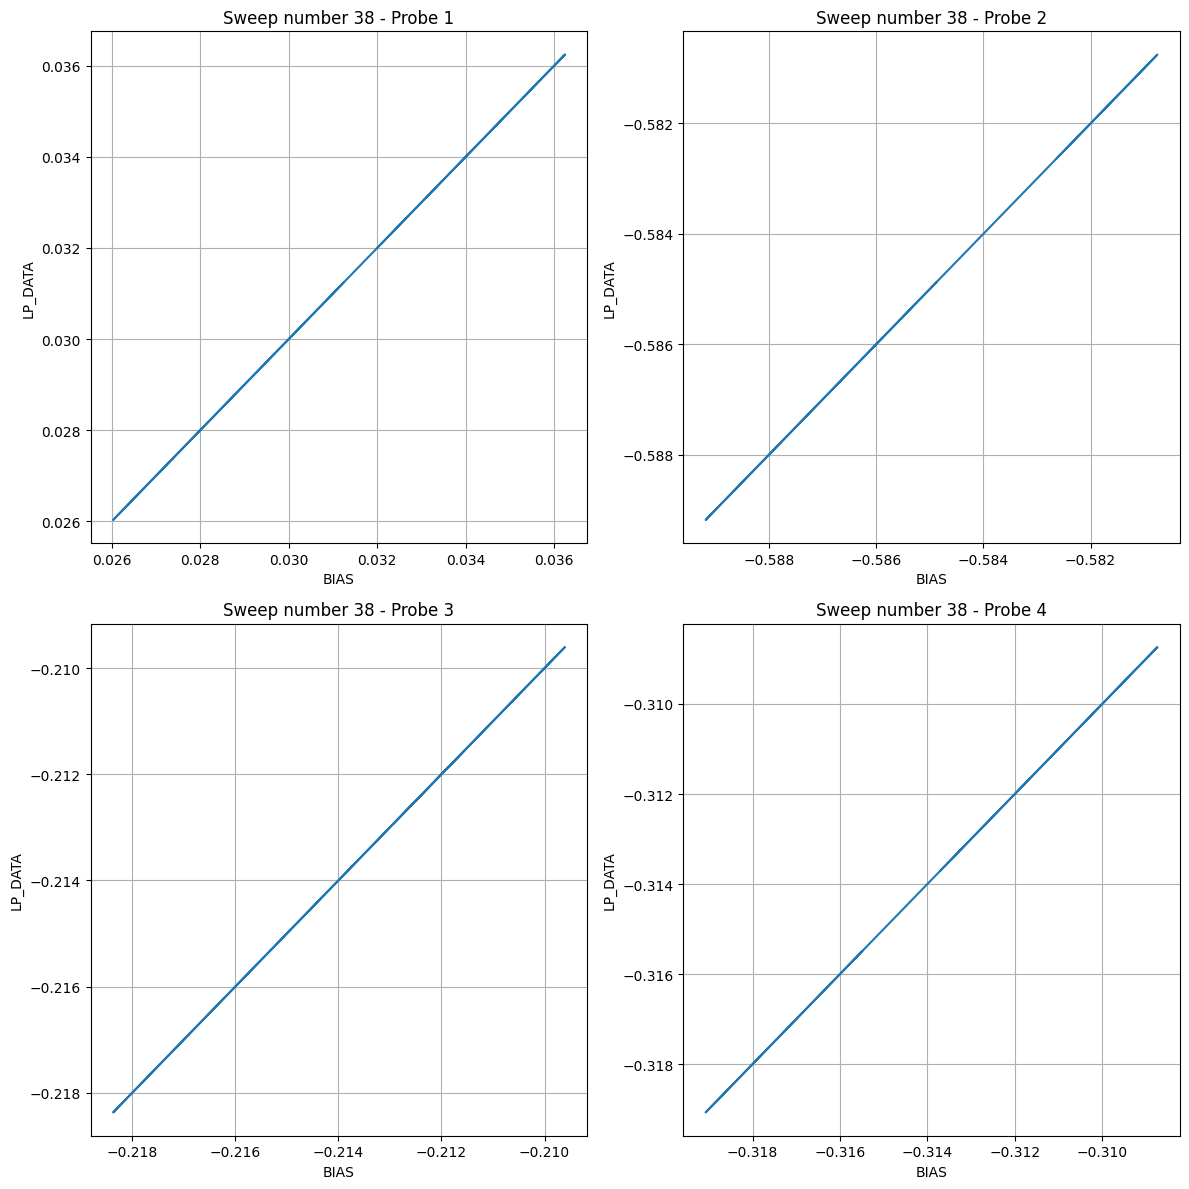

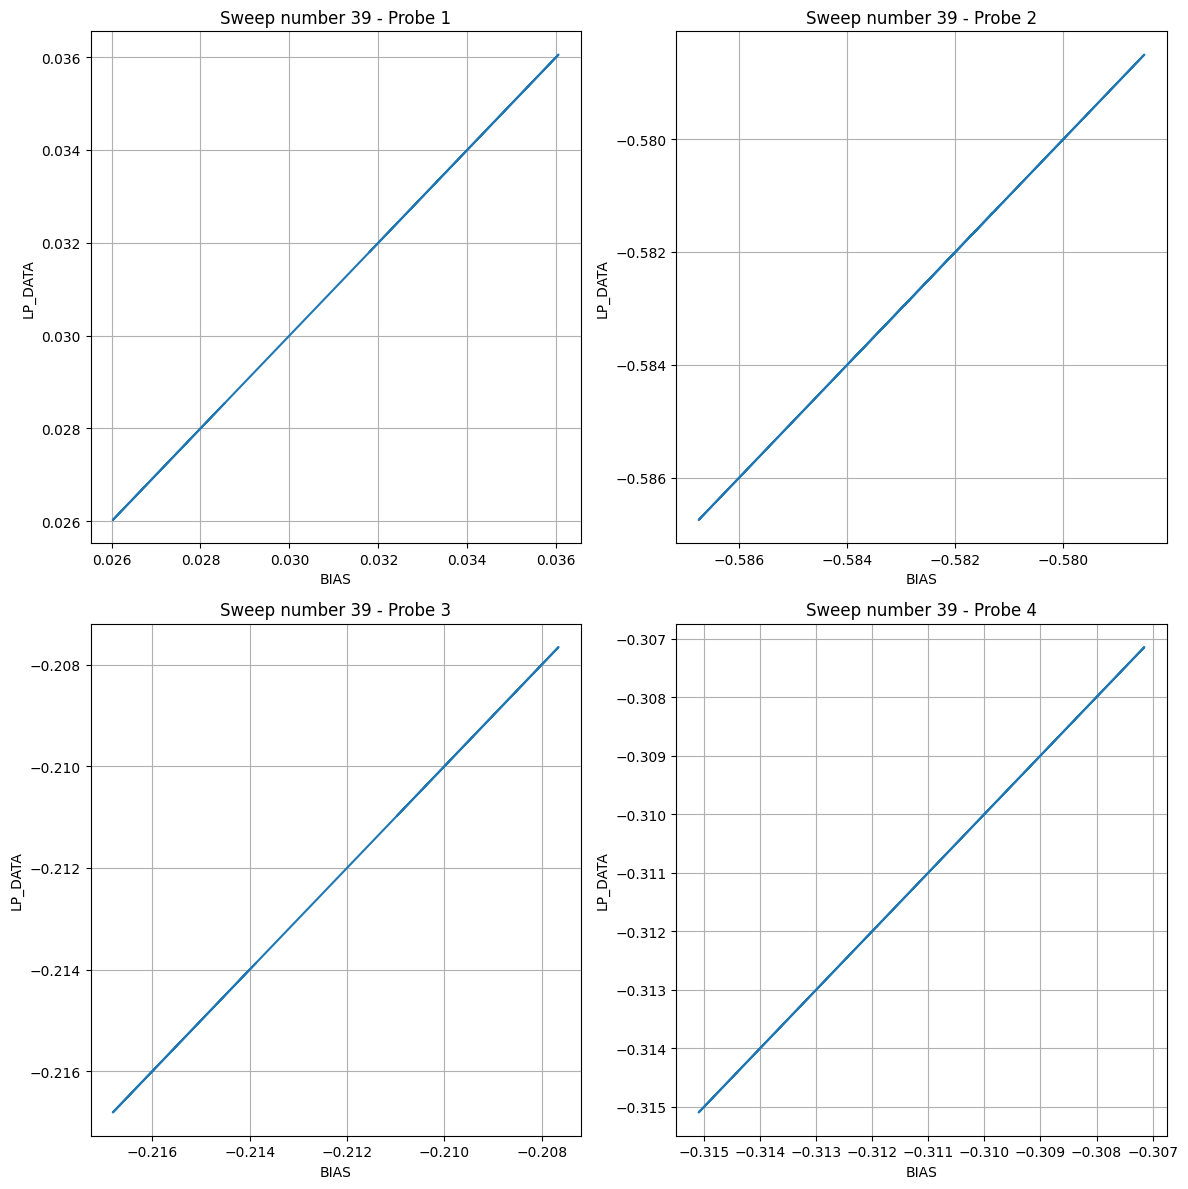

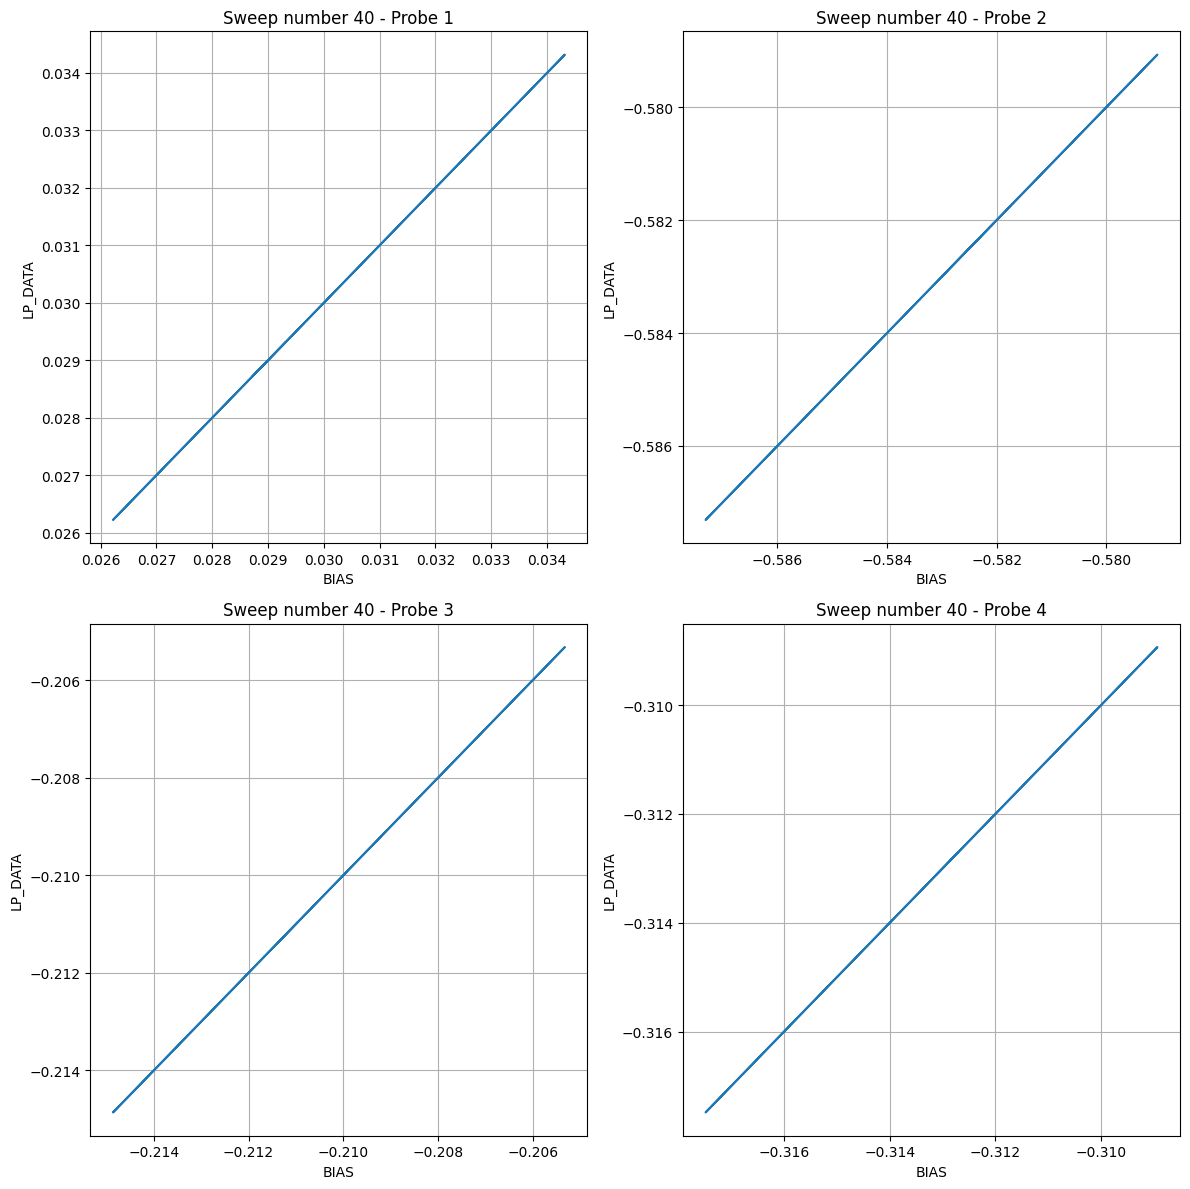

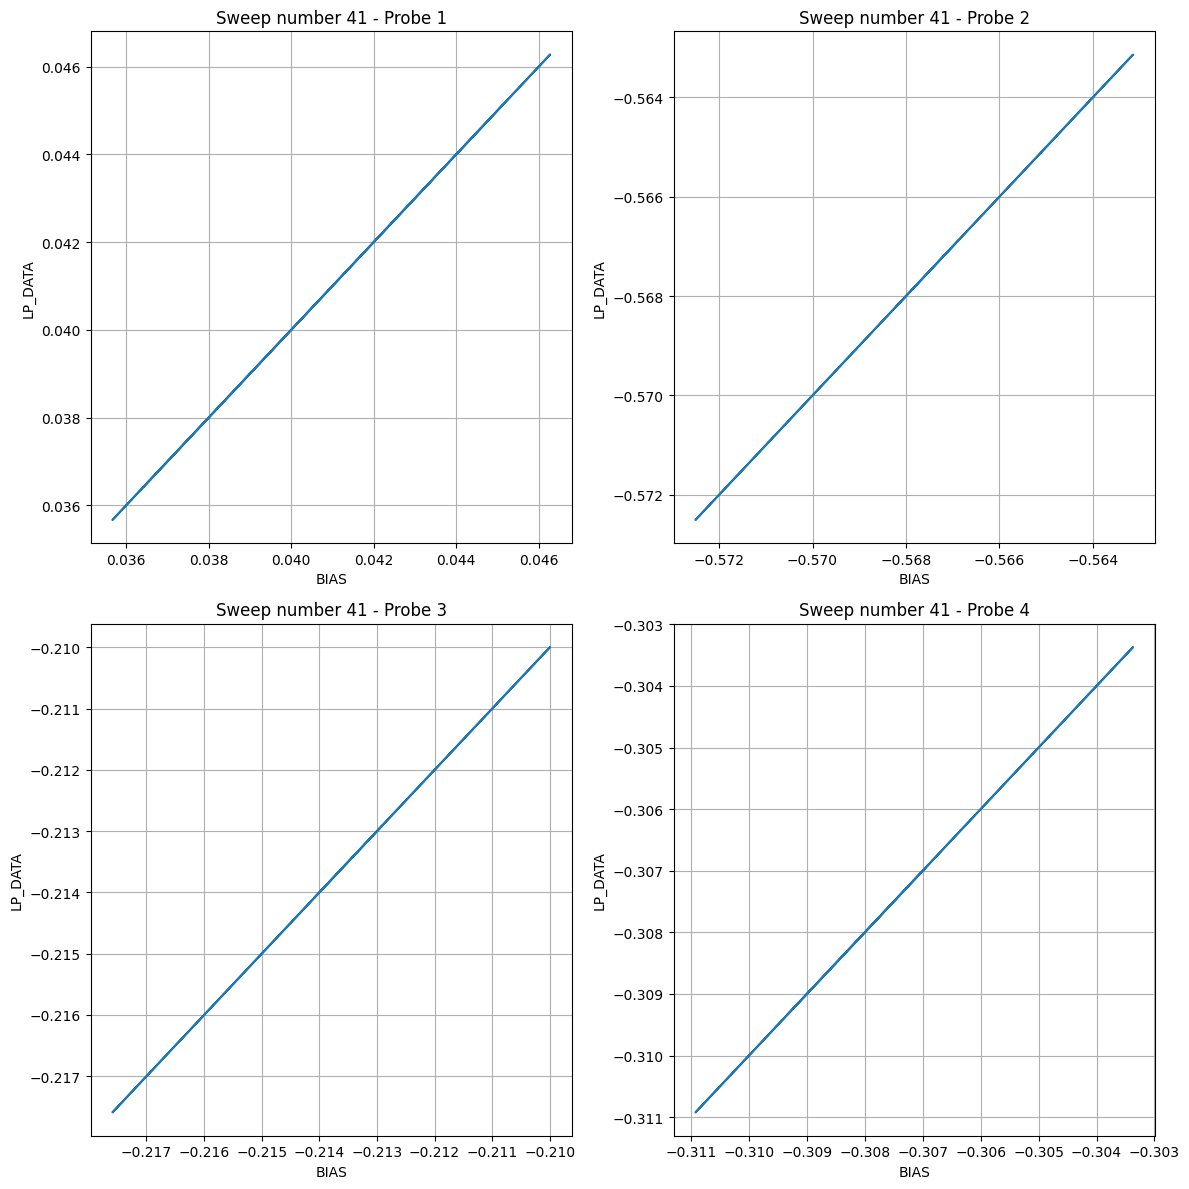

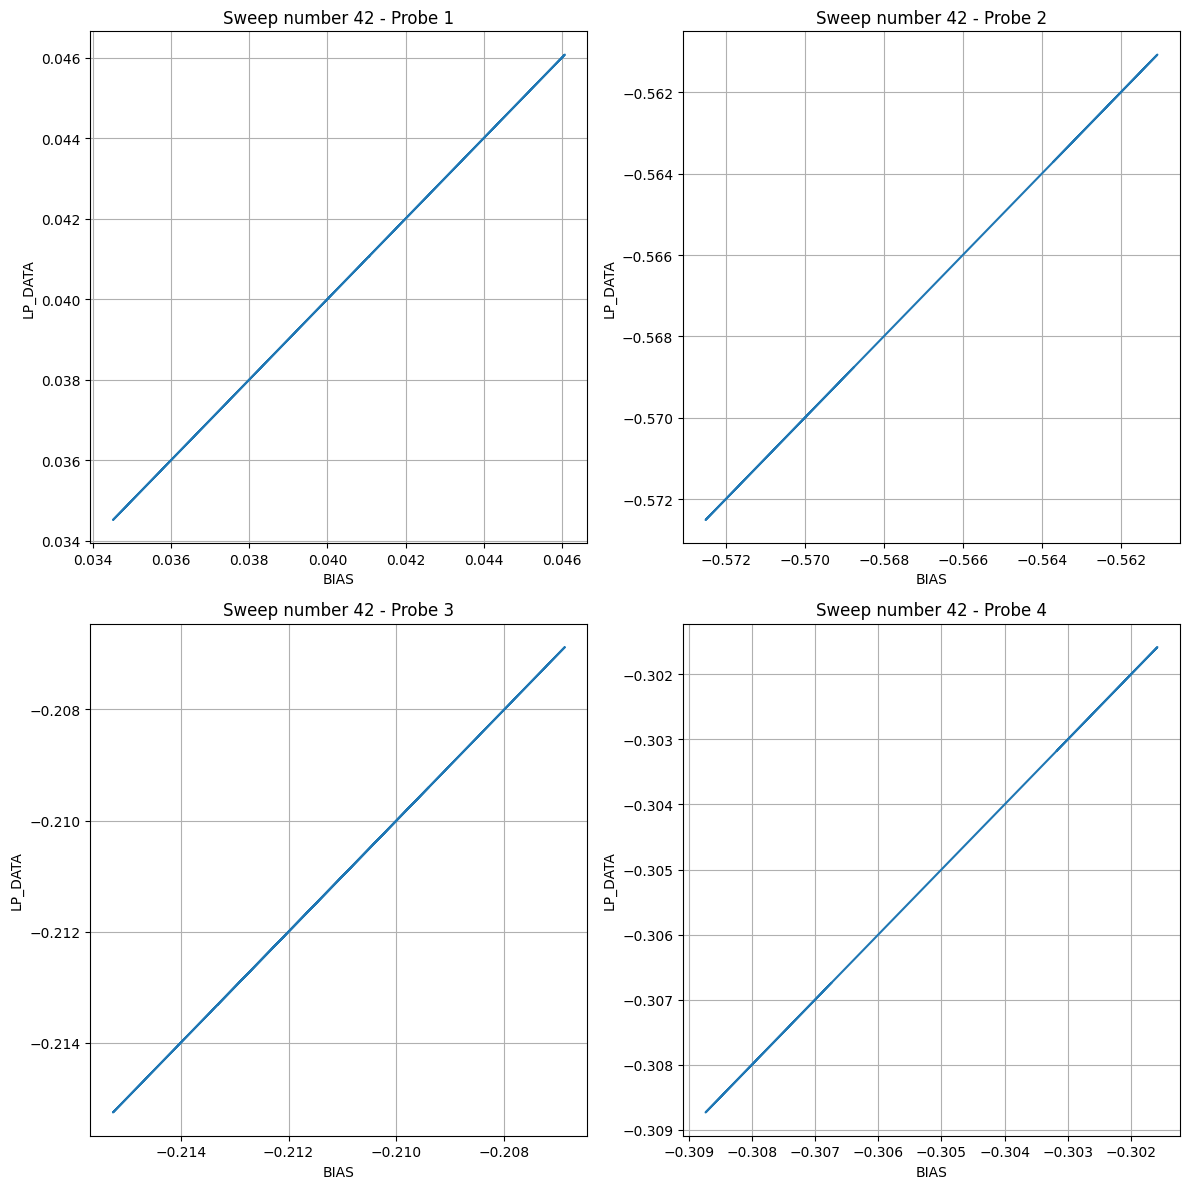

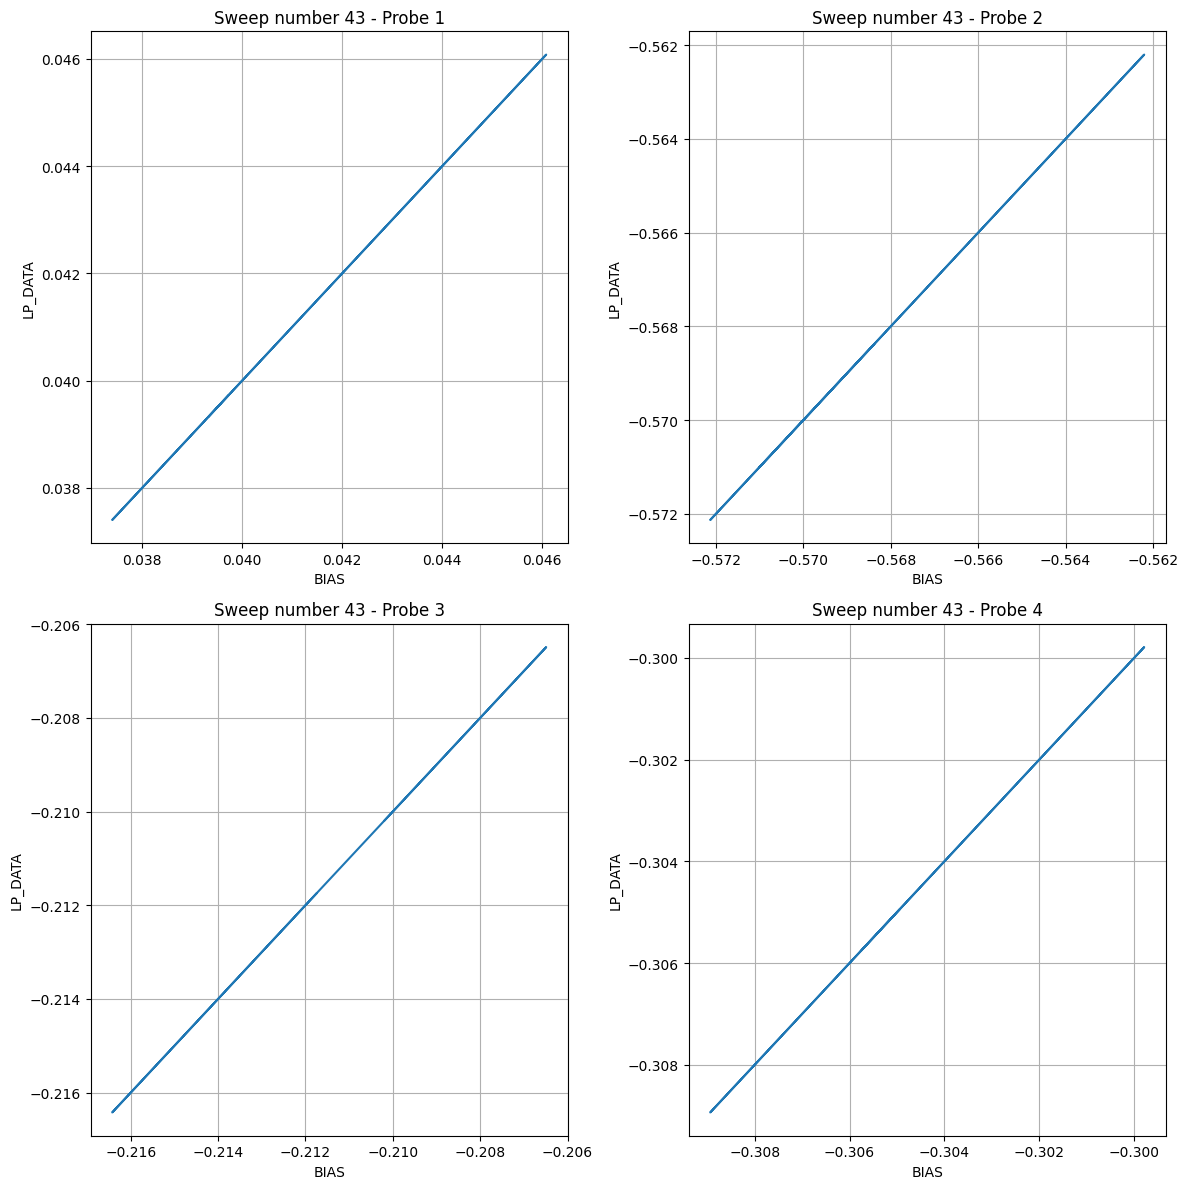

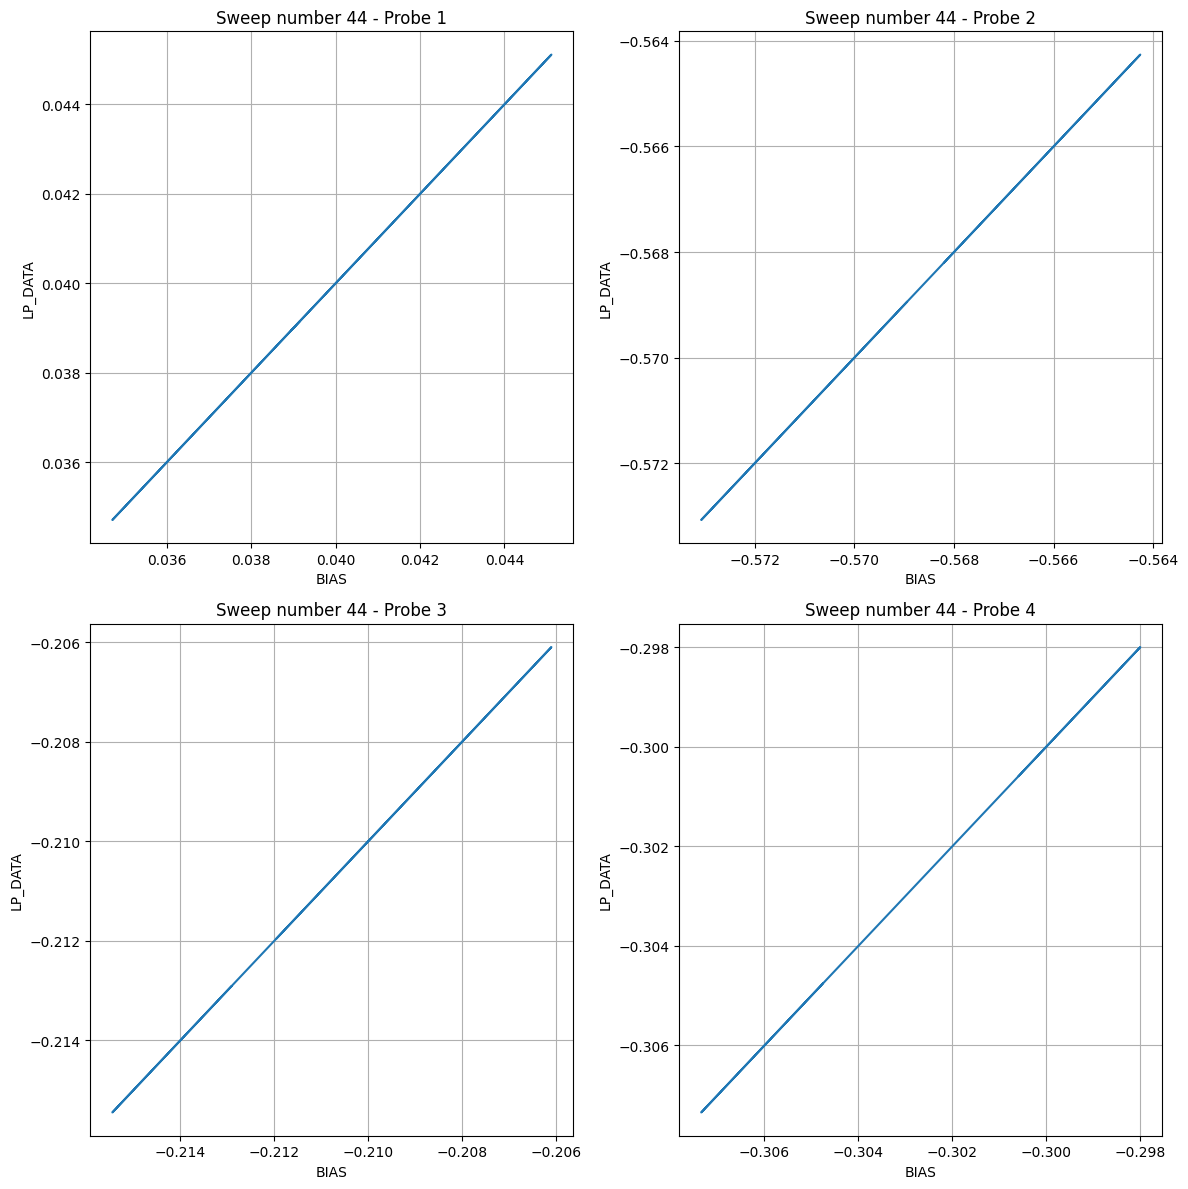

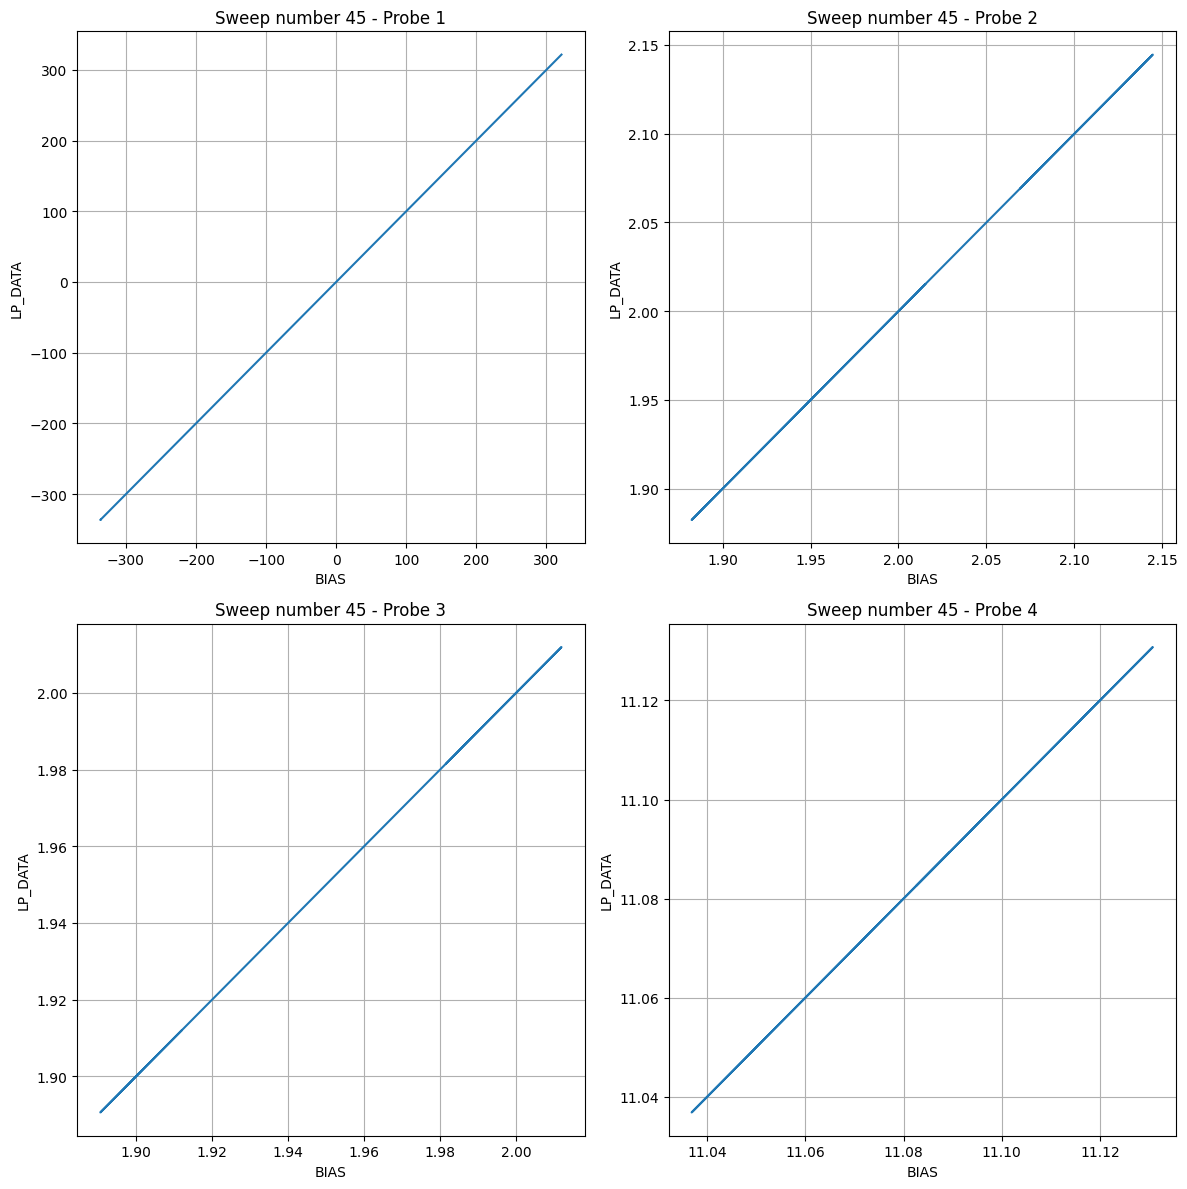

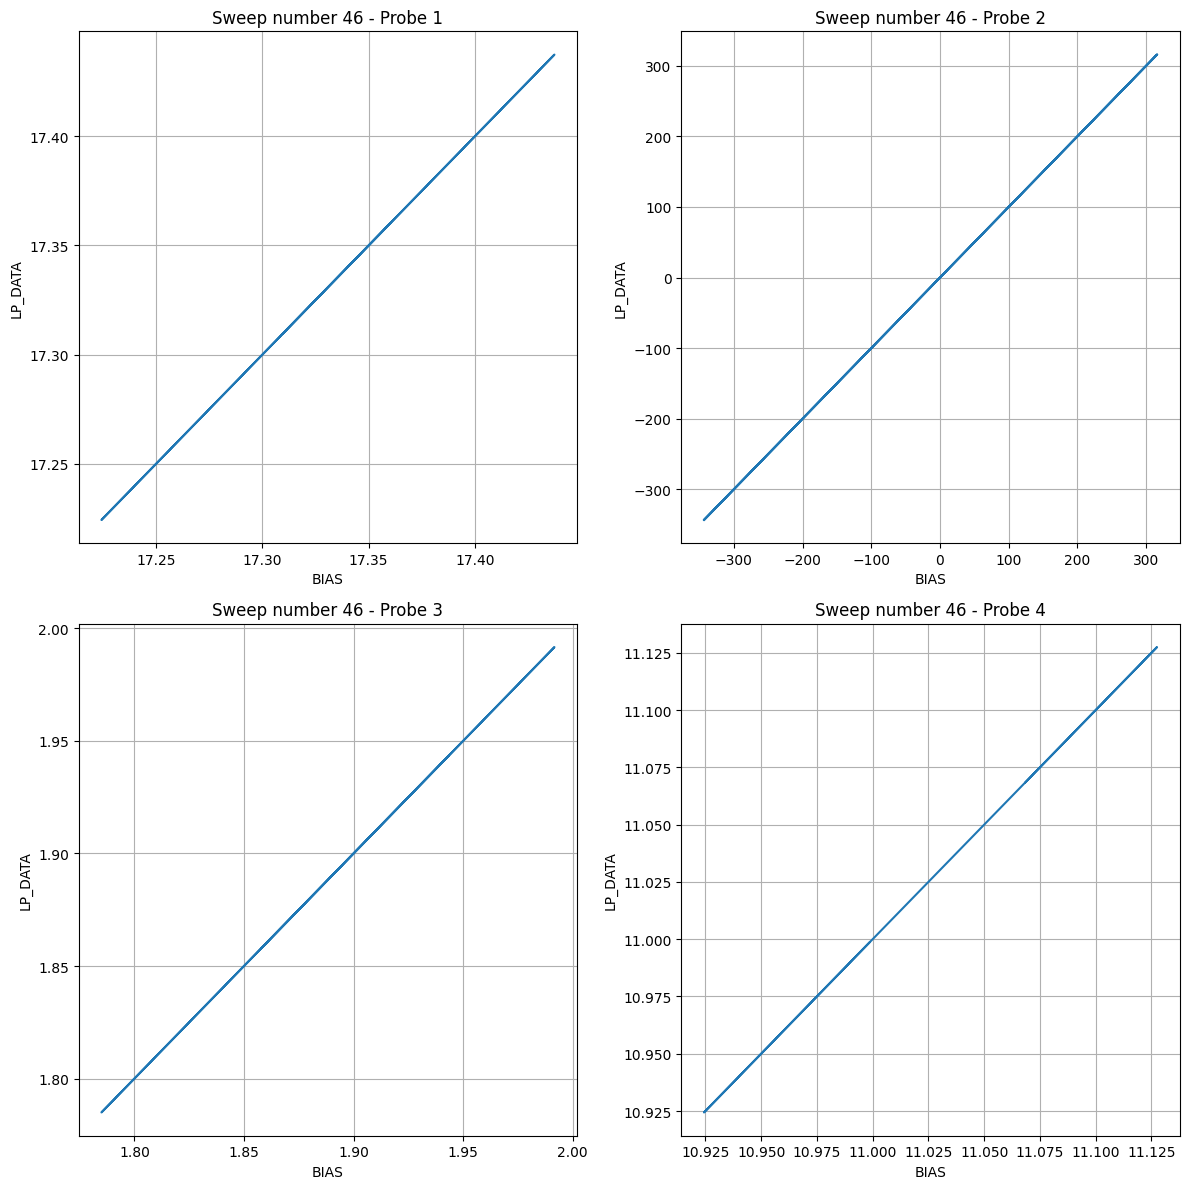

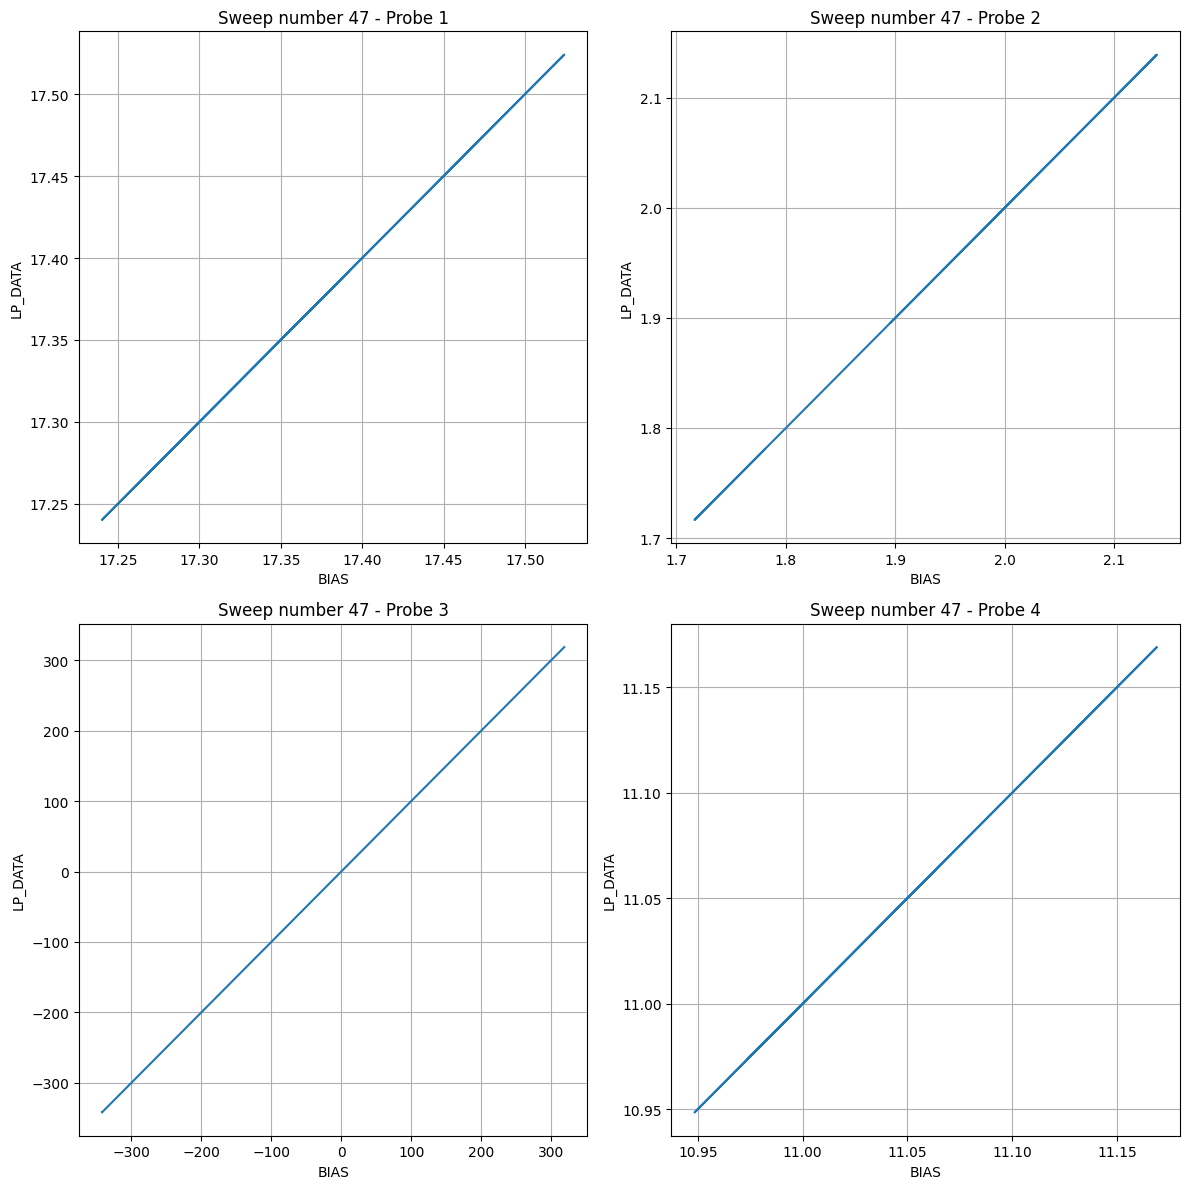

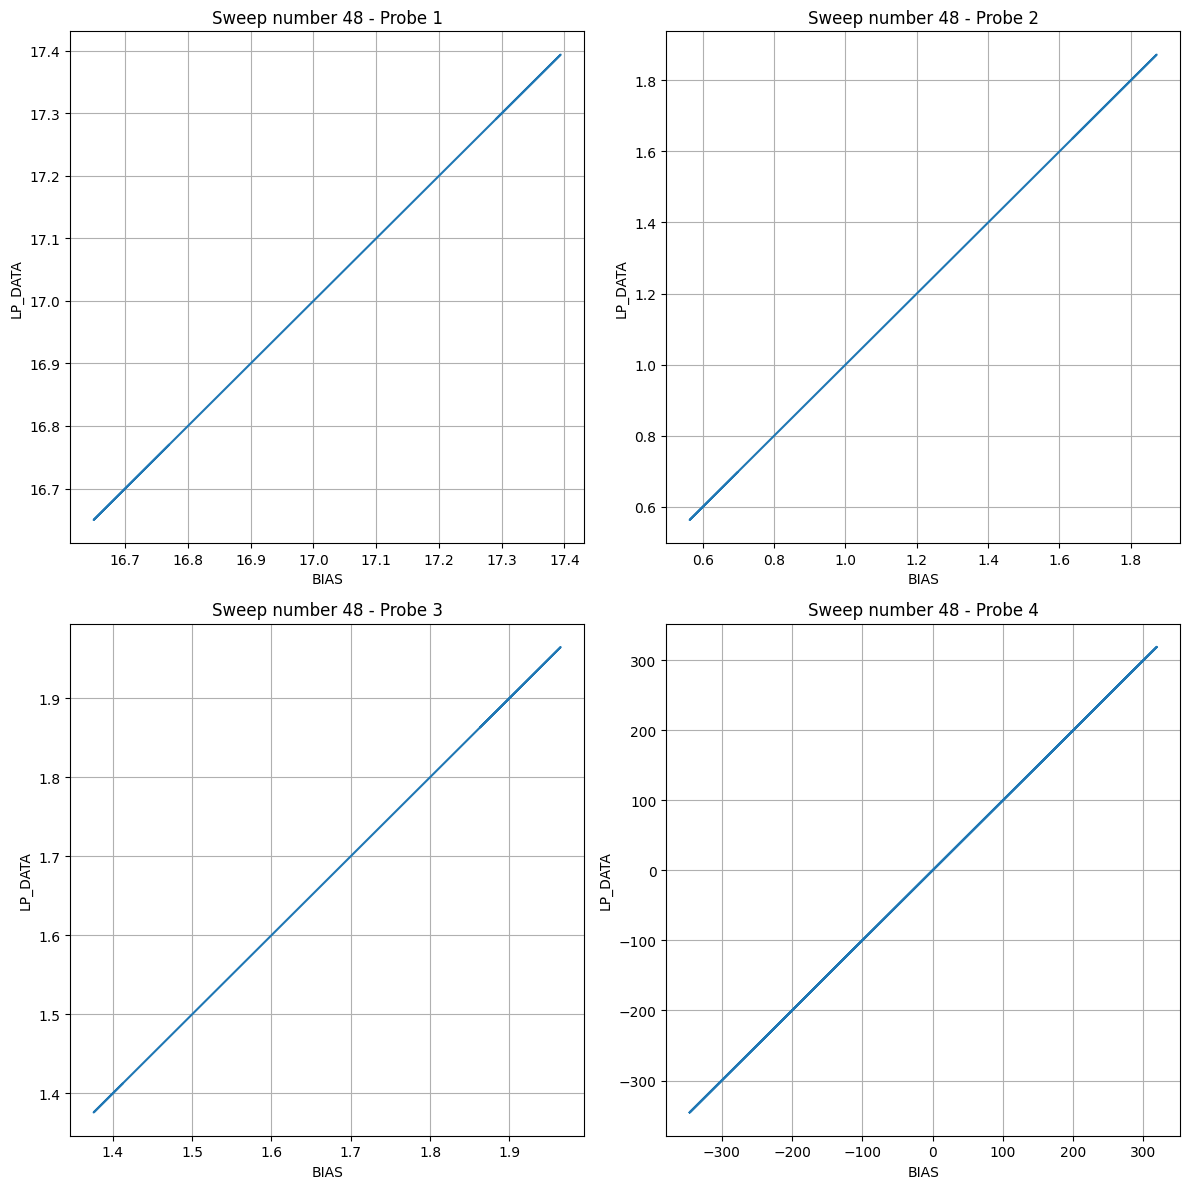

In [23]:
# Sweeps

cdf_file = pycdf.CDF('../DATA/JUICE_L1a_RPWI-LP-SID2_SRVY_SWEEP_20250331T032129_V02.cdf')
#print_info(cdf_file)

epoch = cdf_file['Epoch'][...]
lp_data = cdf_file['LP_DATA_ENG'][...]
bias_data = cdf_file['BIAS_ENG'][...]

# Reshaping lp_data to extract 48 arrays of size 4*5120
filtered_lp_data = [lp_data[i, :, :] for i in range(48)]

# Reshaping bias_data to extract 48 arrays of size 4*5120
filtered_bias_data = [bias_data[i, :, :] for i in range(48)]

filtered_lp_data = [np.where(np.abs(data) > 1e10, np.nan, data) for data in filtered_lp_data]
filtered_bias_data = [np.where(np.abs(data) > 1e10, np.nan, data) for data in filtered_bias_data]

for i in range(48):
    plt.figure(figsize=(12, 12))
    
    for probe in range(4):
        plt.subplot(2, 2, probe + 1)
        plt.plot(filtered_bias_data[i][probe, :], filtered_lp_data[i][probe, :])
        plt.title(f'Sweep number {i+1} - Probe {probe + 1}')
        plt.xlabel('BIAS')
        plt.ylabel('LP_DATA')
        plt.grid()
    
    plt.tight_layout()
    plt.show()

In [13]:
jmag_cdf = pycdf.CDF("../DATA/jmag_echoed/2024/07/02/JUICE_LU_RPWI-PPTD-LWYRPW79700_20240702T003500_V02.cdf")

print_info(jmag_cdf)

Variable: PPH_CCSDS_VERSION_NUMBER
  Data Type: 11
  Dimensions: (542,)
  Attributes: DEPEND_0: Epoch [CDF_CHAR]
FILLVAL: 255 [CDF_UINT1]

Variable: PPH_PRID
  Data Type: 11
  Dimensions: (542,)
  Attributes: DEPEND_0: Epoch [CDF_CHAR]
FILLVAL: 255 [CDF_UINT1]

Variable: PPH_PACKET_CATEGORY
  Data Type: 11
  Dimensions: (542,)
  Attributes: DEPEND_0: Epoch [CDF_CHAR]
FILLVAL: 255 [CDF_UINT1]

Variable: PPH_SEGMENTATION_GROUPING_FLAG
  Data Type: 11
  Dimensions: (542,)
  Attributes: CATDESC: Flag for how to group PUS packets. [CDF_CHAR]
DEPEND_0: Epoch [CDF_CHAR]
FILLVAL: 255 [CDF_UINT1]
VAR_NOTES: 0 = Continuation packet in group of packets (neither first nor last); 1 = First packet in group of packets; 2 = Last packet in a group of packets; 3 = Standalone packet (not in a group of packets) [CDF_CHAR]

Variable: PPH_SEQUENCE_CNT
  Data Type: 12
  Dimensions: (542,)
  Attributes: DEPEND_0: Epoch [CDF_CHAR]
FILLVAL: 65535 [CDF_UINT2]

Variable: PPH_PACKET_LENGTH
  Data Type: 14
  Dimens